Optimal polynomial degree and regularization lambda: 5 0.1
Weights for optimal degree=5, lambda=0.1:
 [-0.0064915   2.22077274  1.92397956  1.45433632  0.97720426  0.55689988]


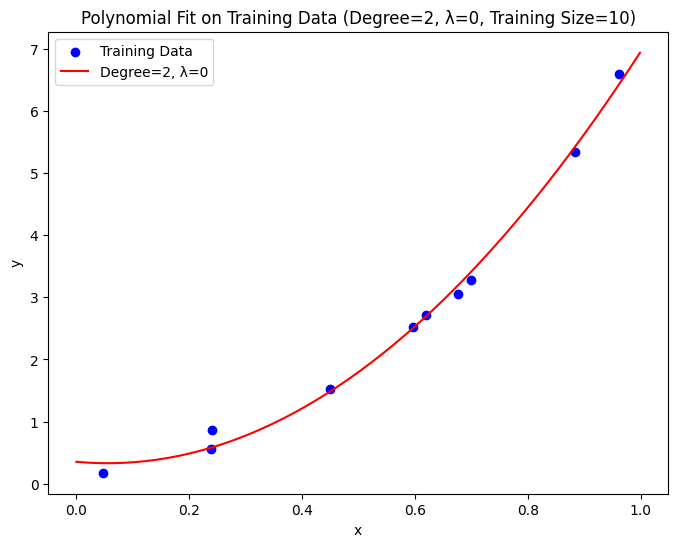

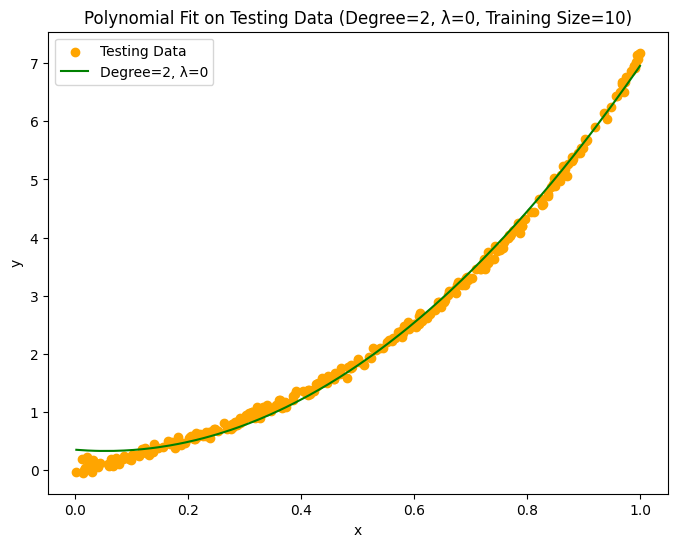

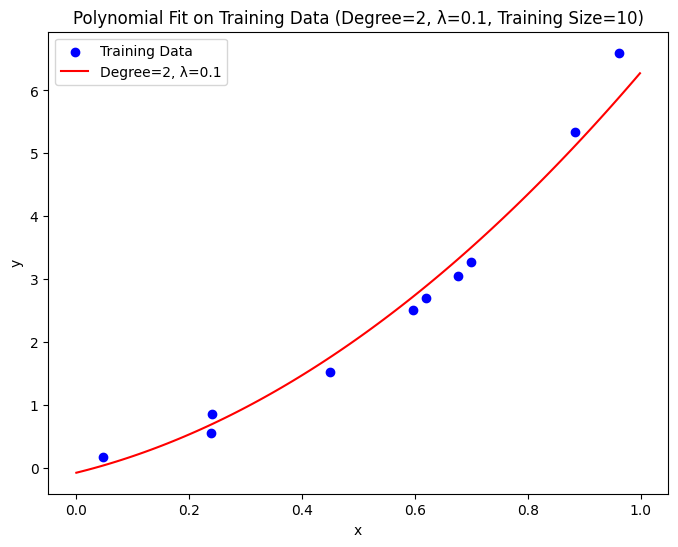

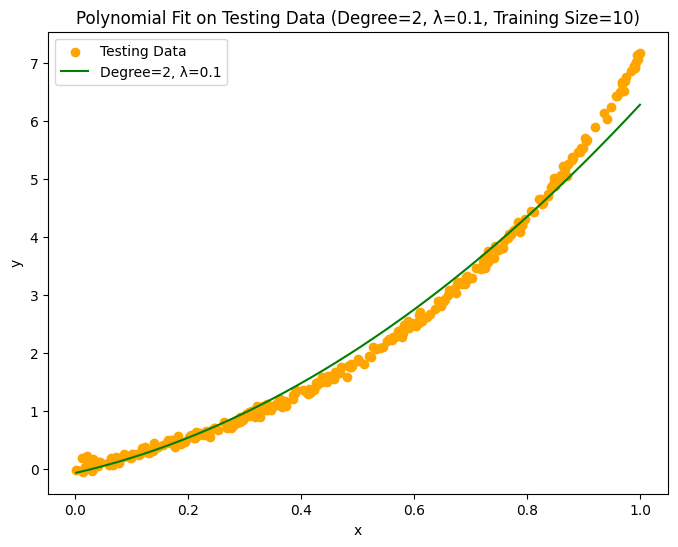

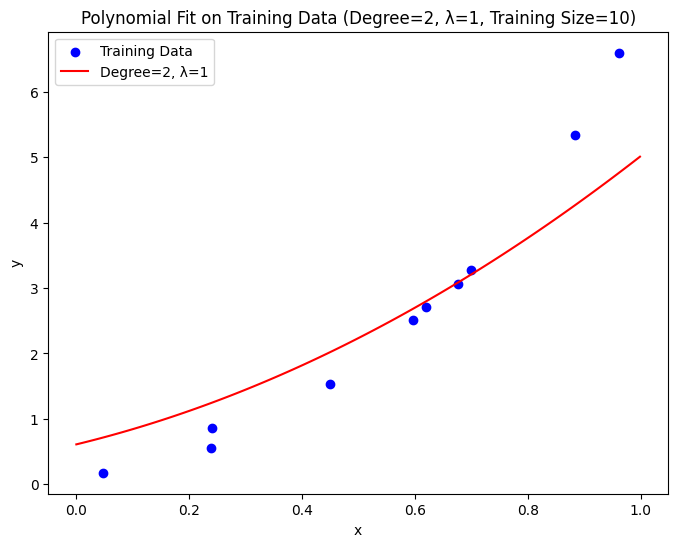

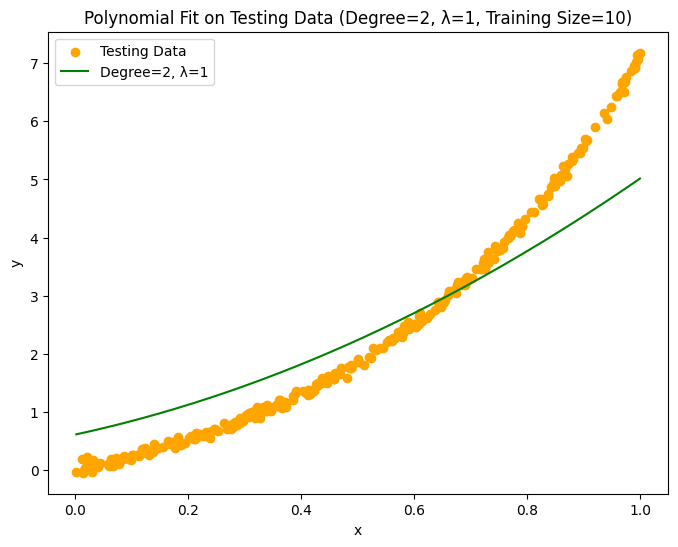

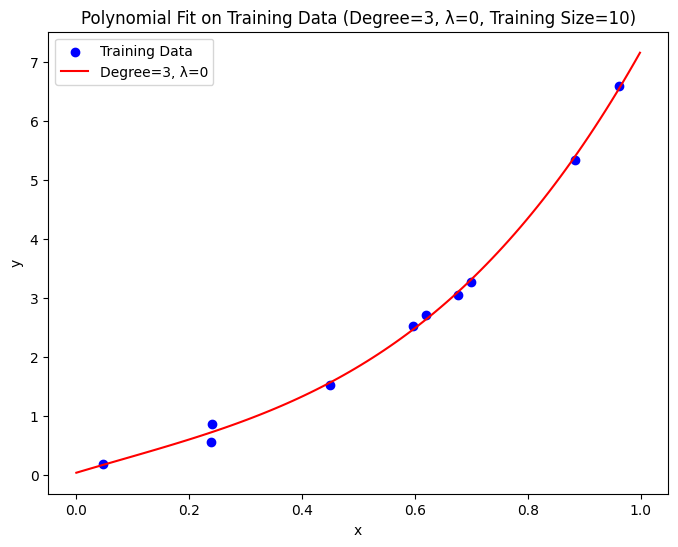

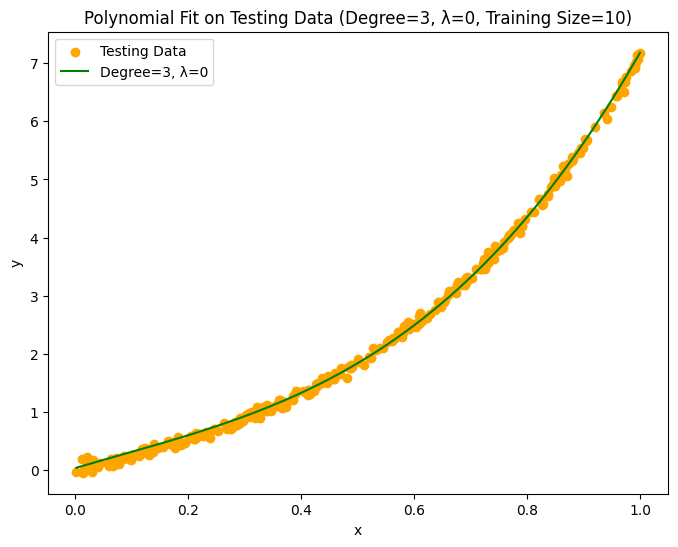

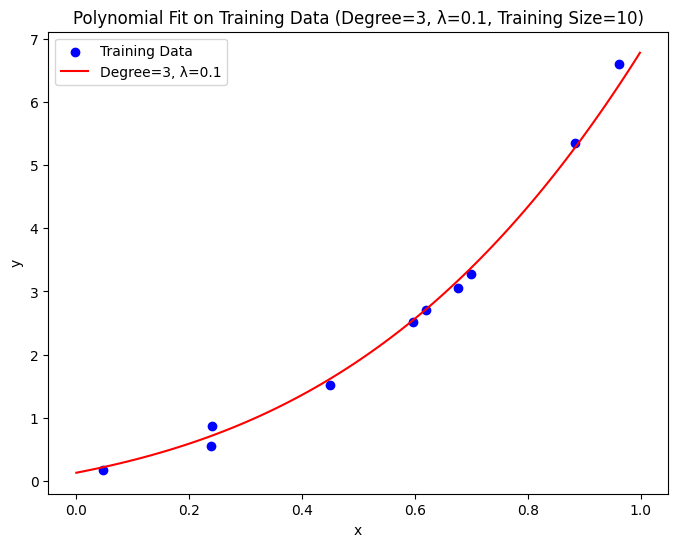

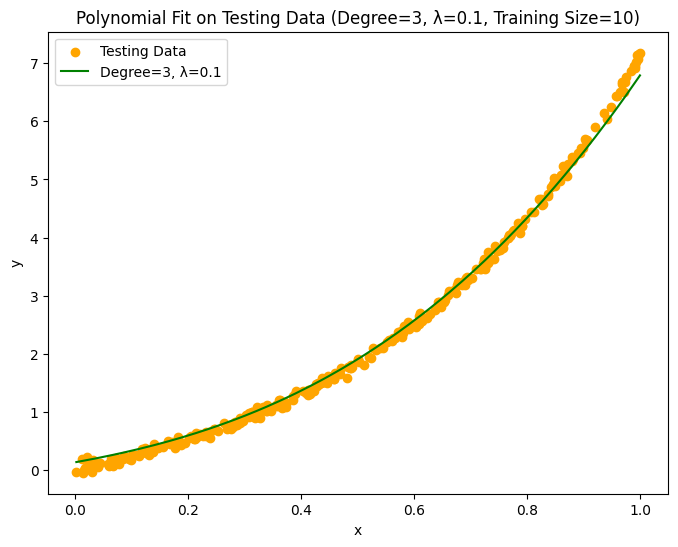

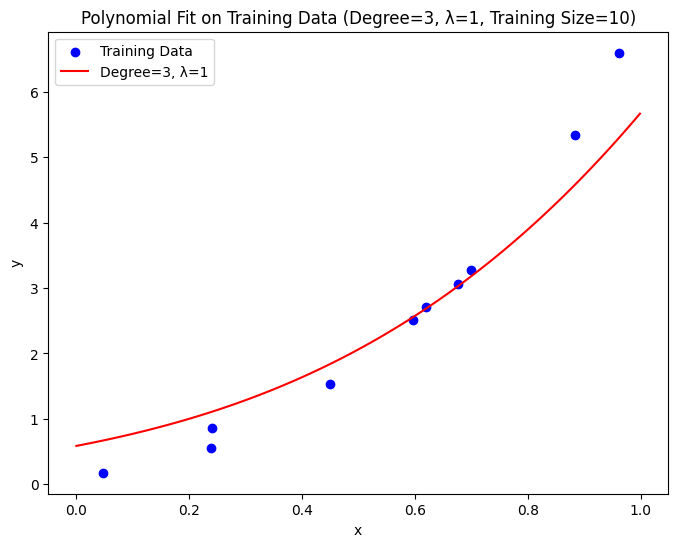

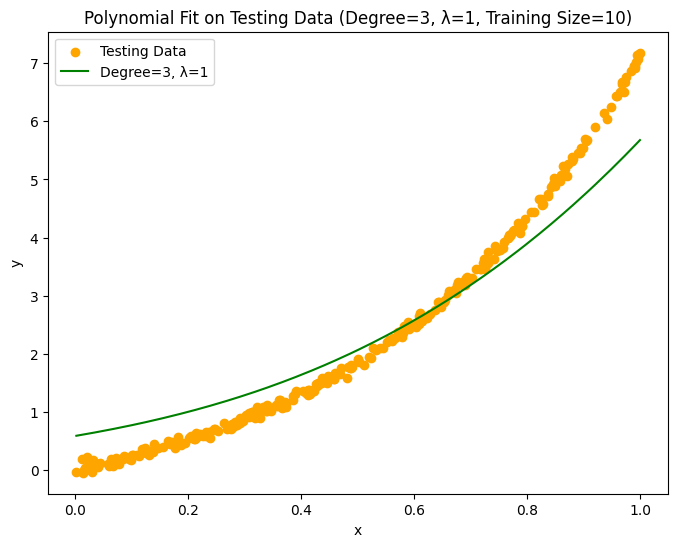

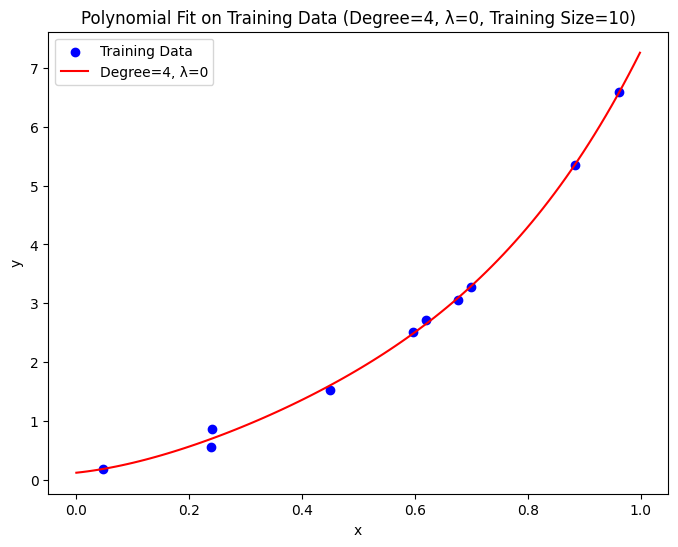

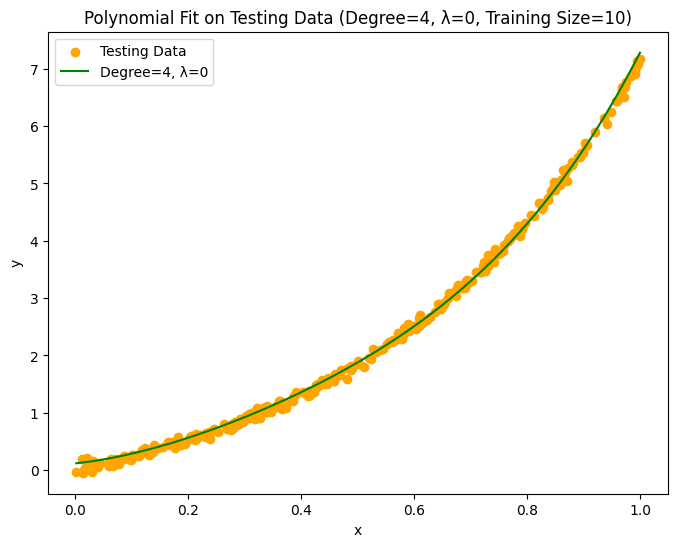

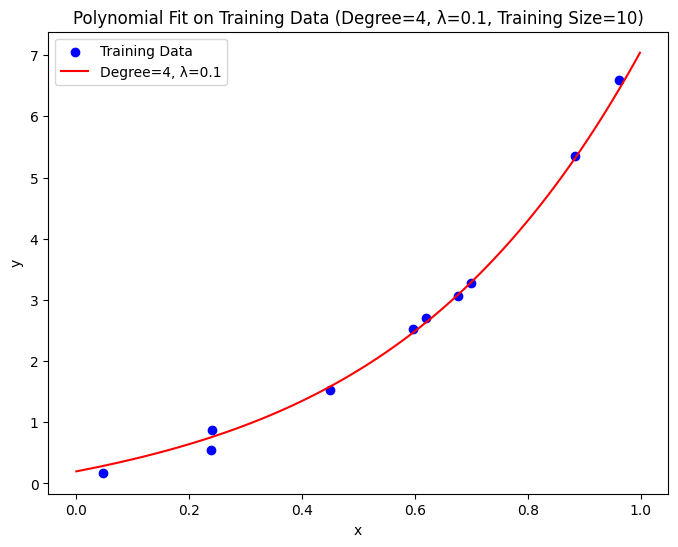

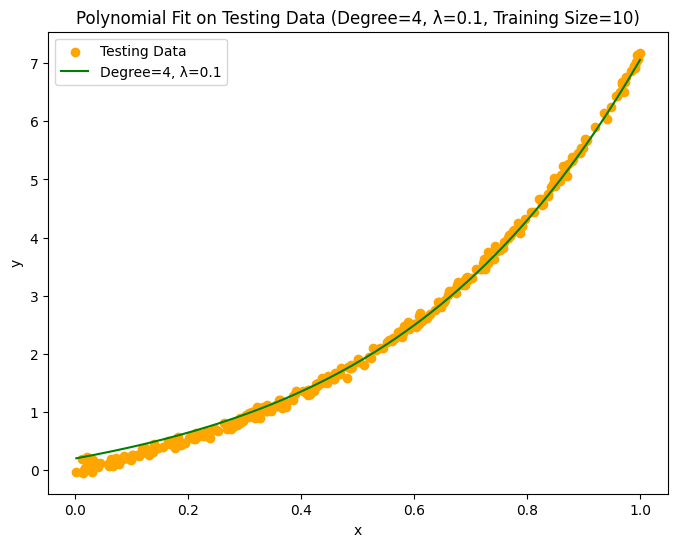

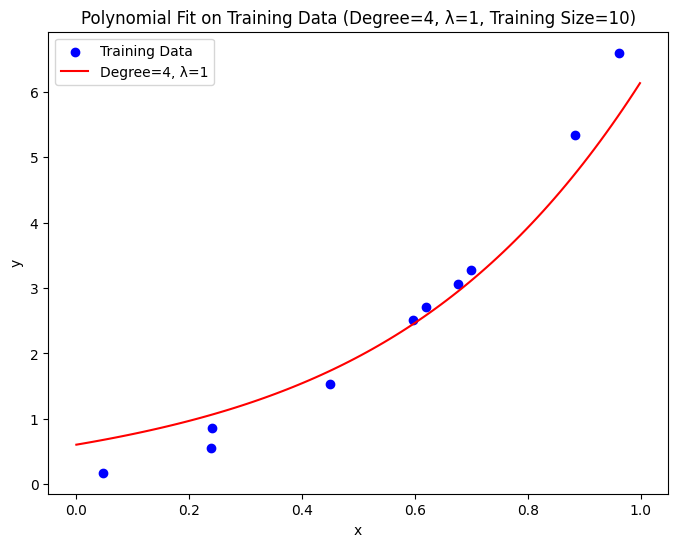

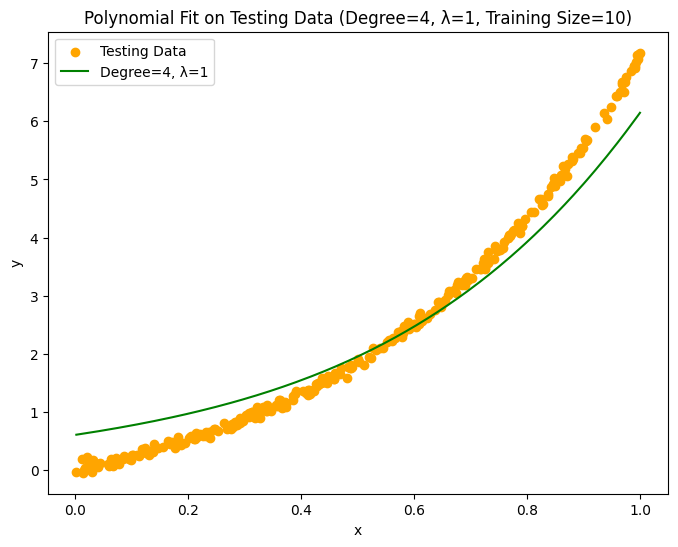

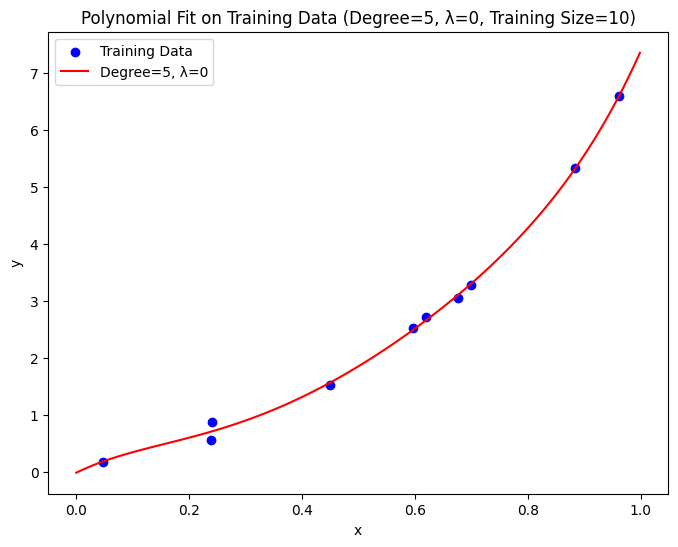

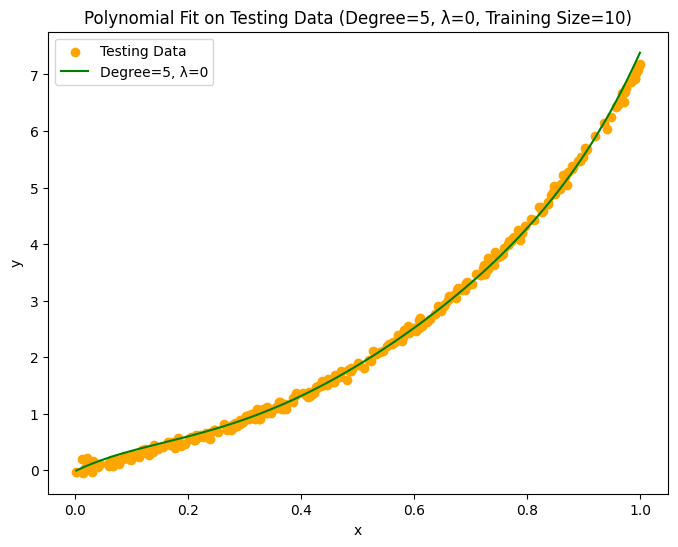

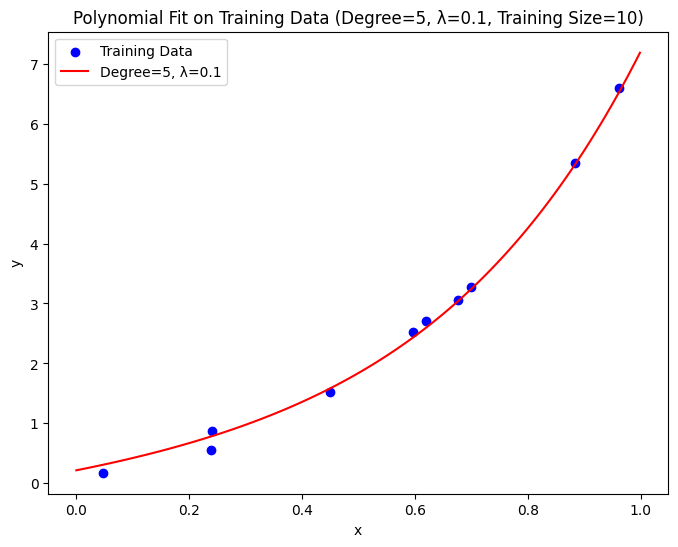

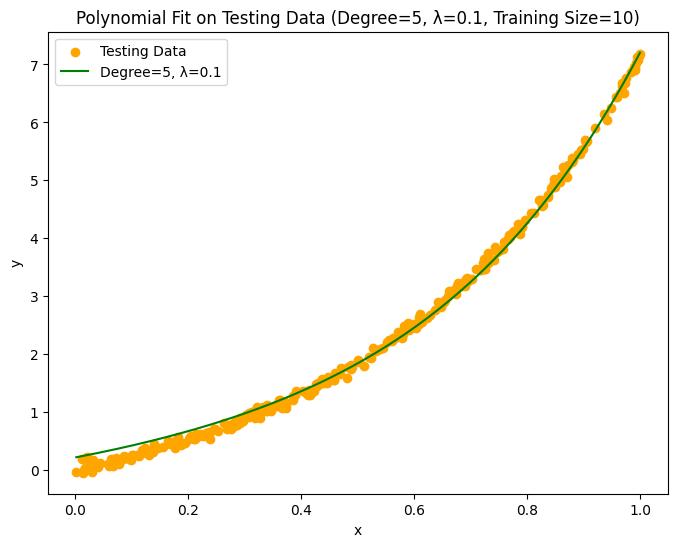

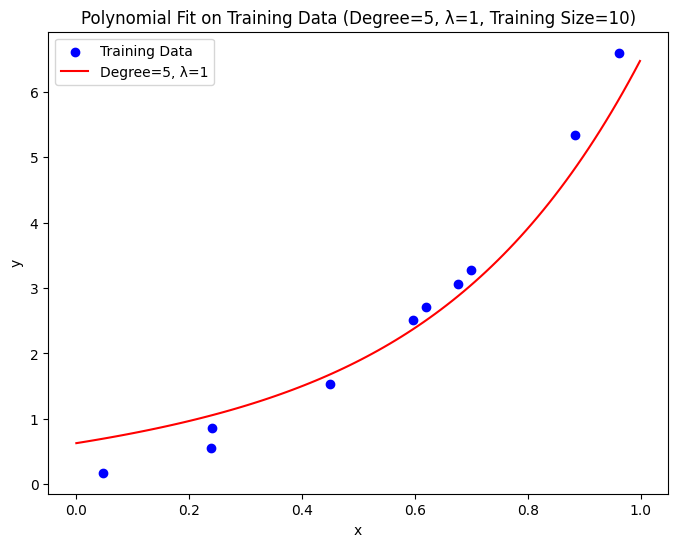

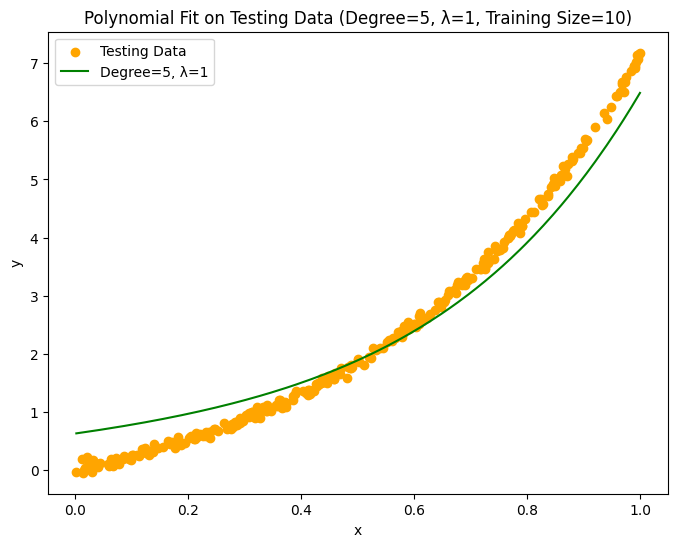

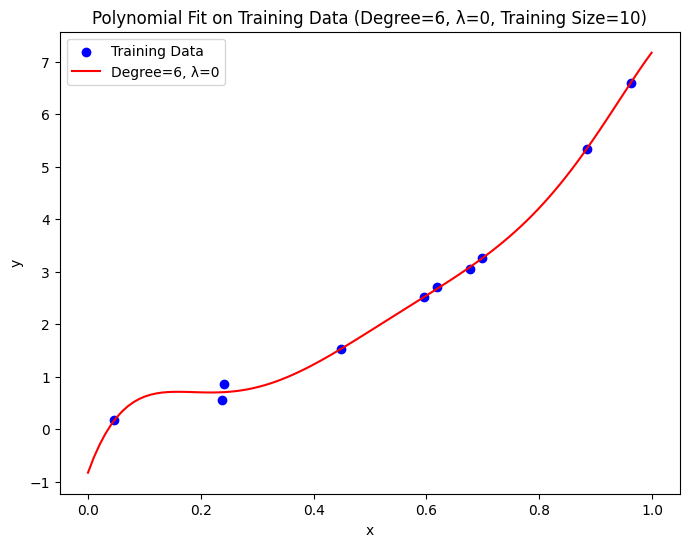

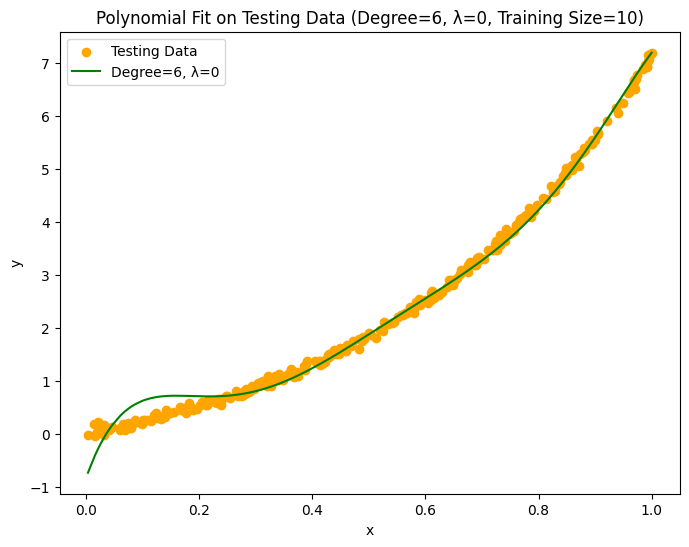

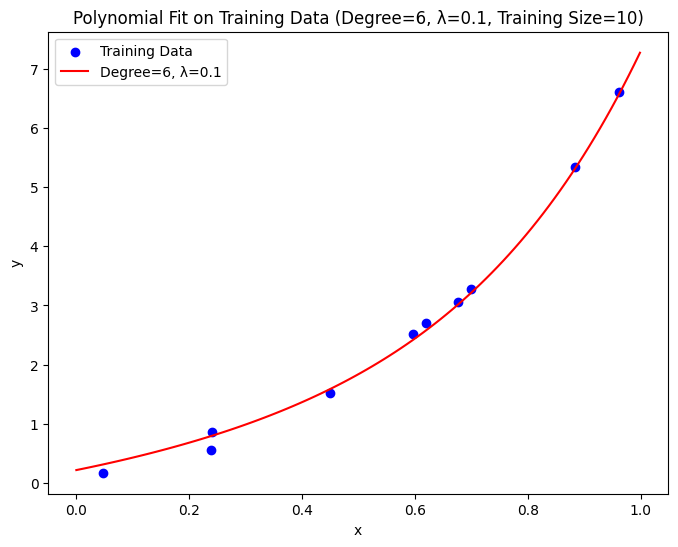

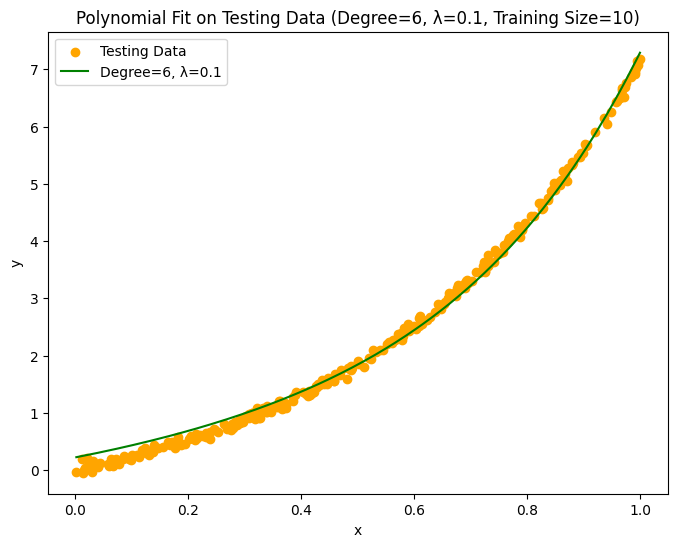

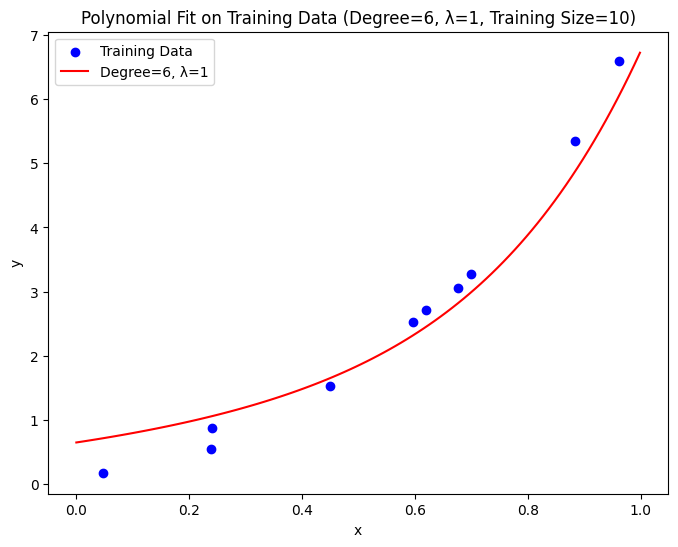

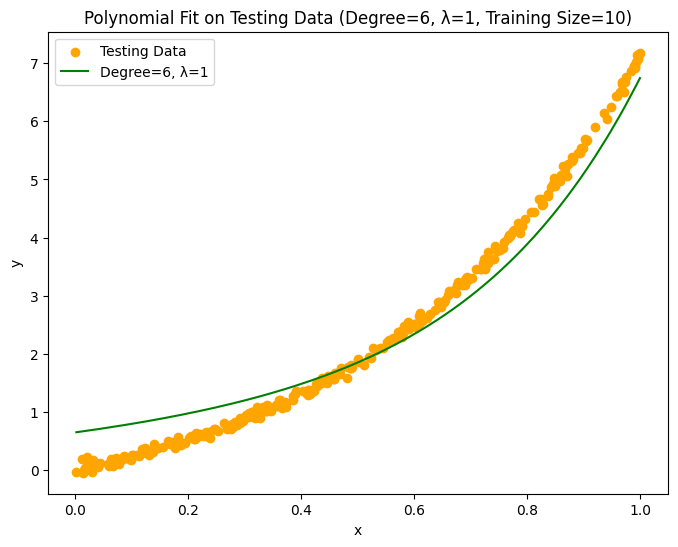

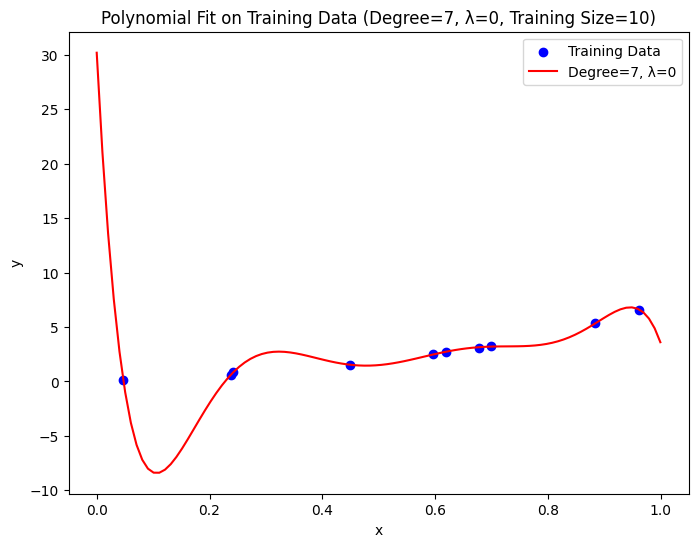

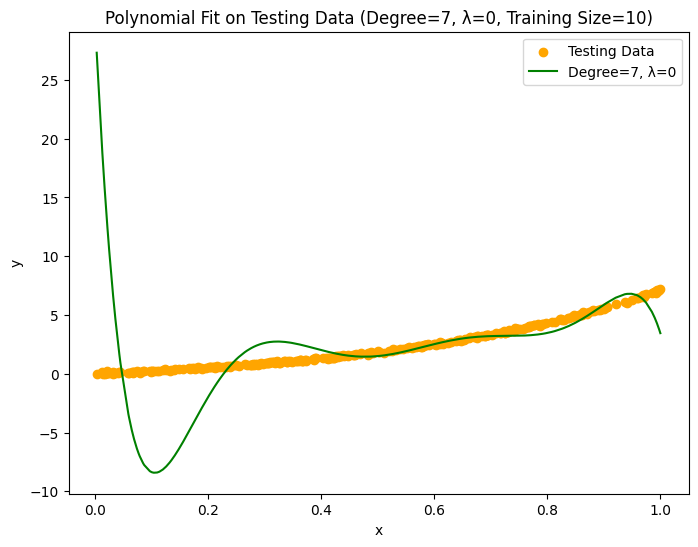

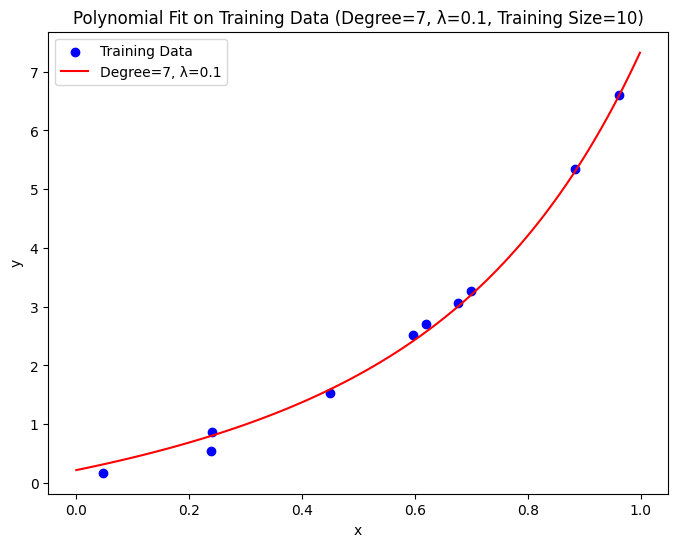

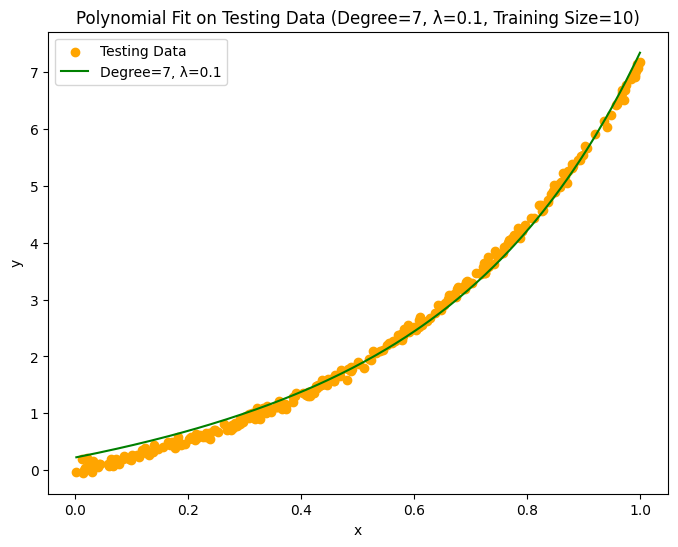

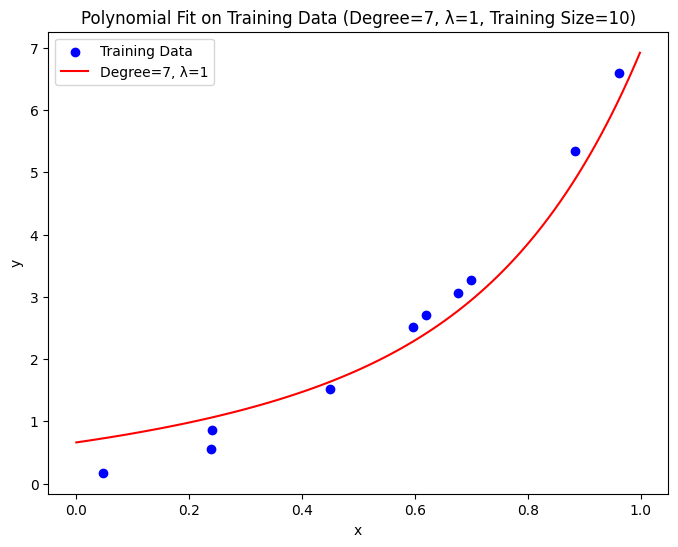

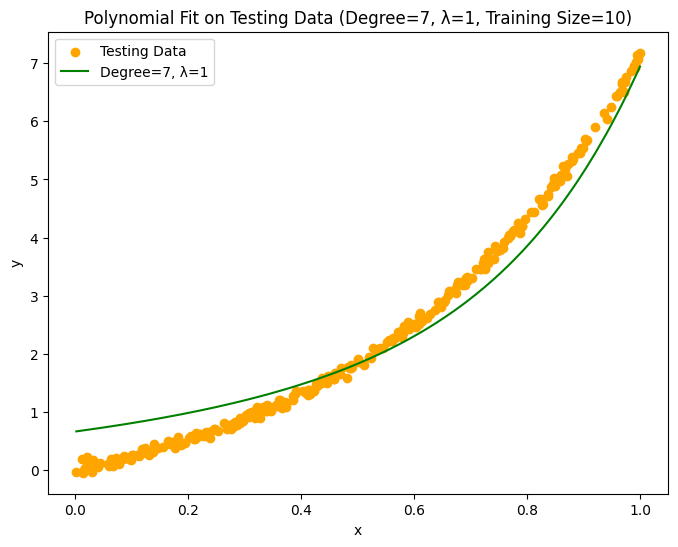

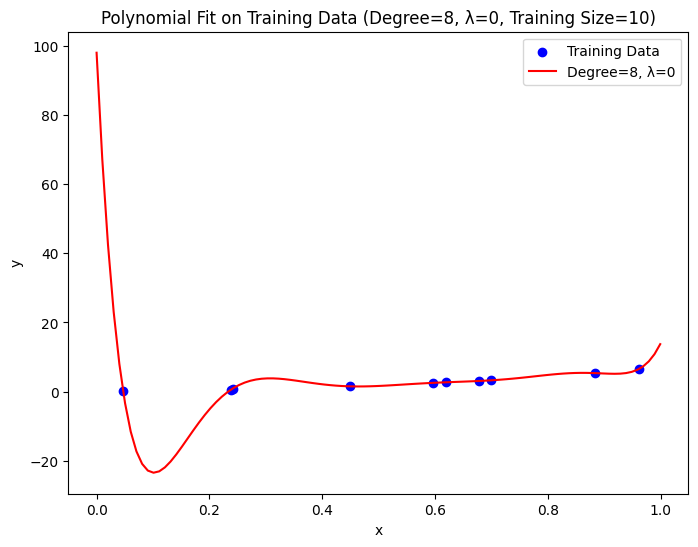

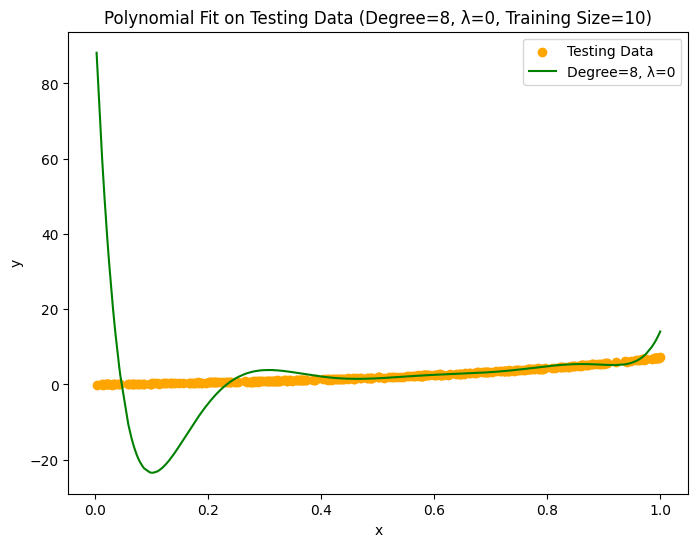

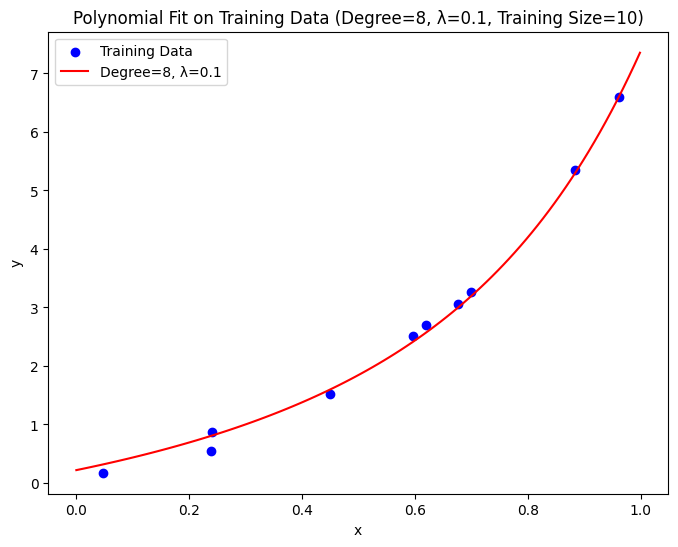

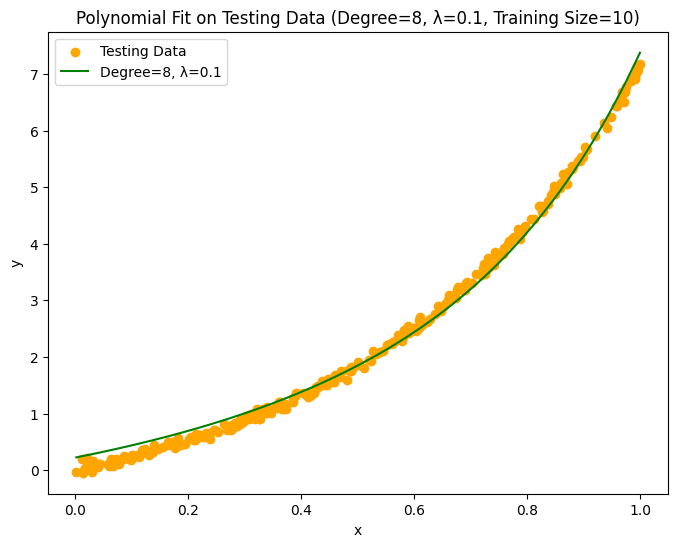

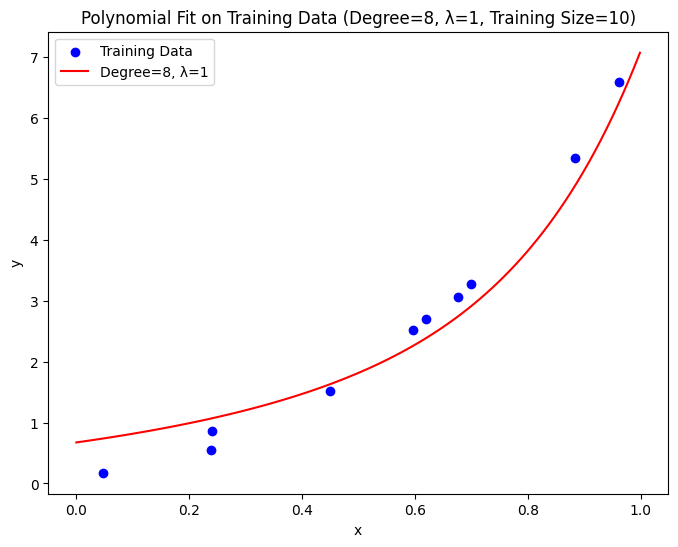

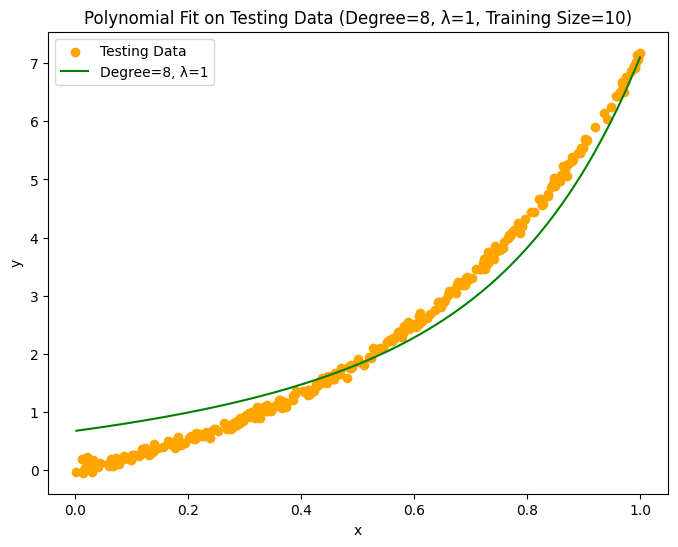

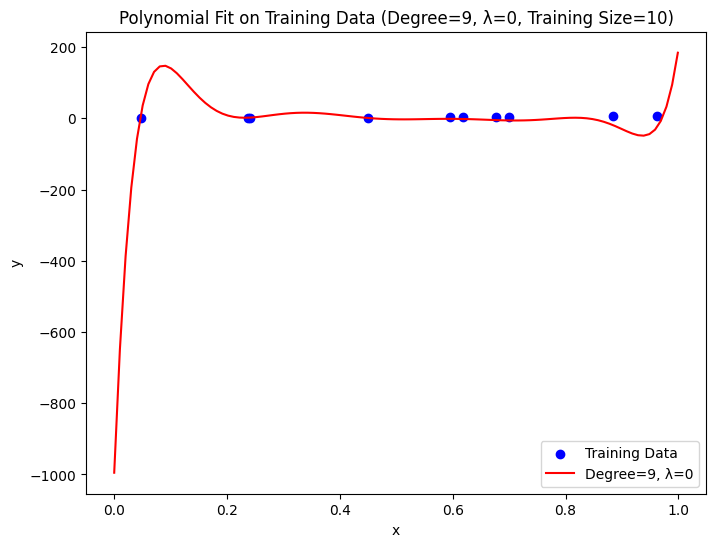

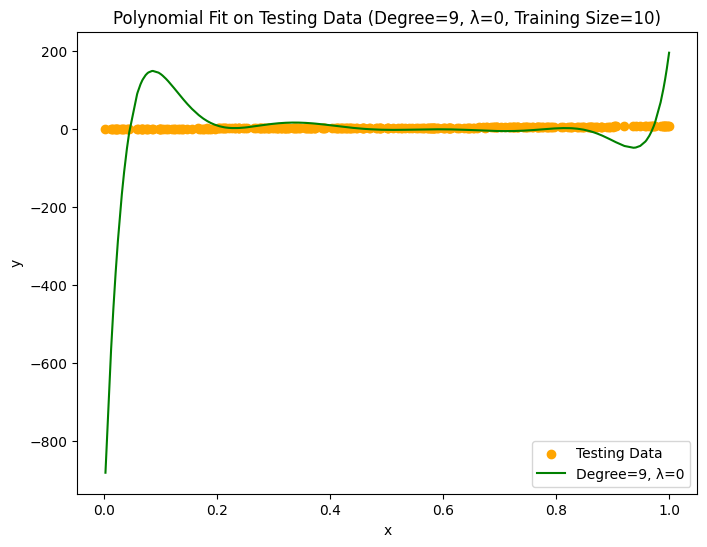

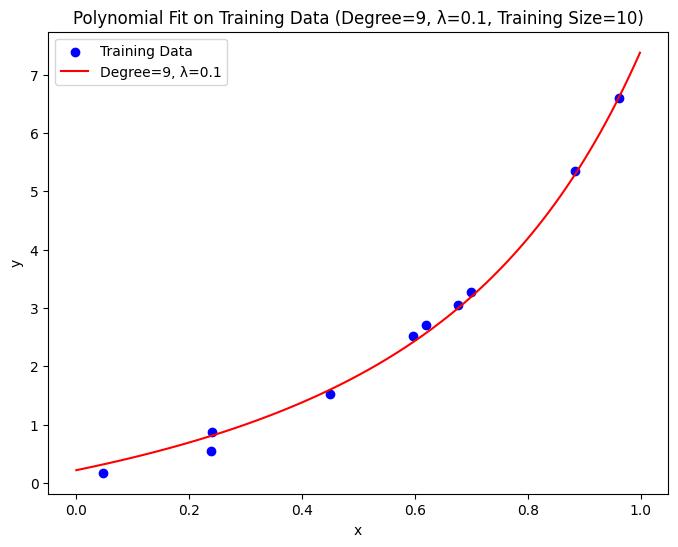

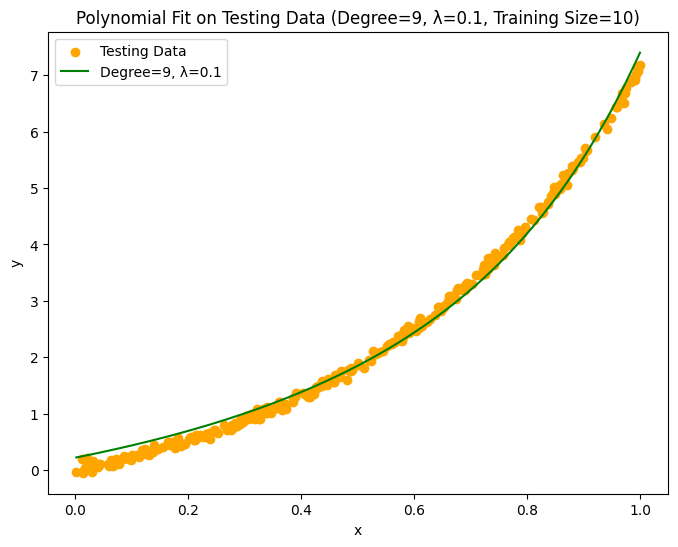

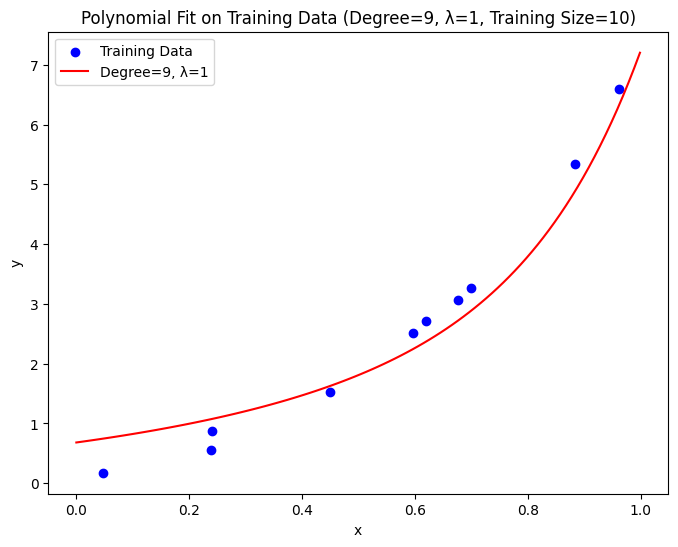

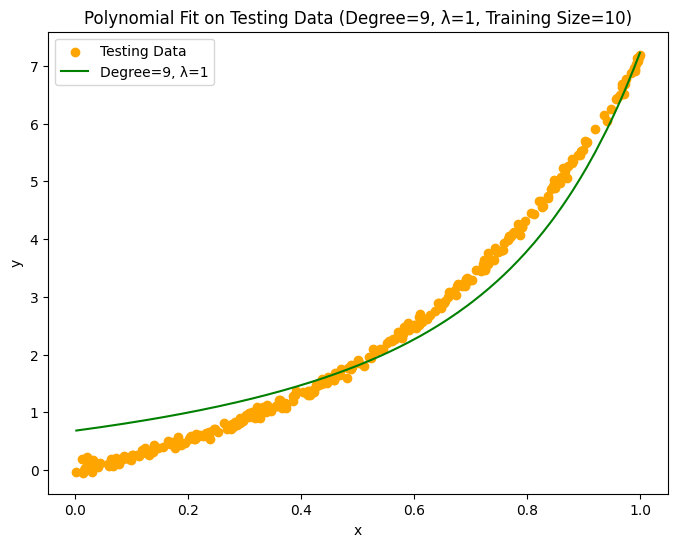

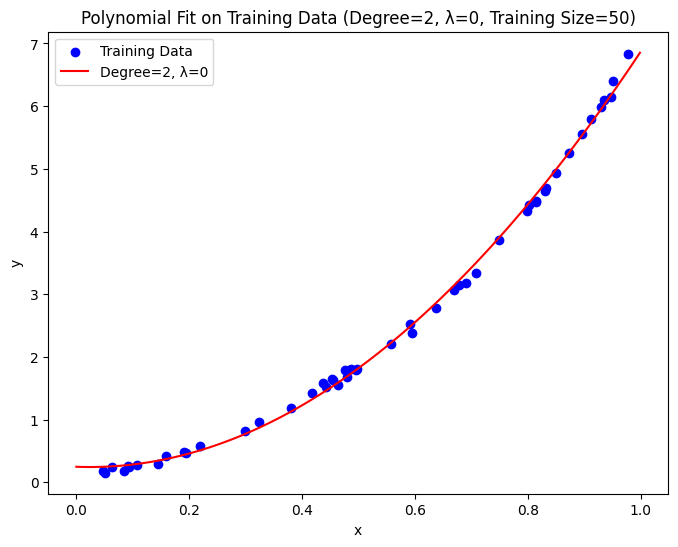

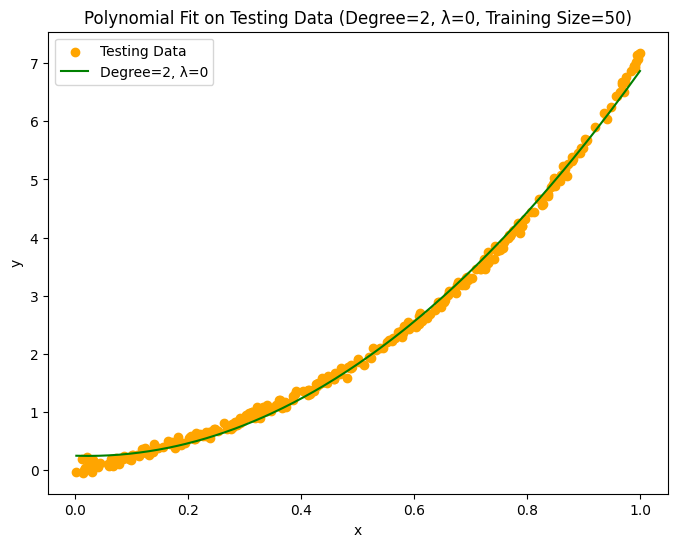

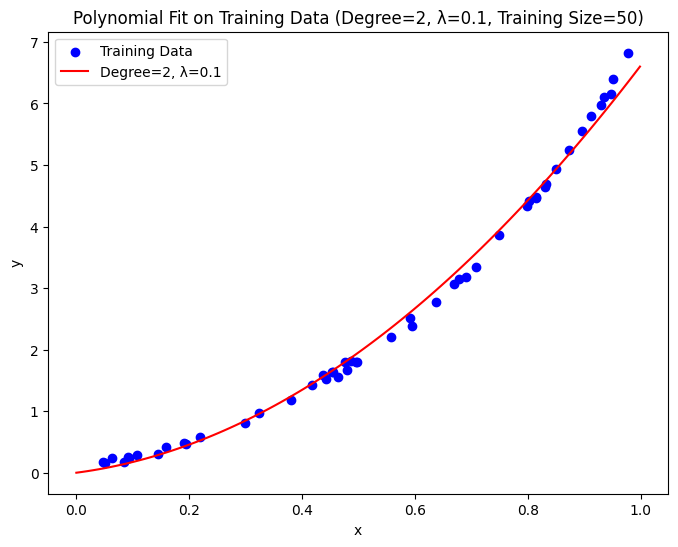

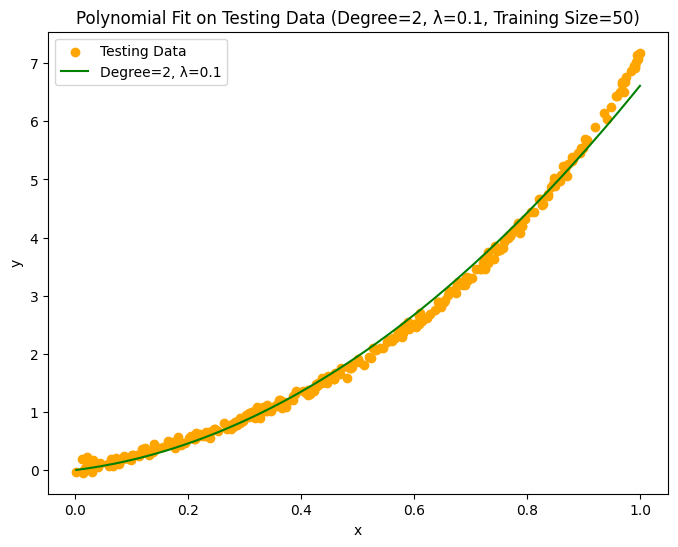

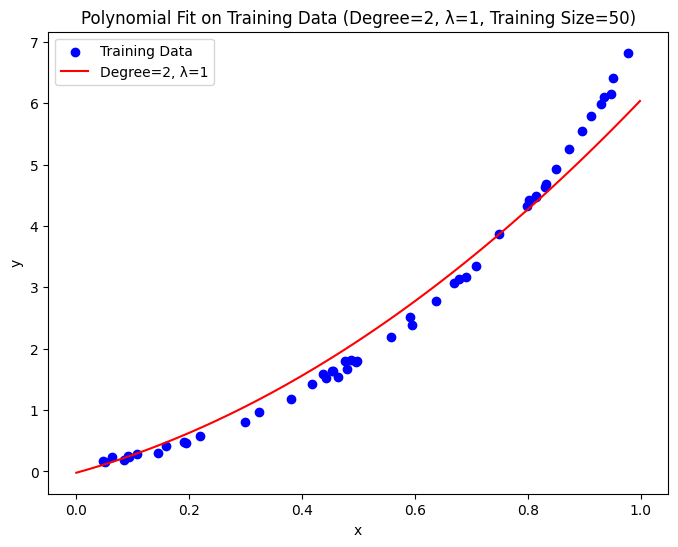

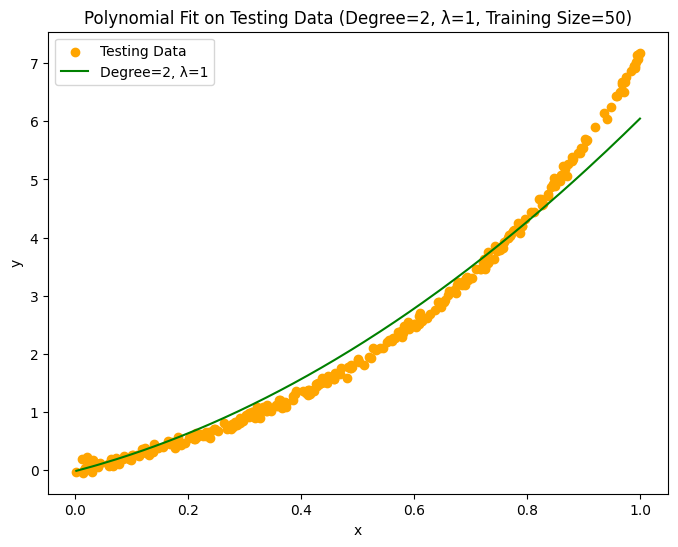

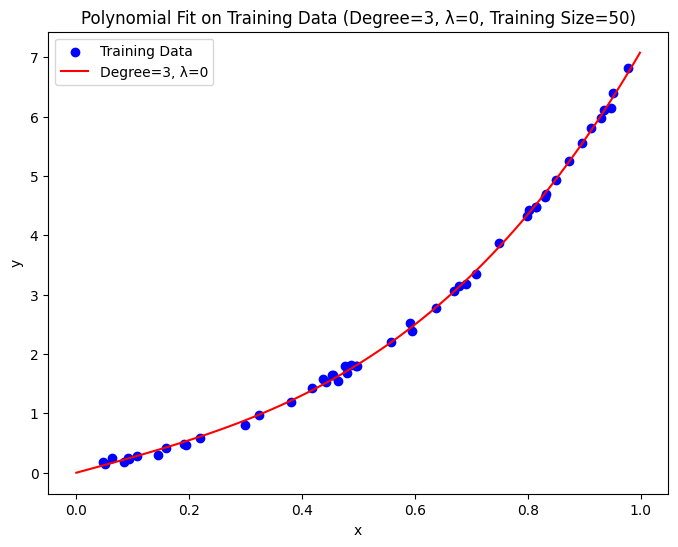

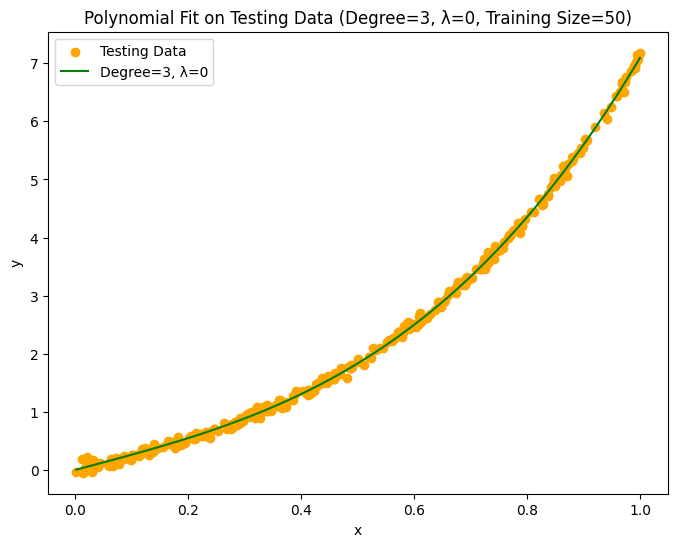

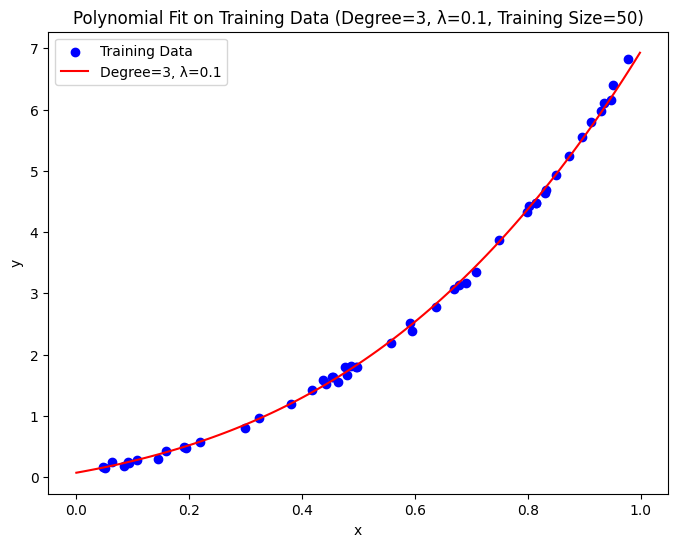

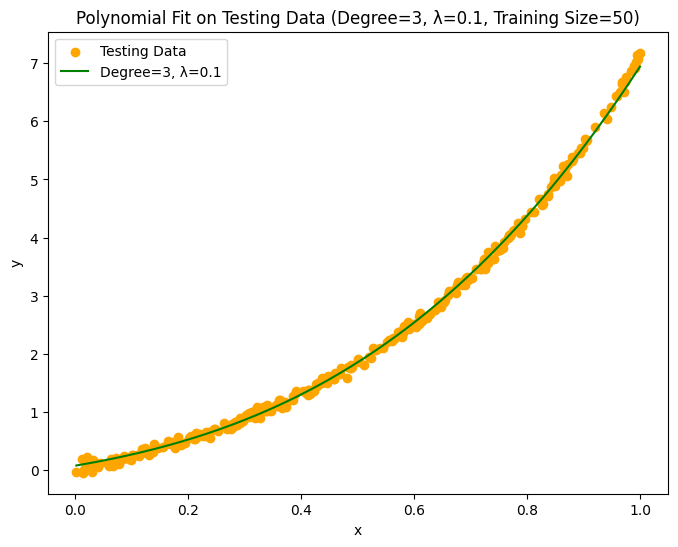

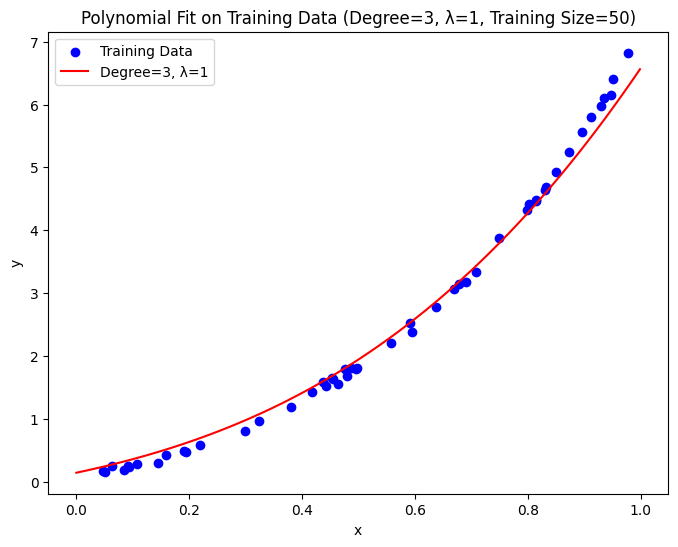

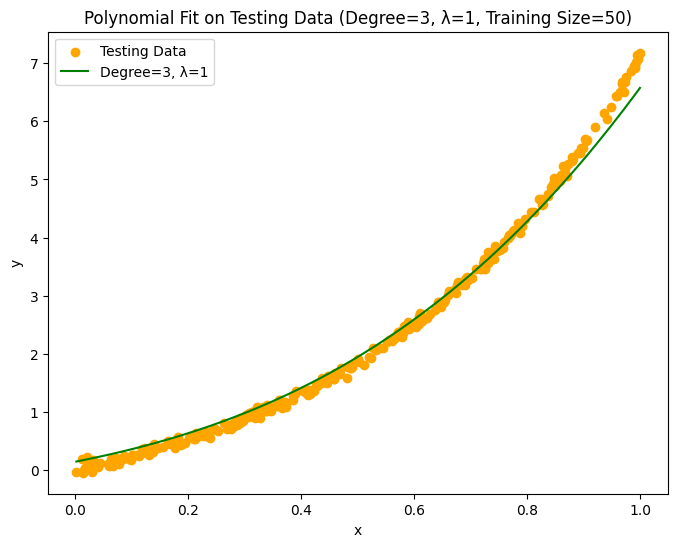

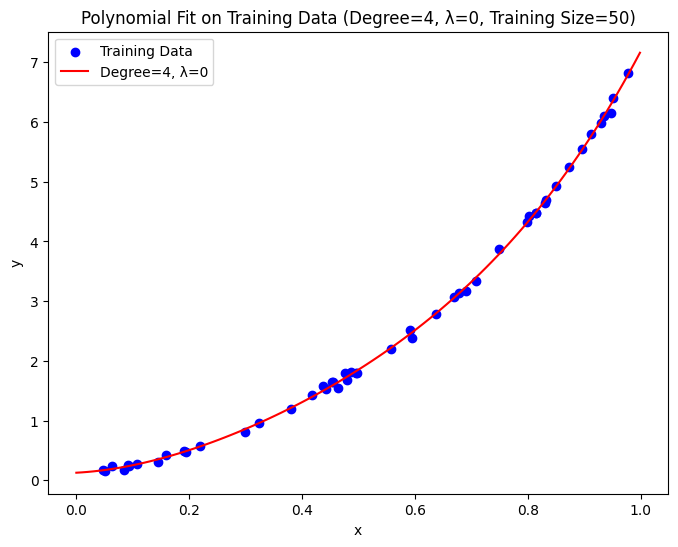

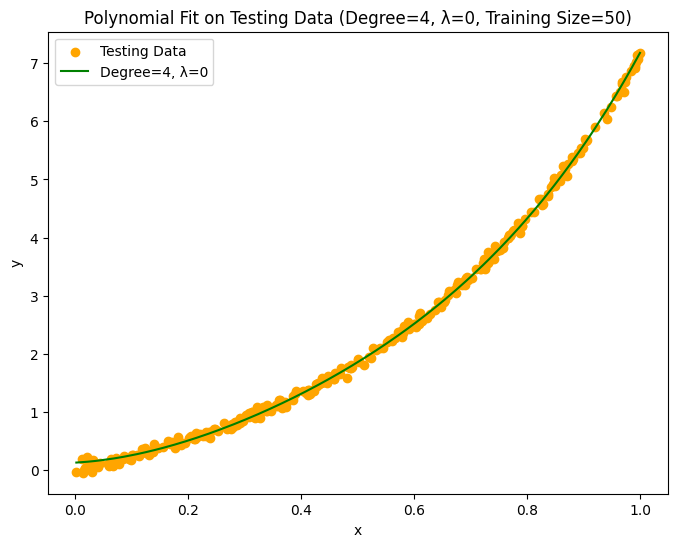

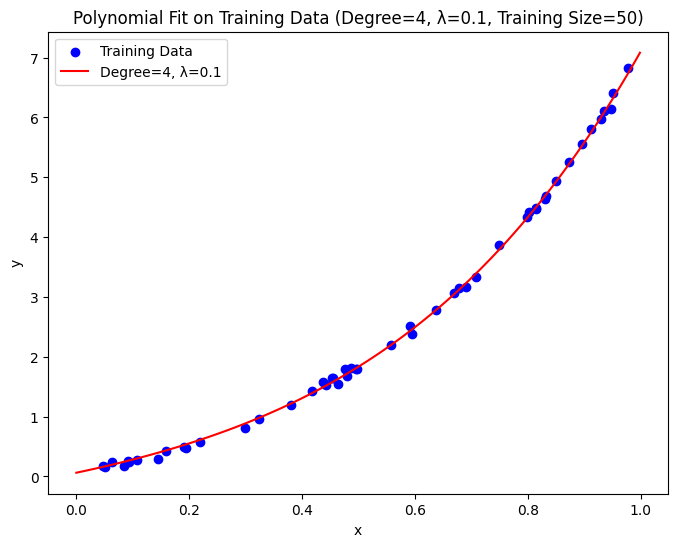

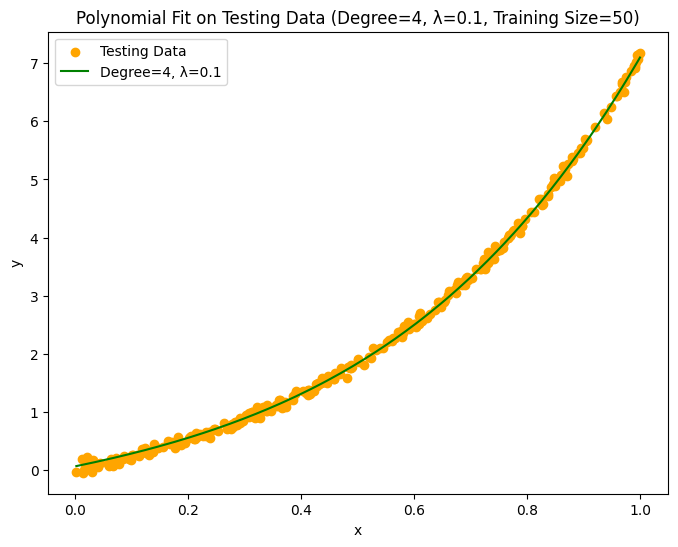

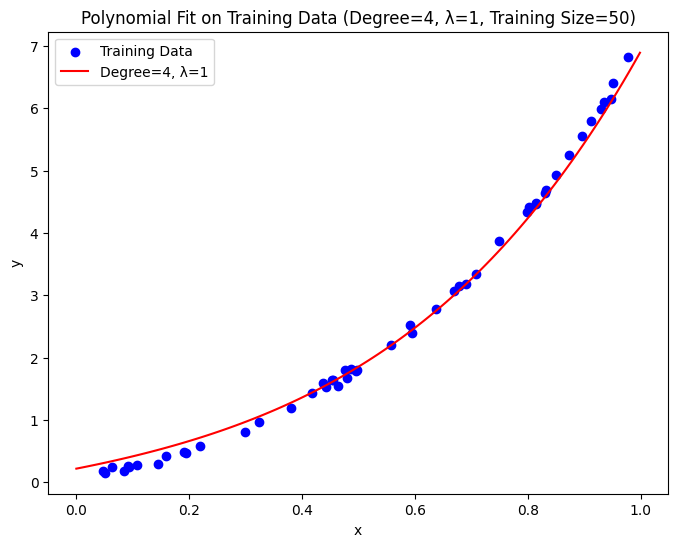

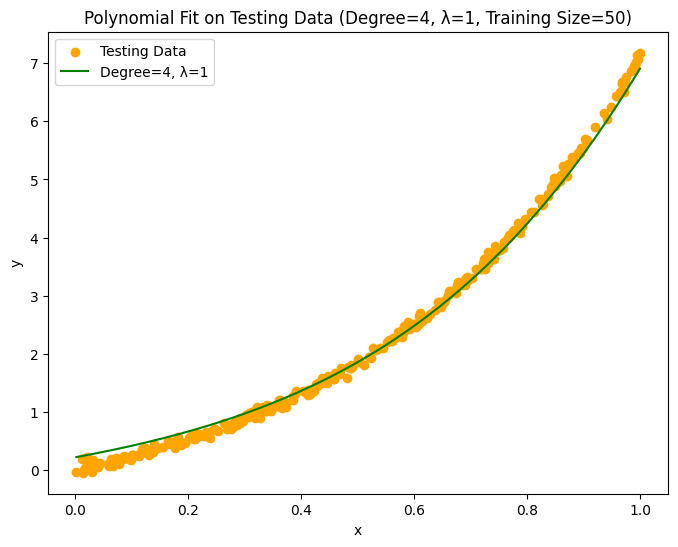

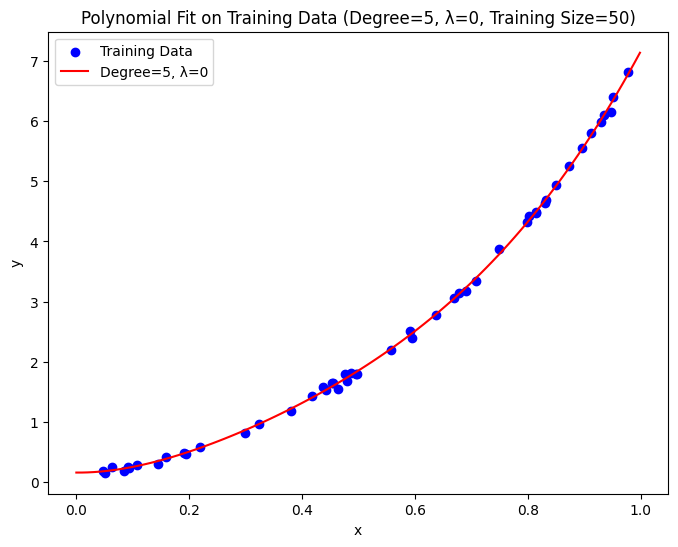

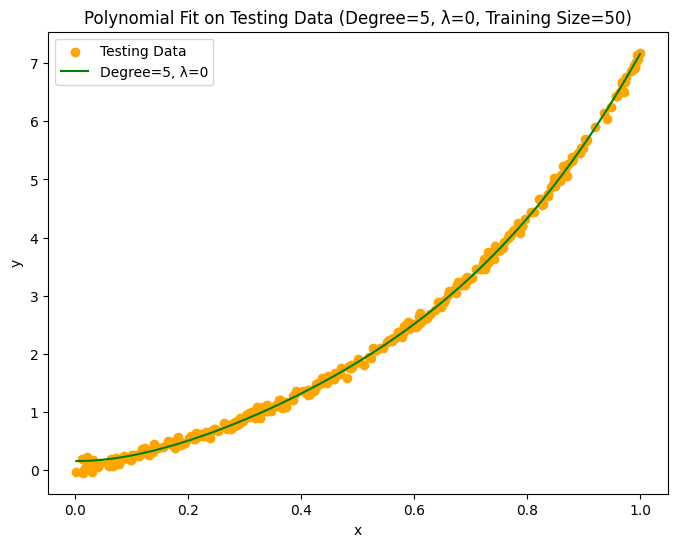

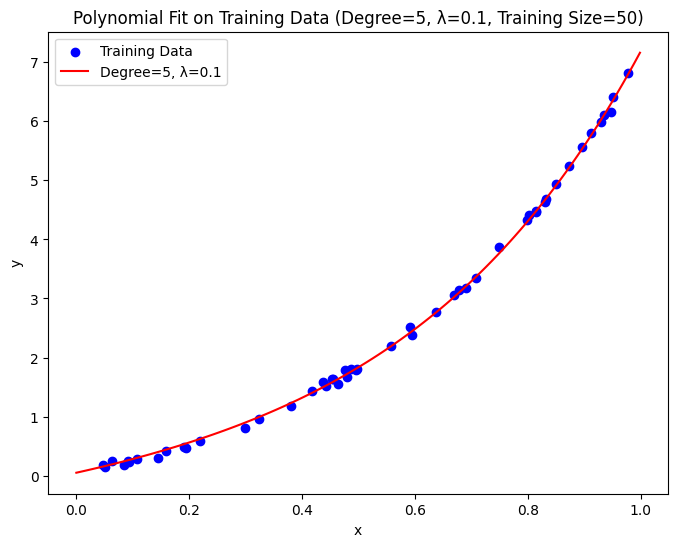

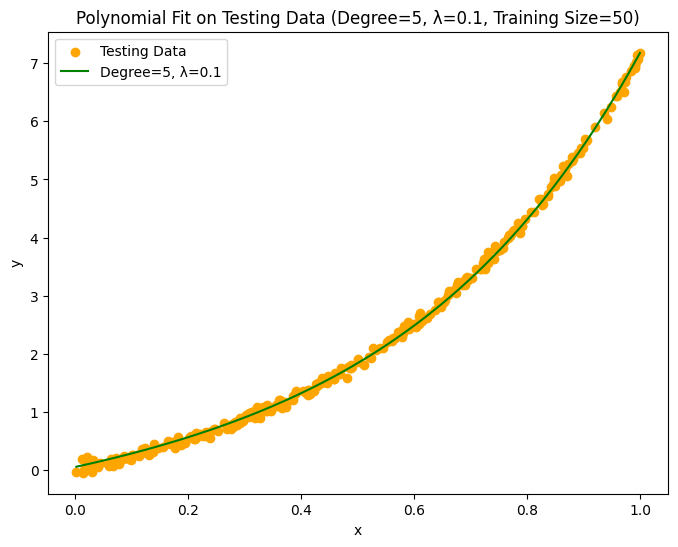

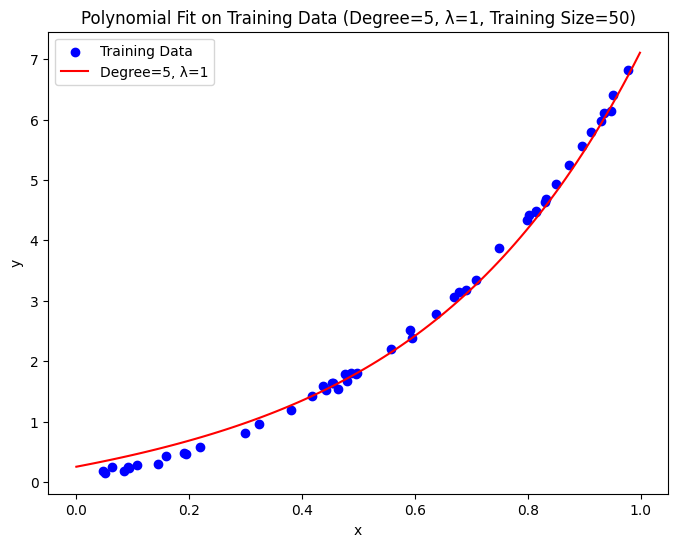

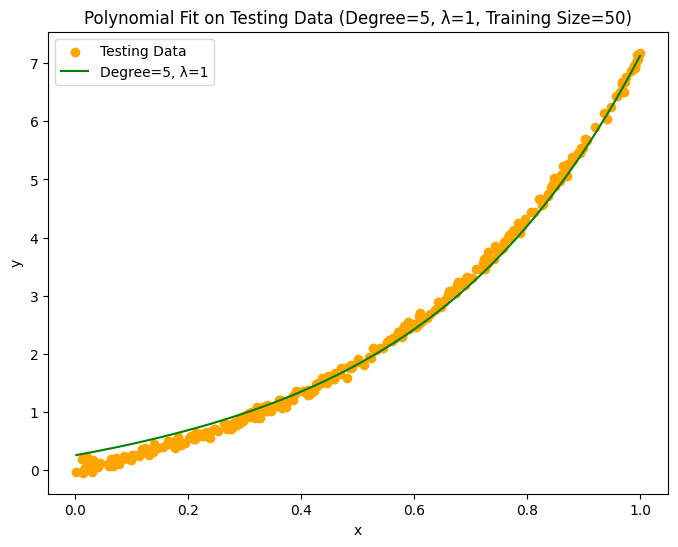

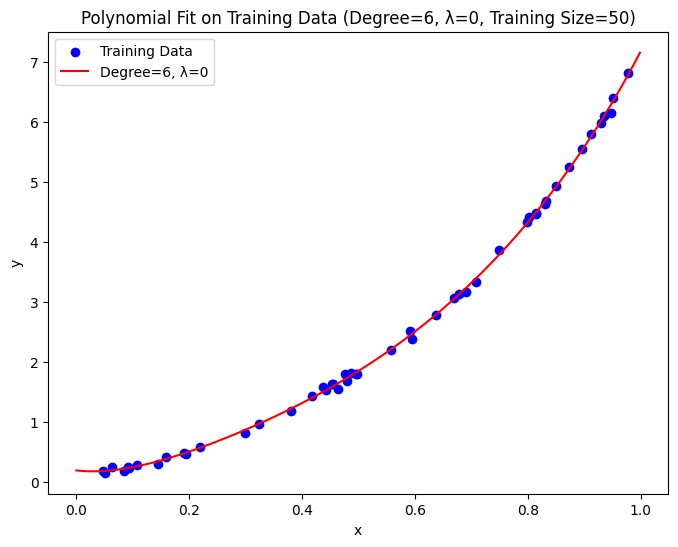

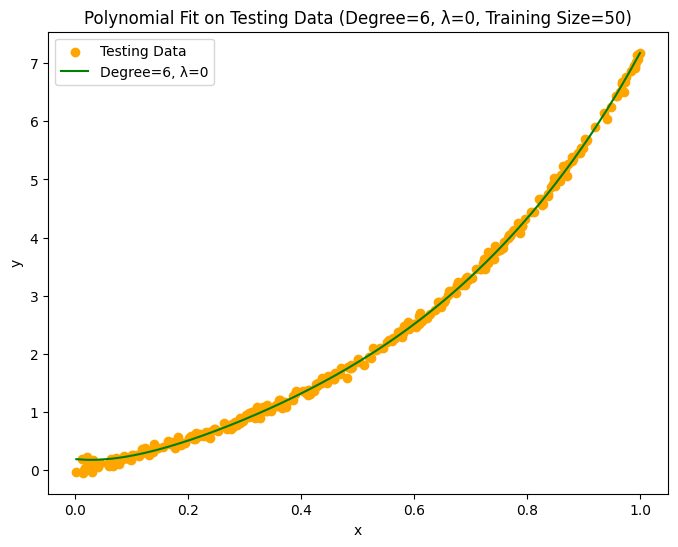

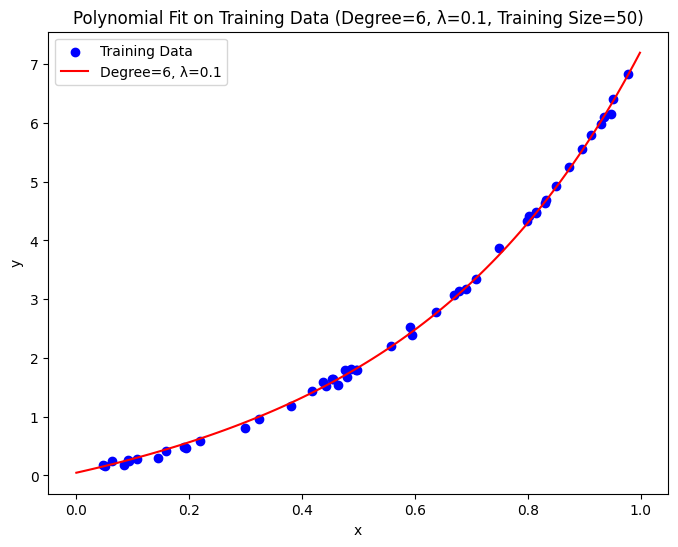

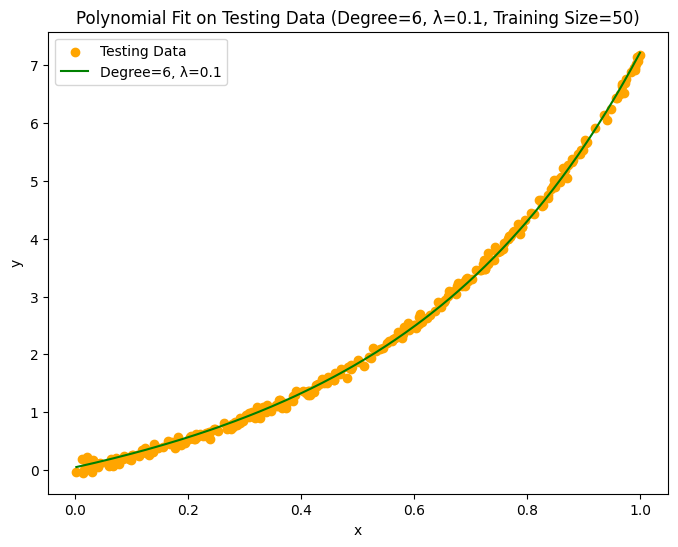

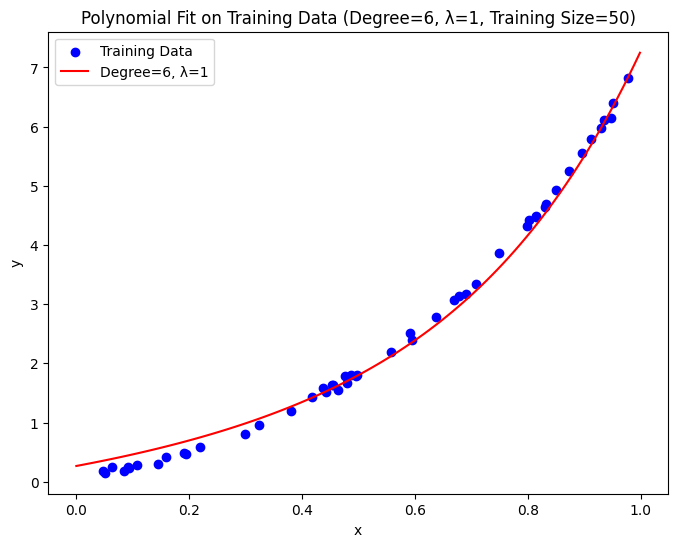

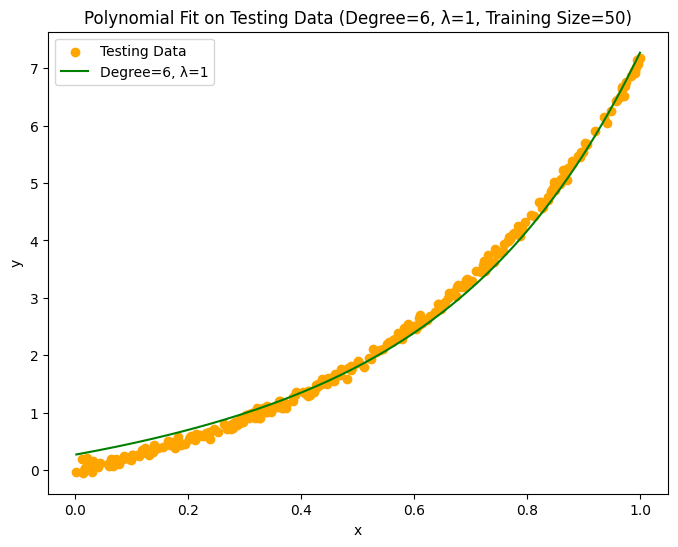

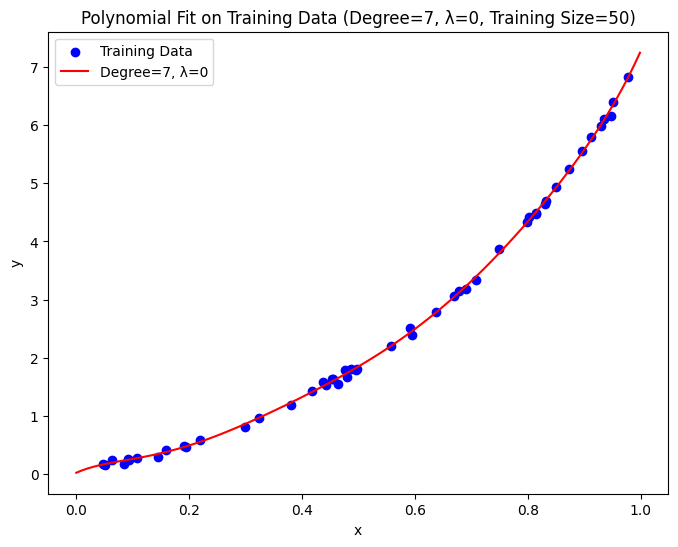

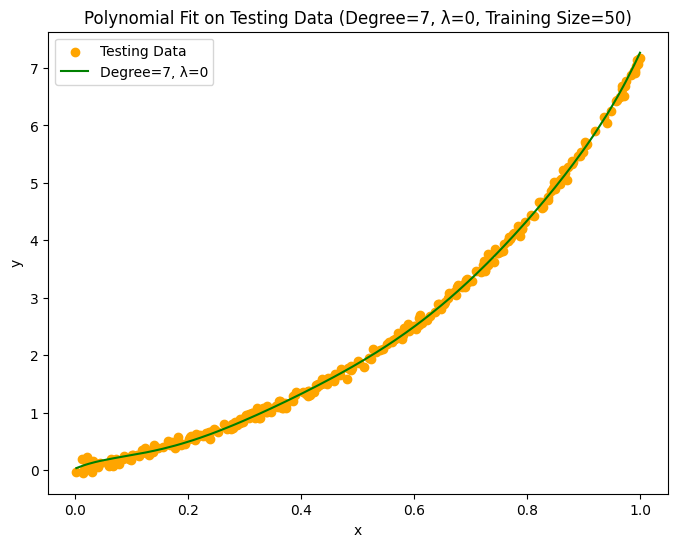

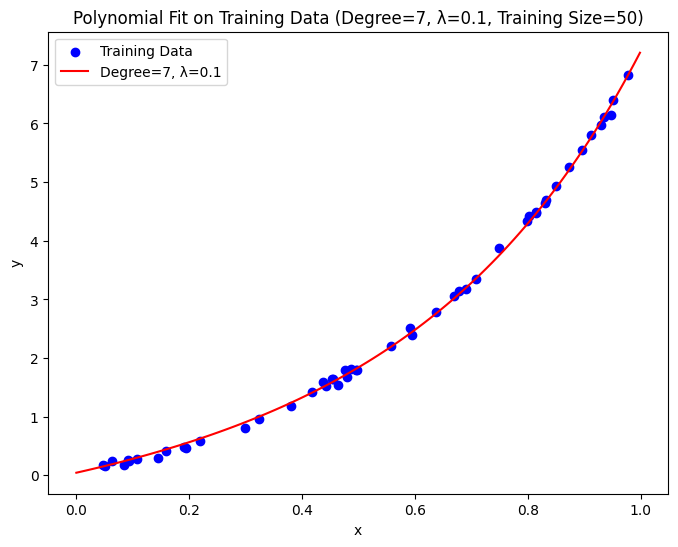

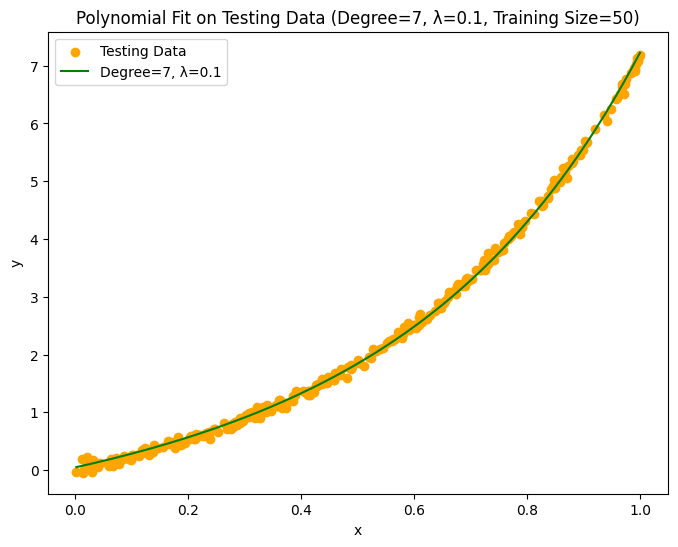

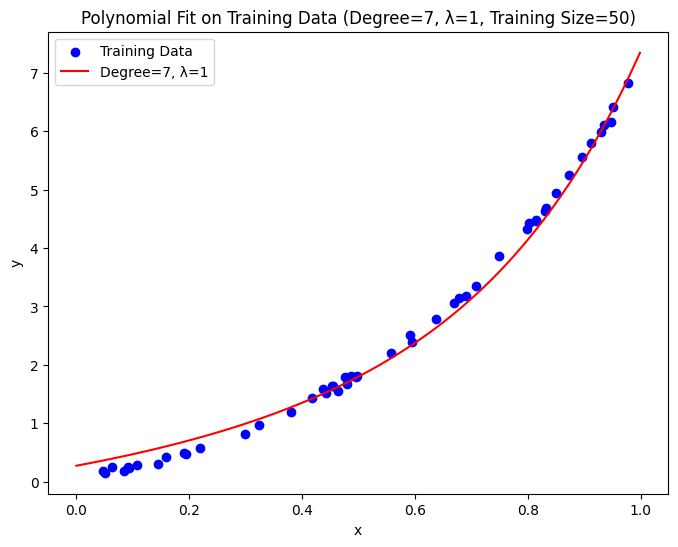

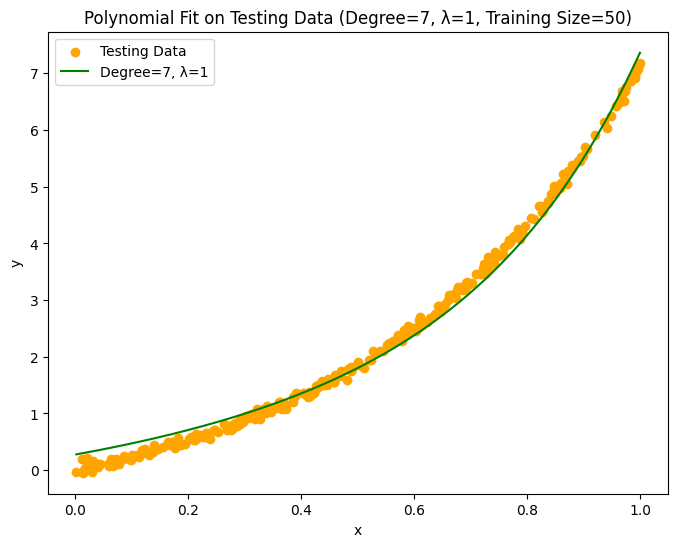

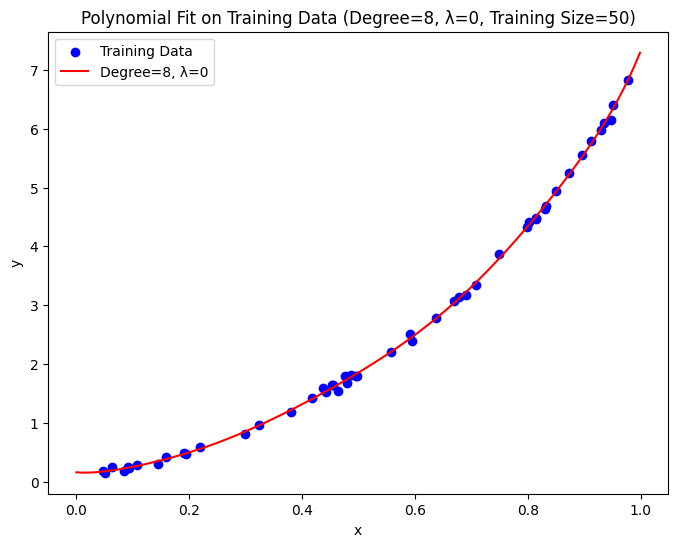

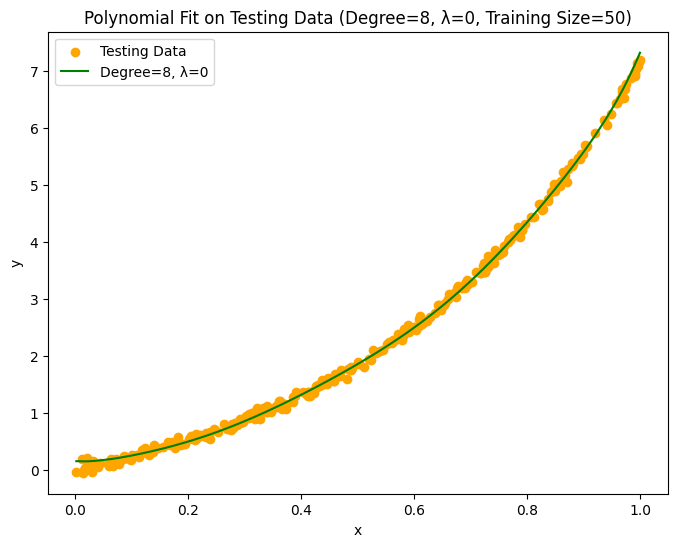

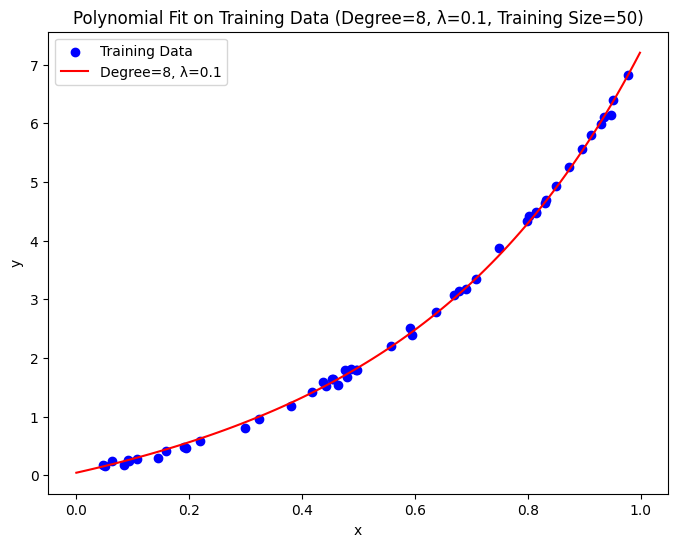

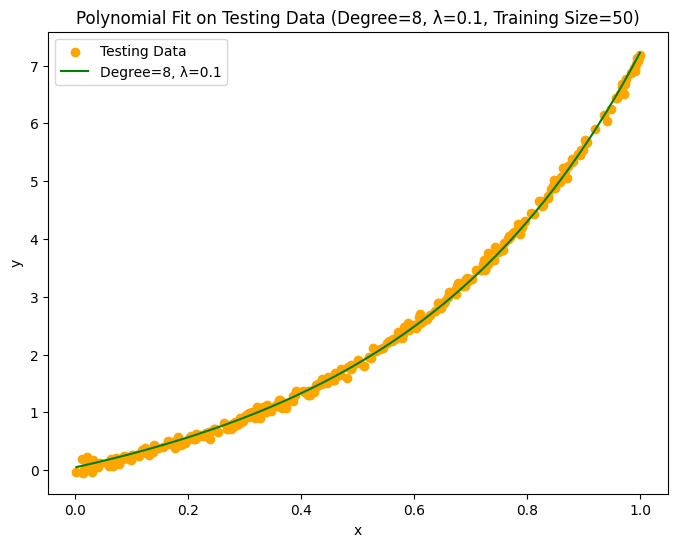

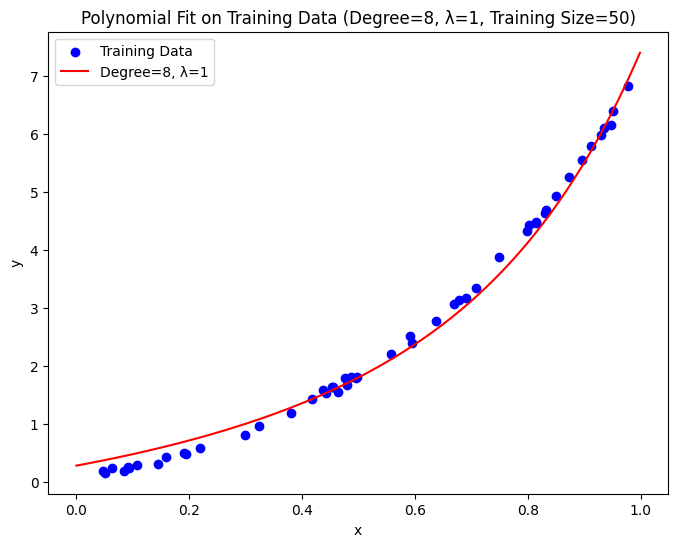

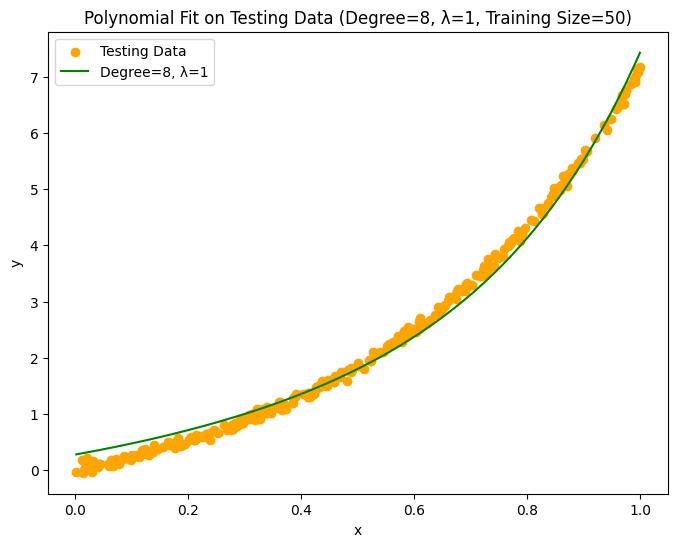

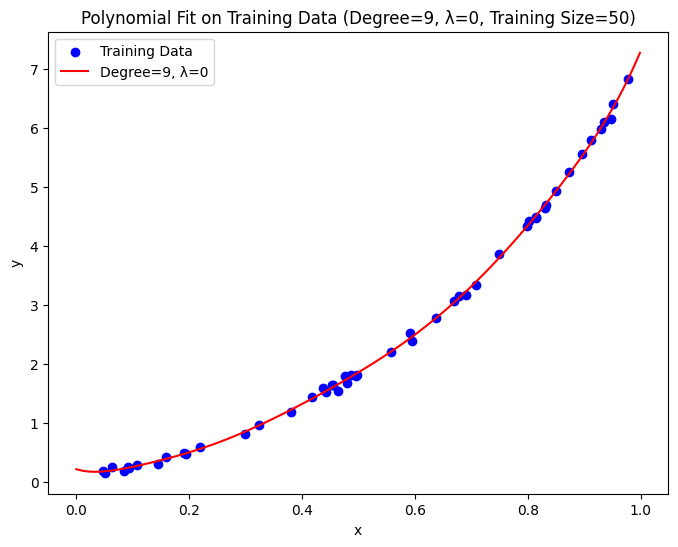

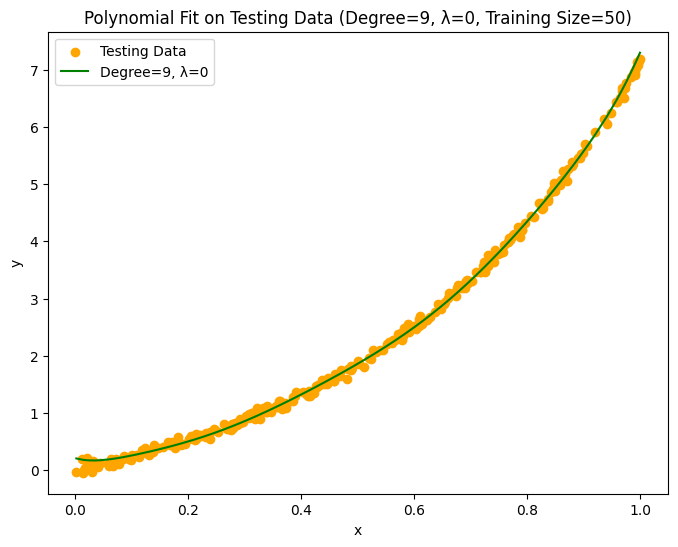

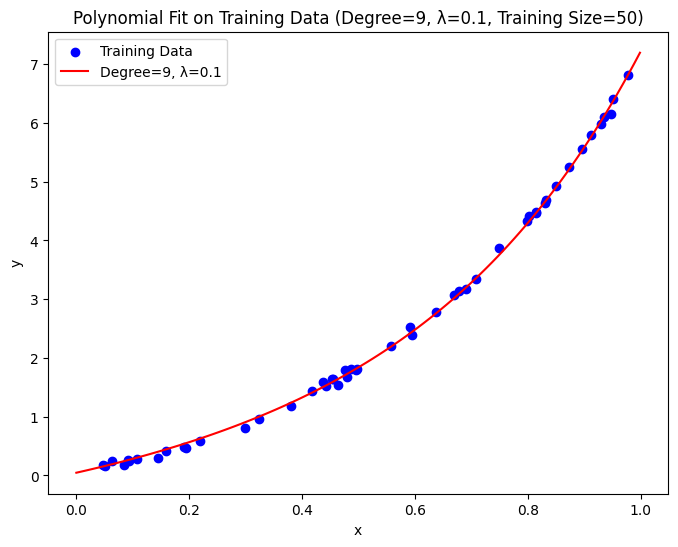

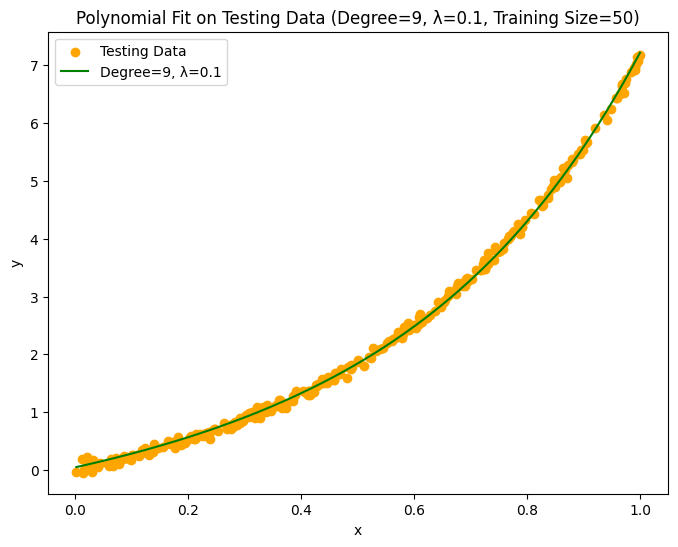

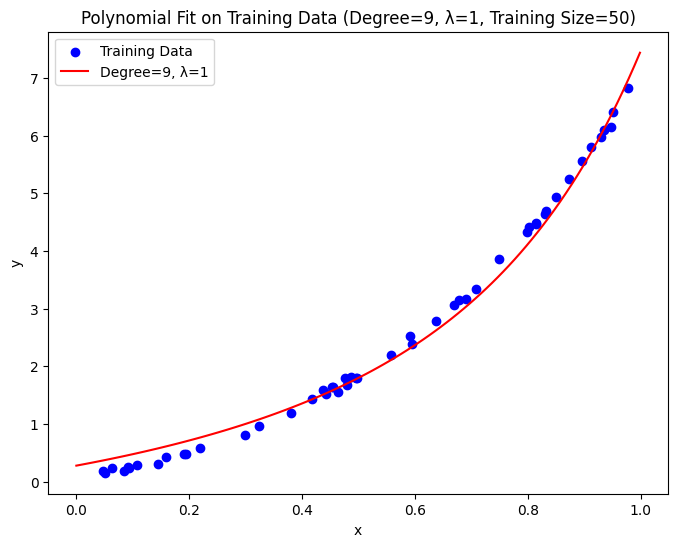

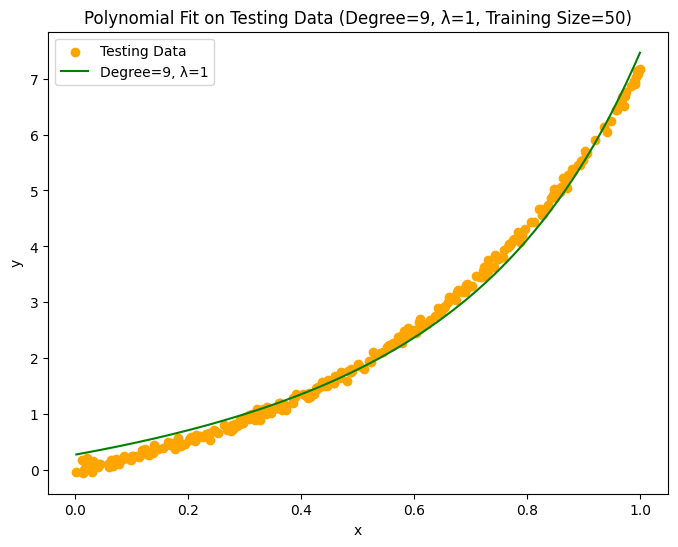

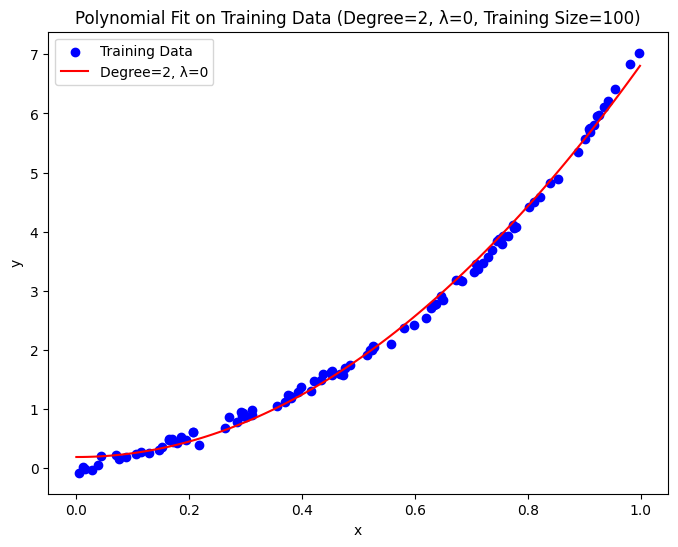

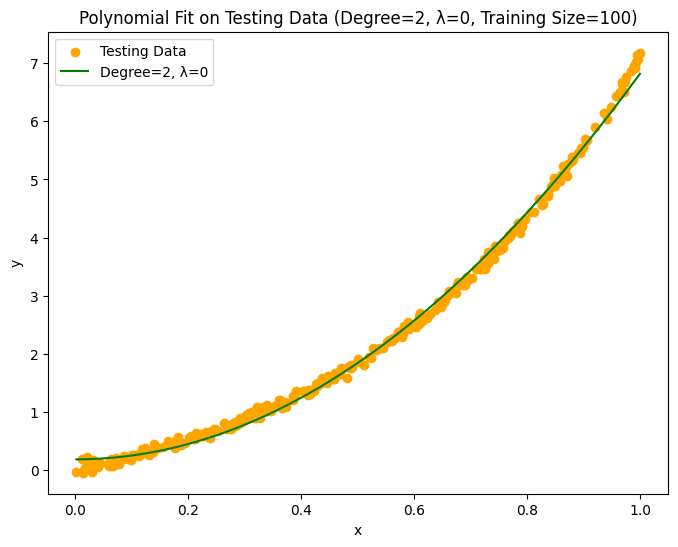

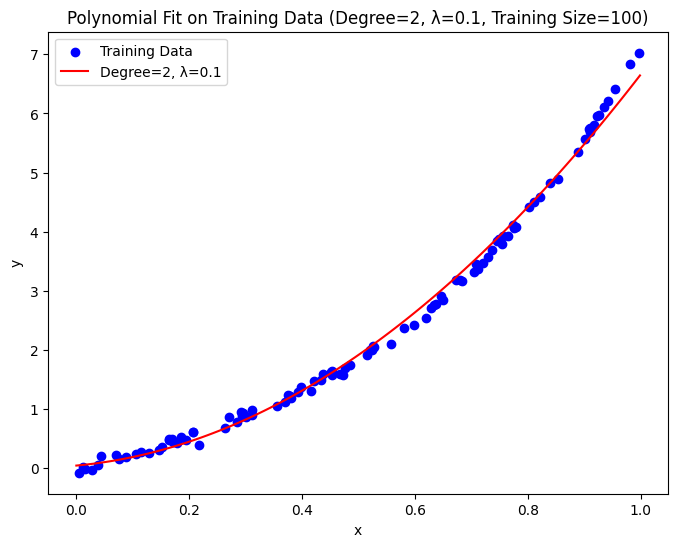

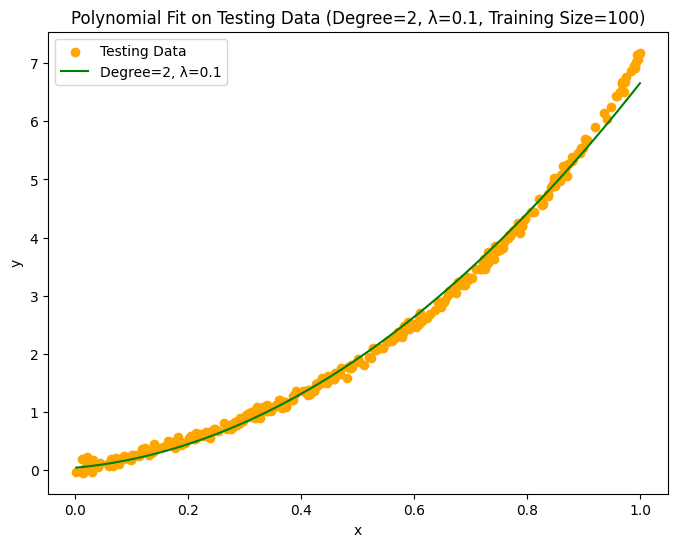

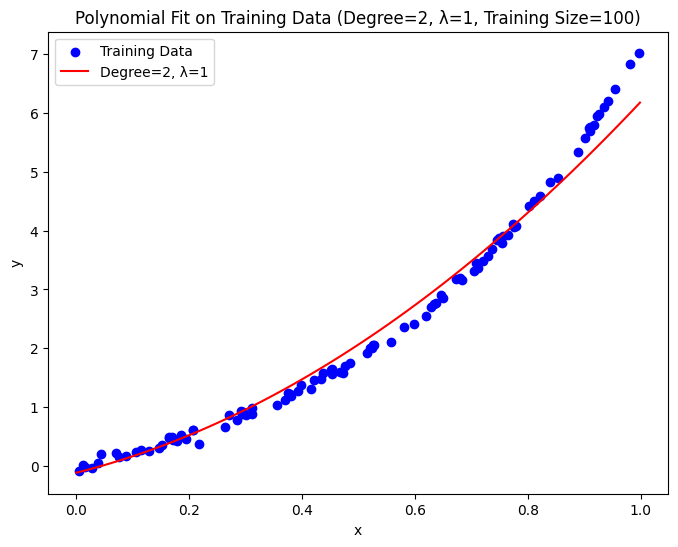

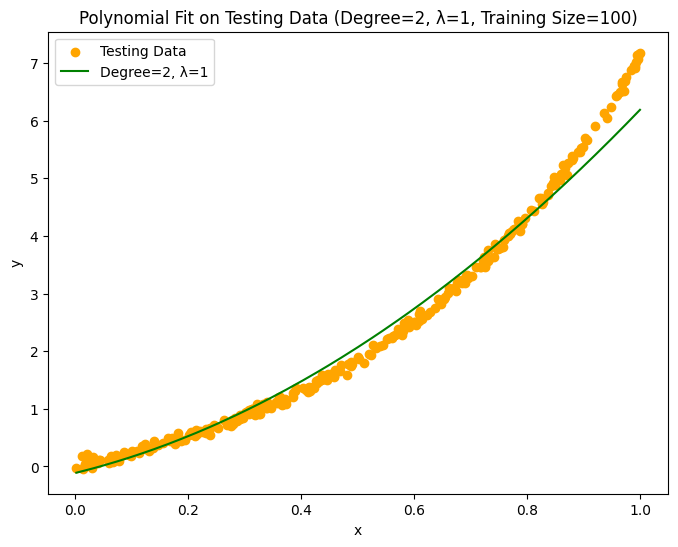

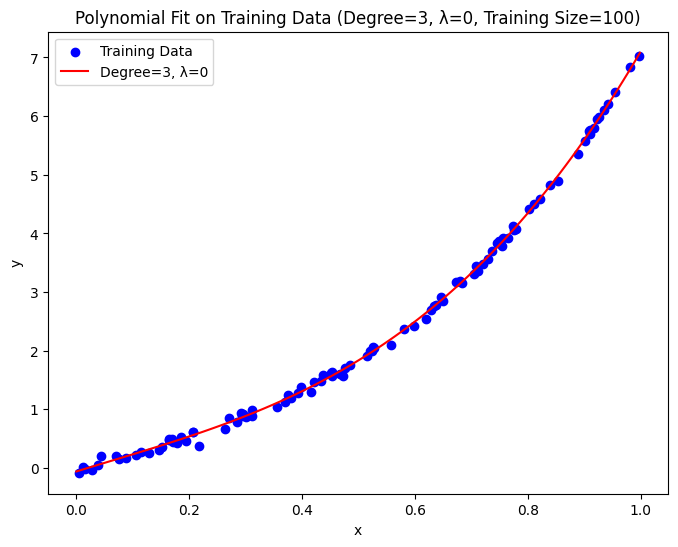

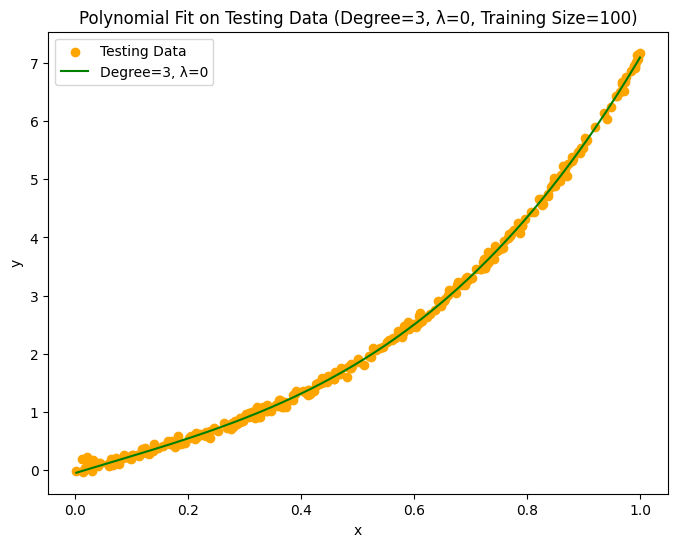

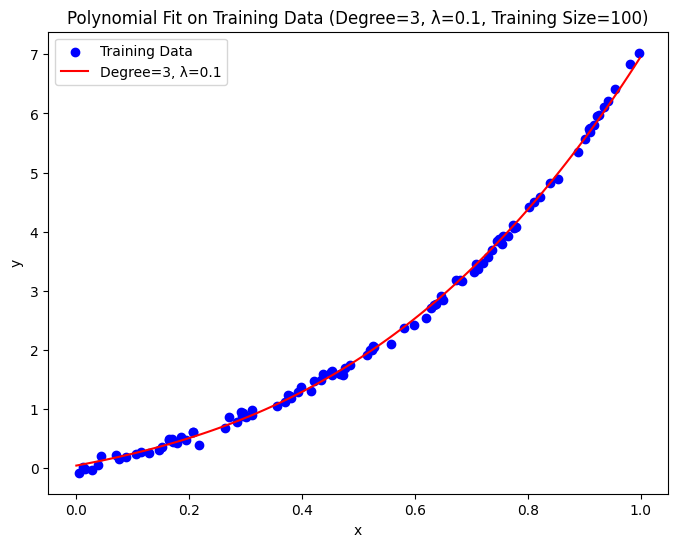

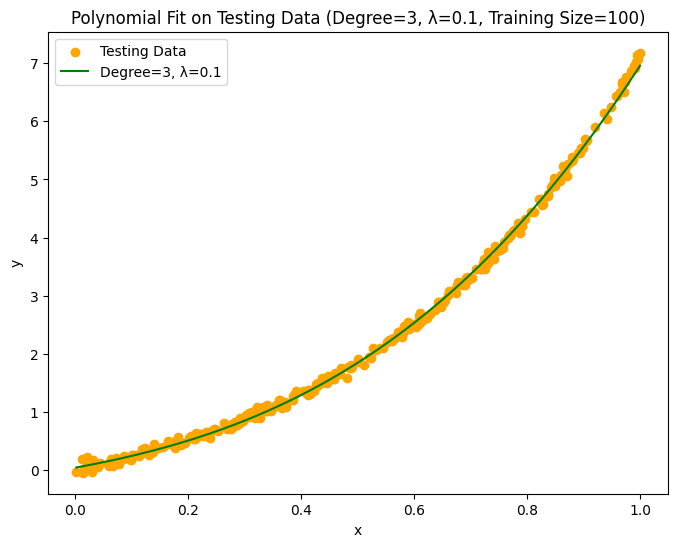

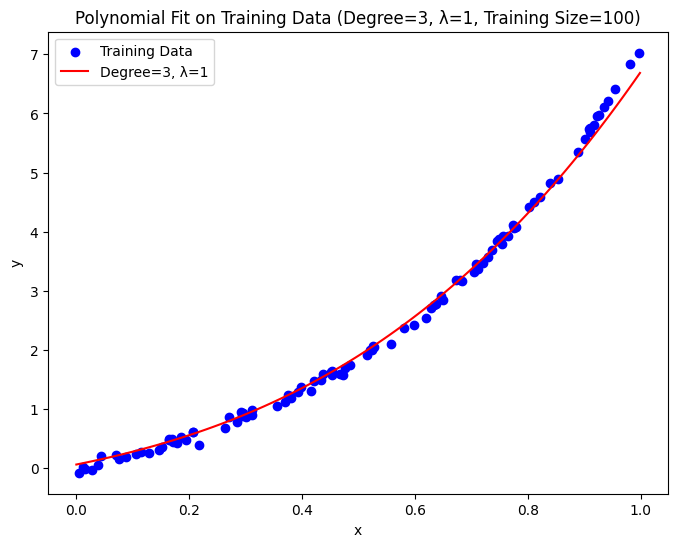

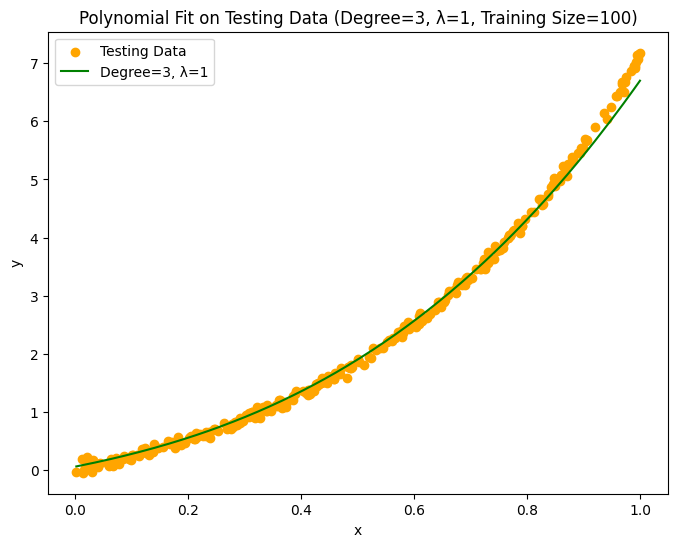

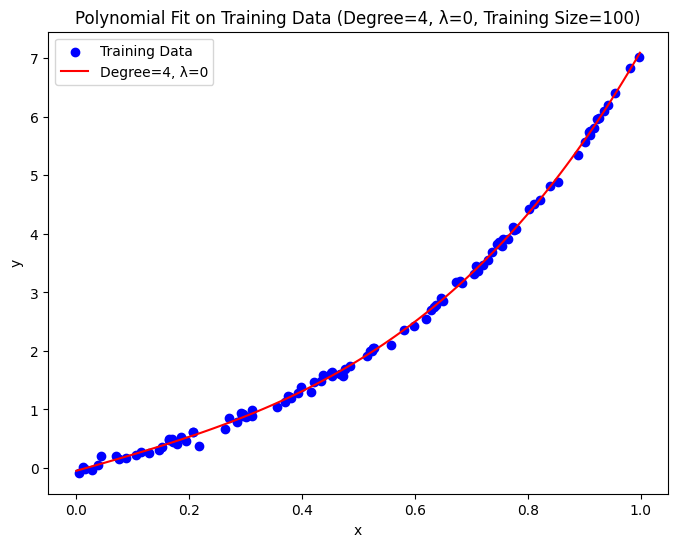

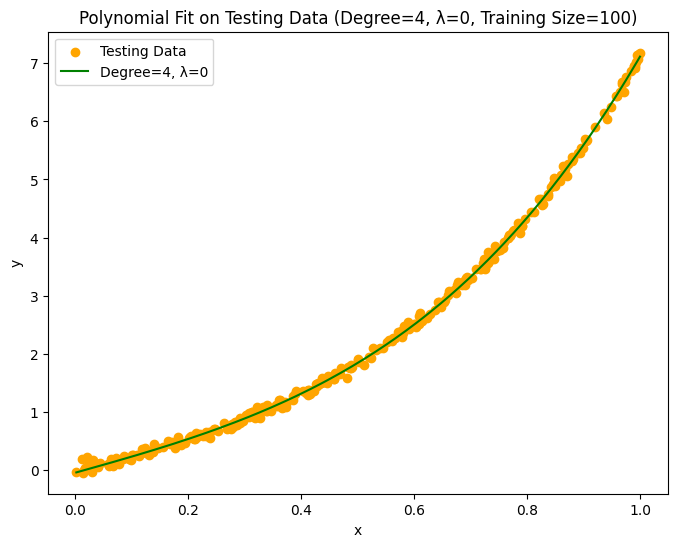

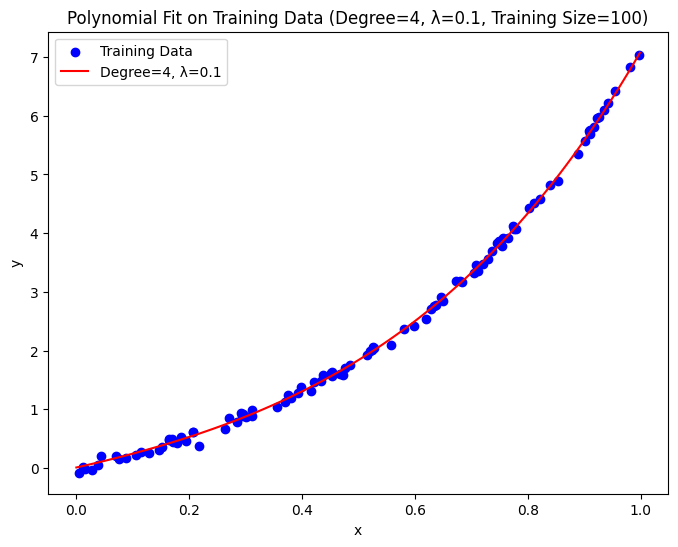

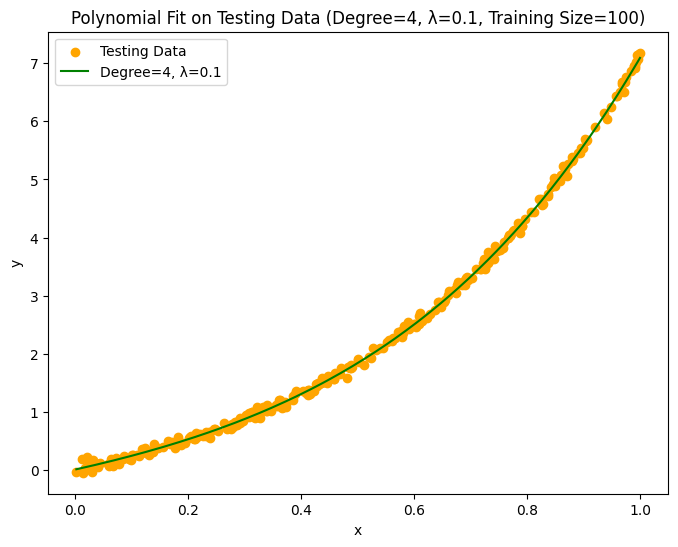

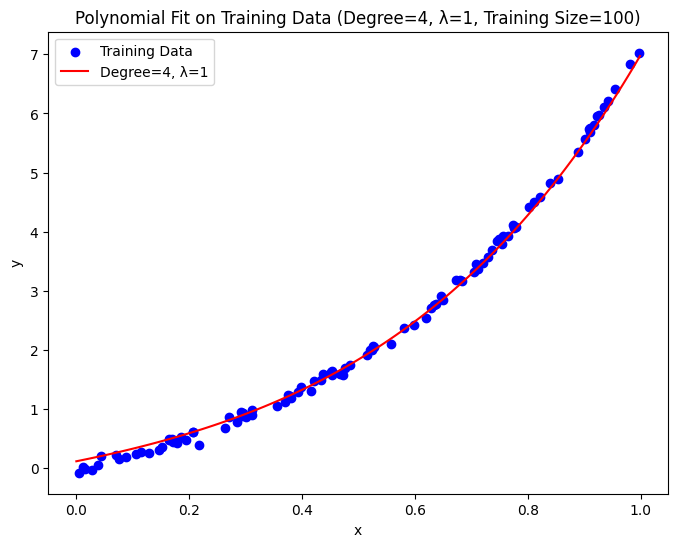

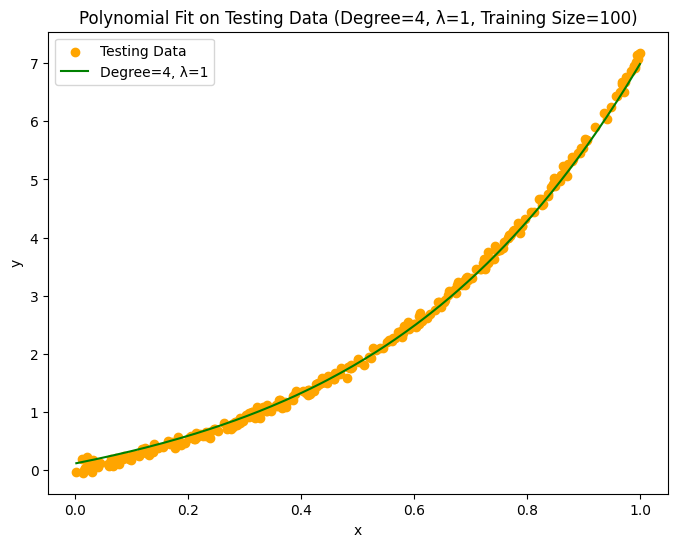

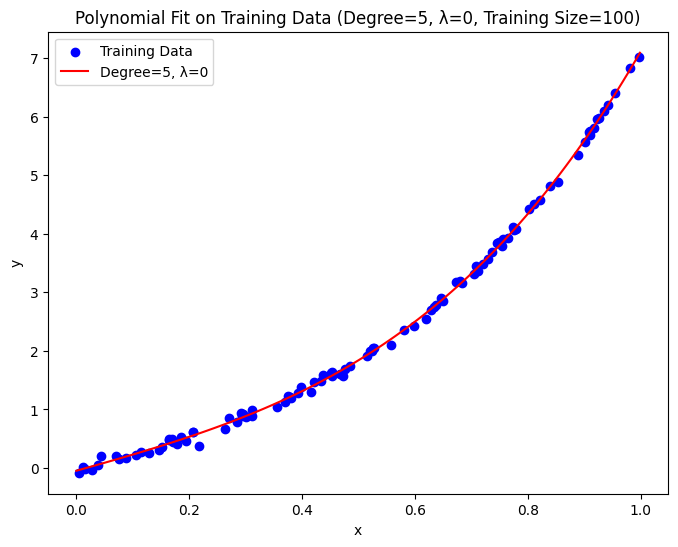

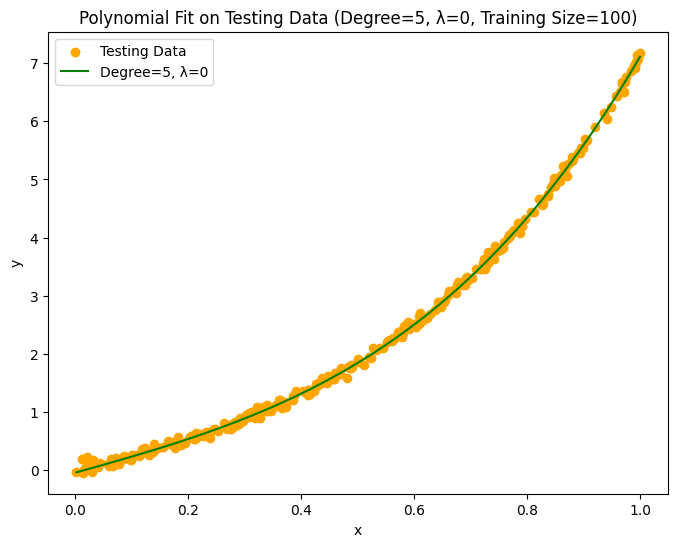

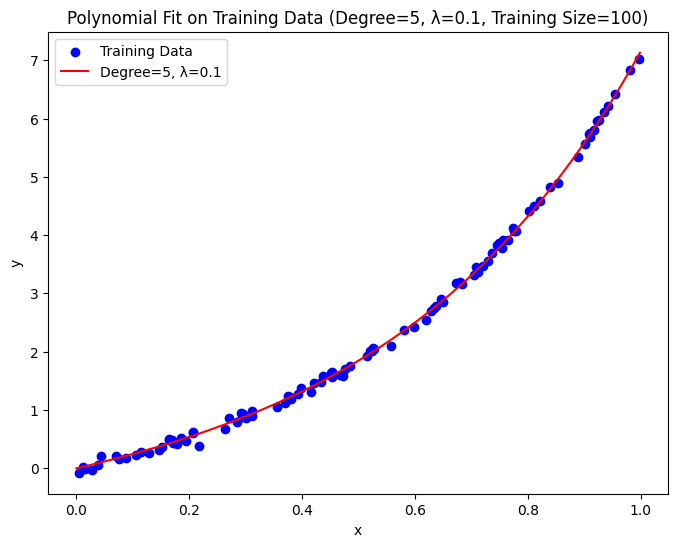

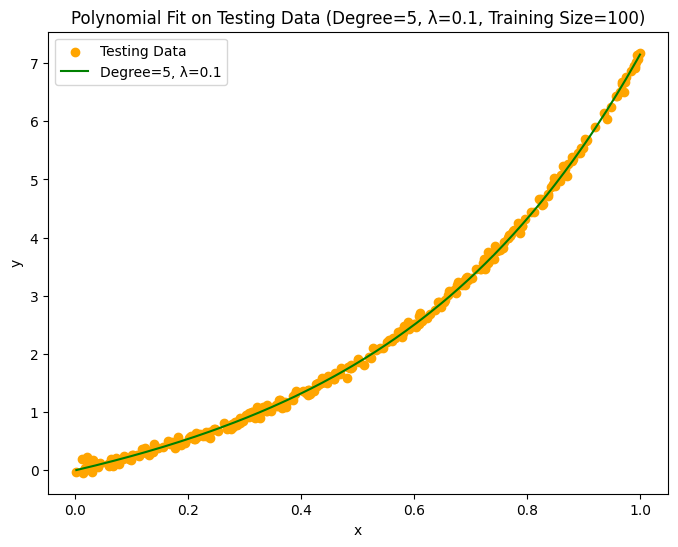

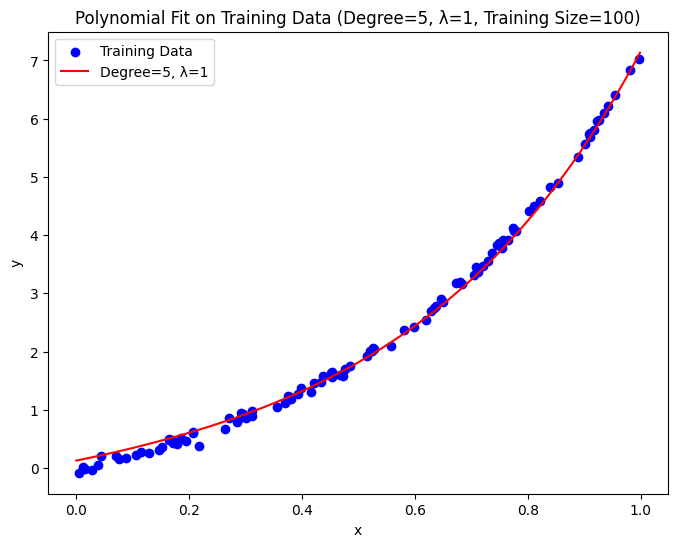

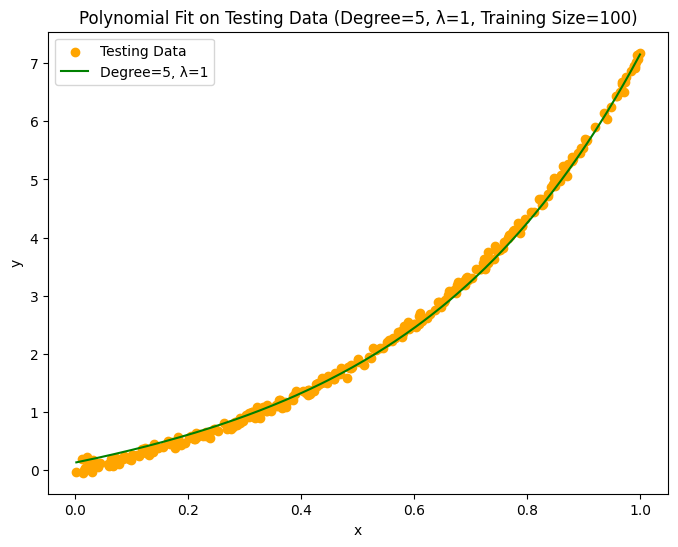

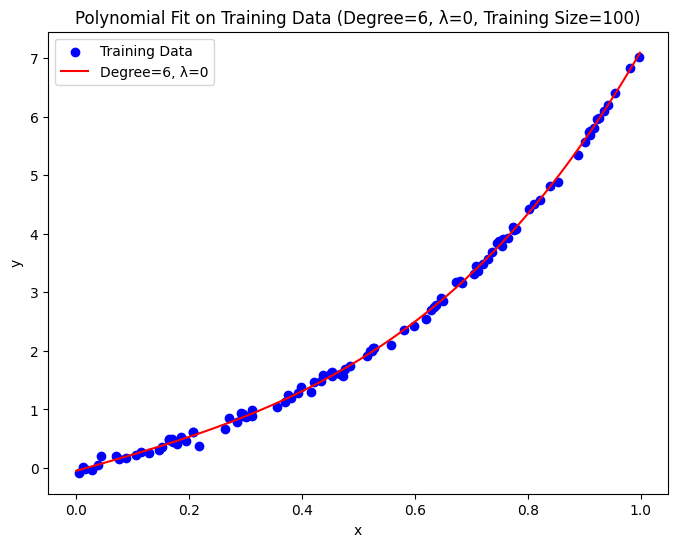

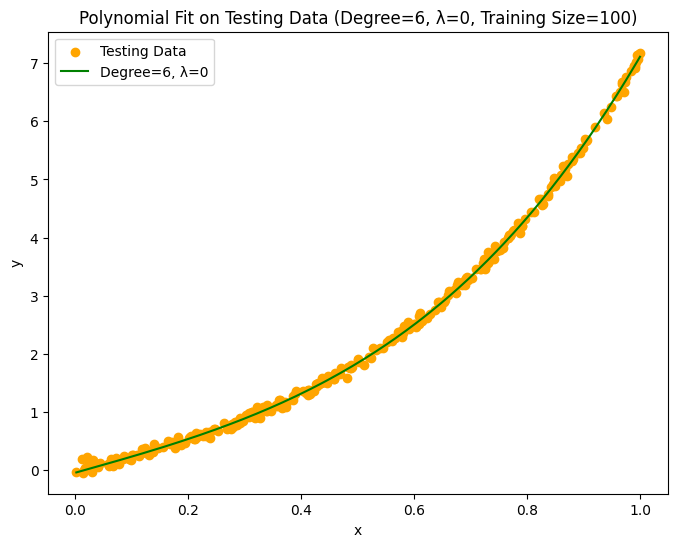

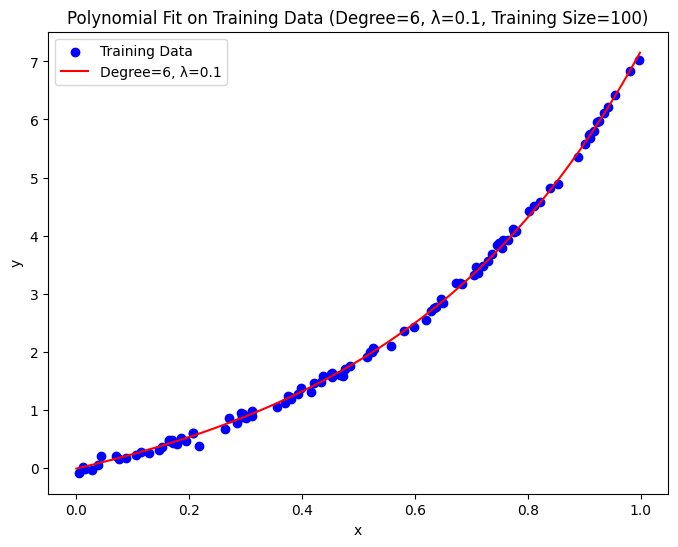

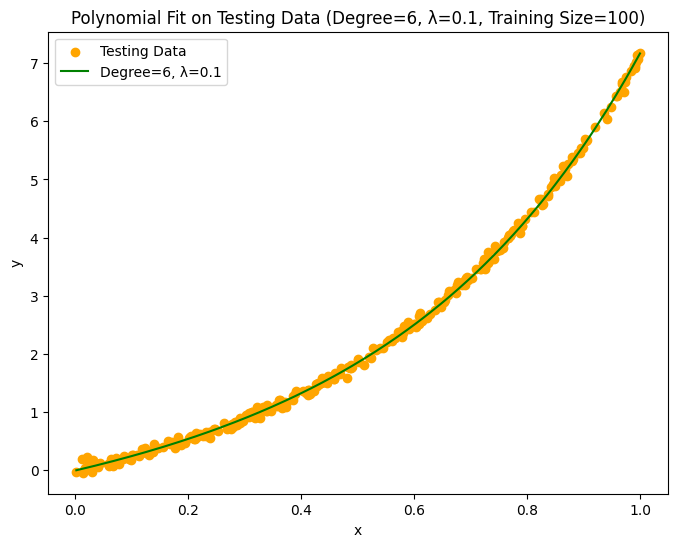

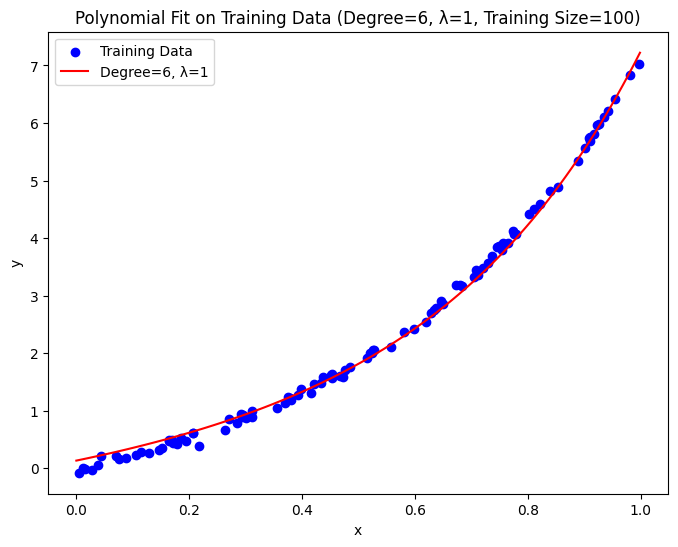

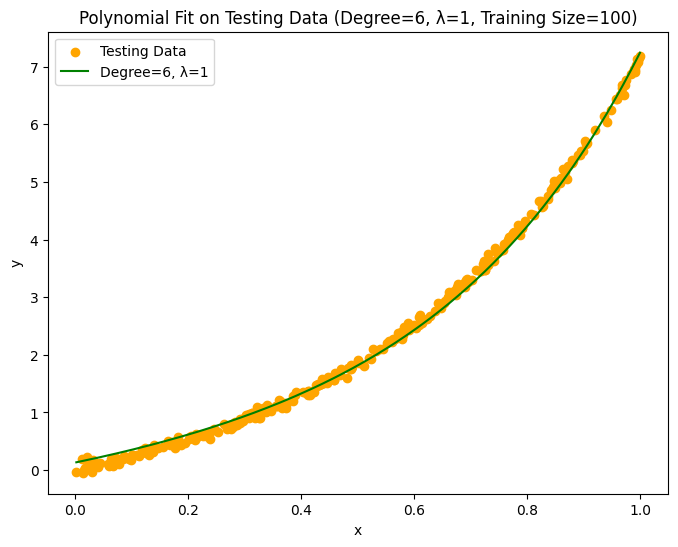

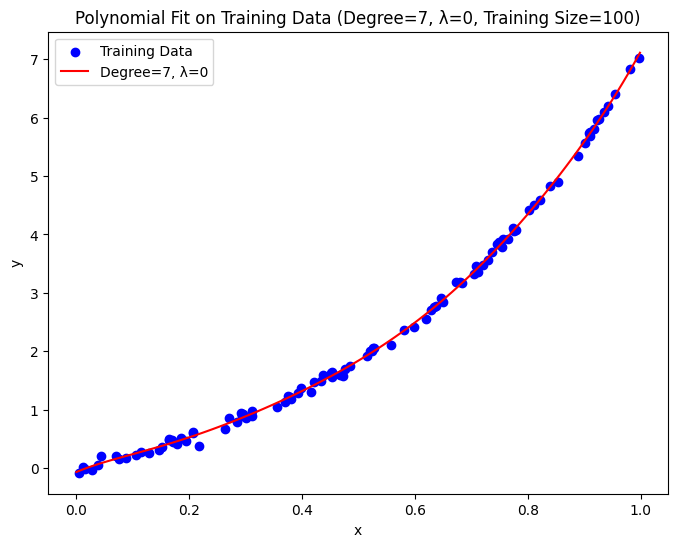

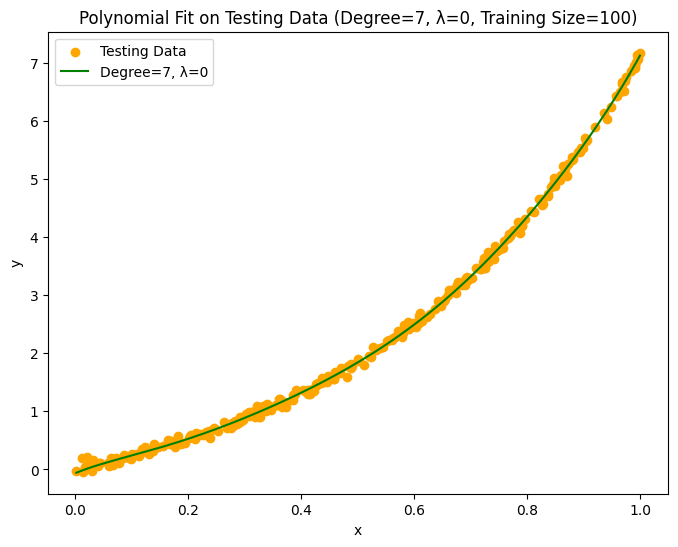

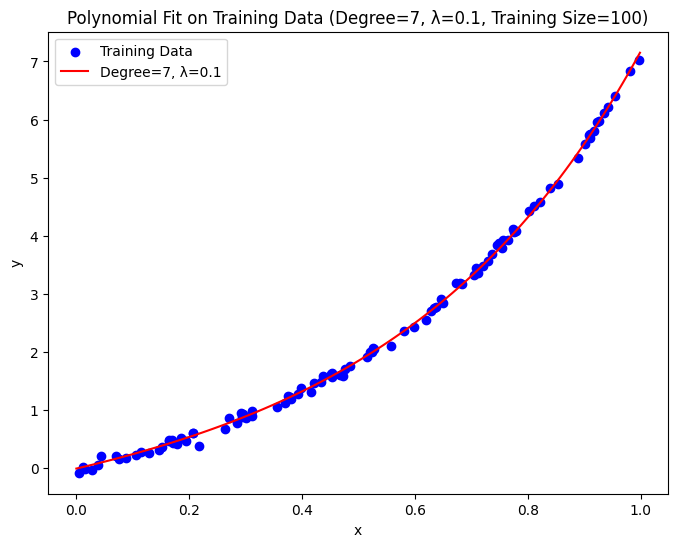

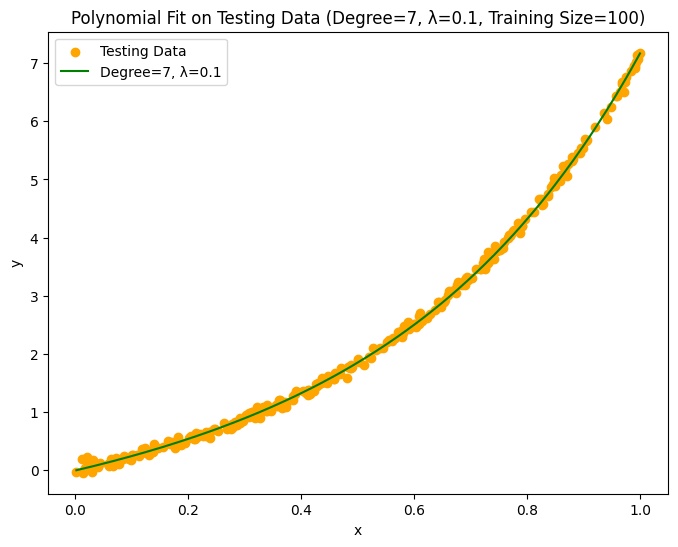

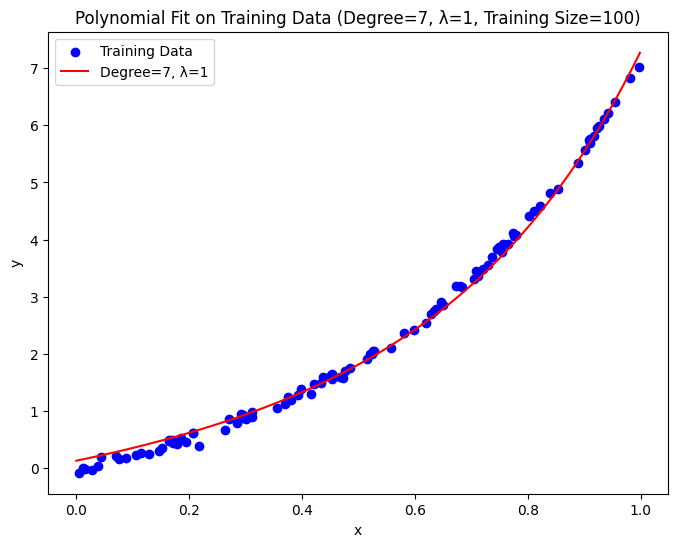

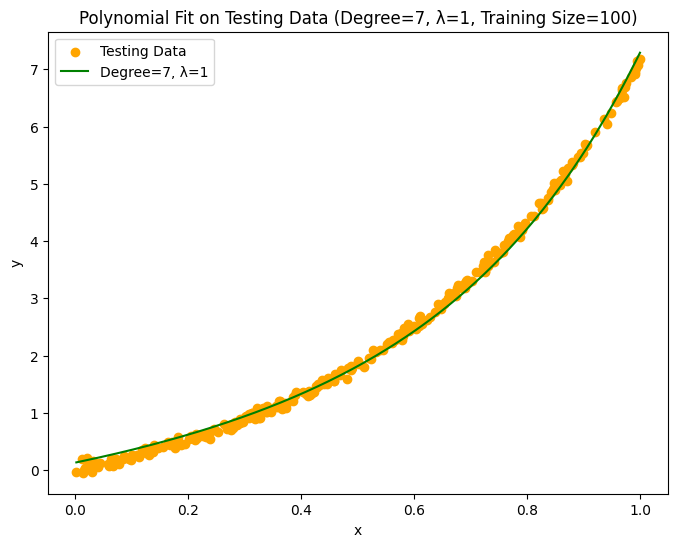

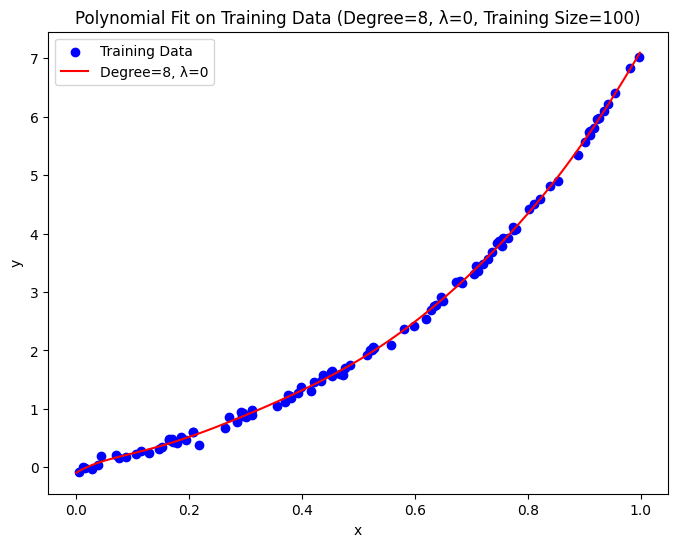

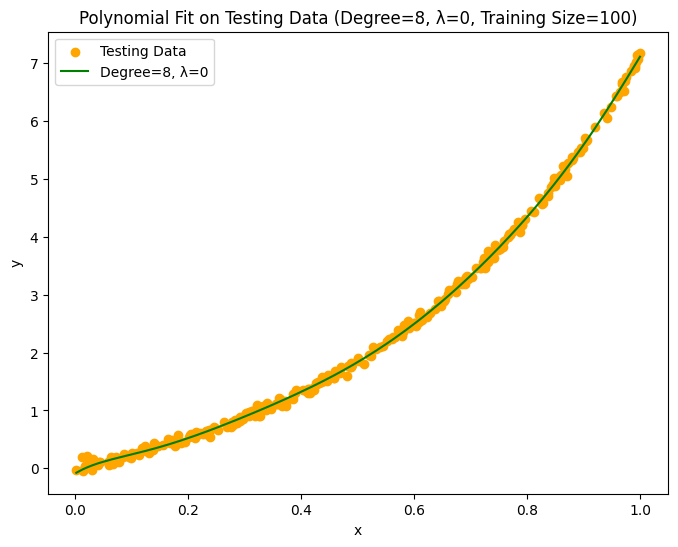

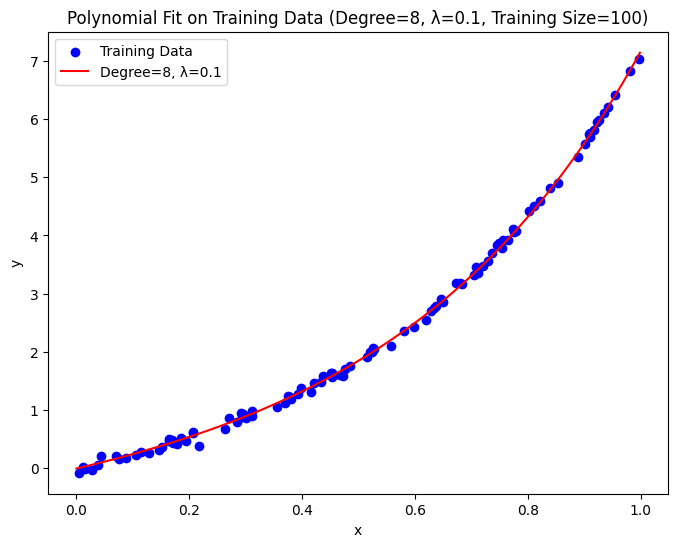

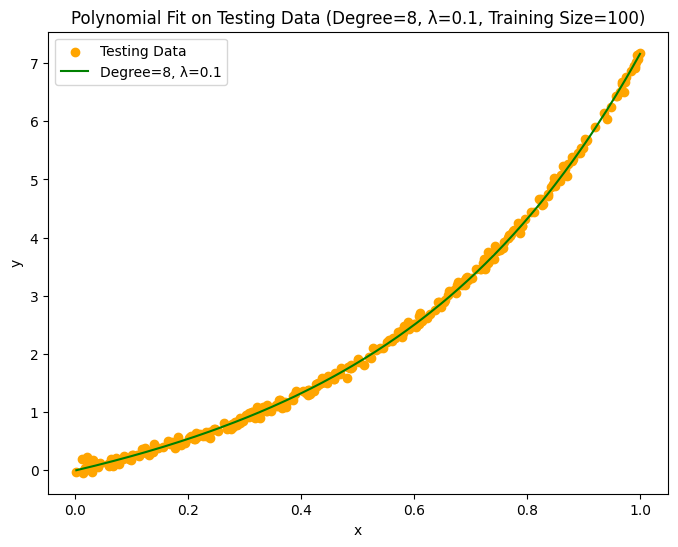

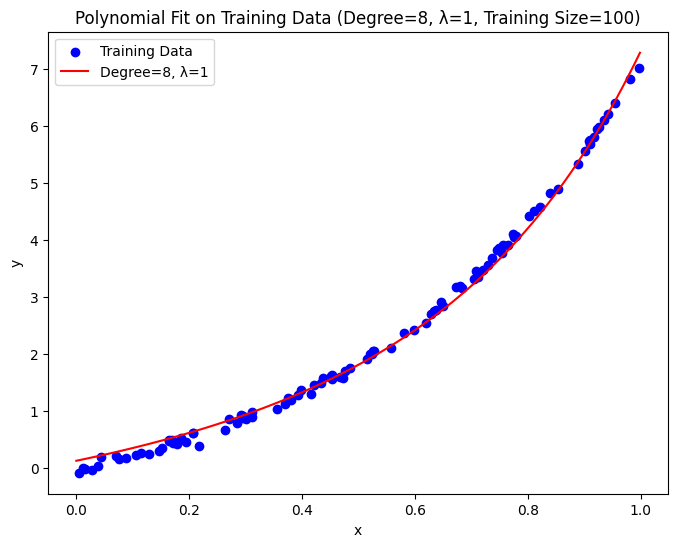

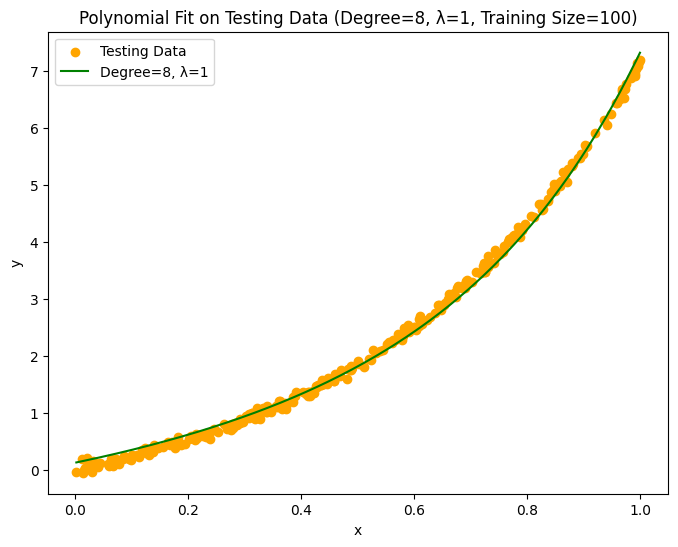

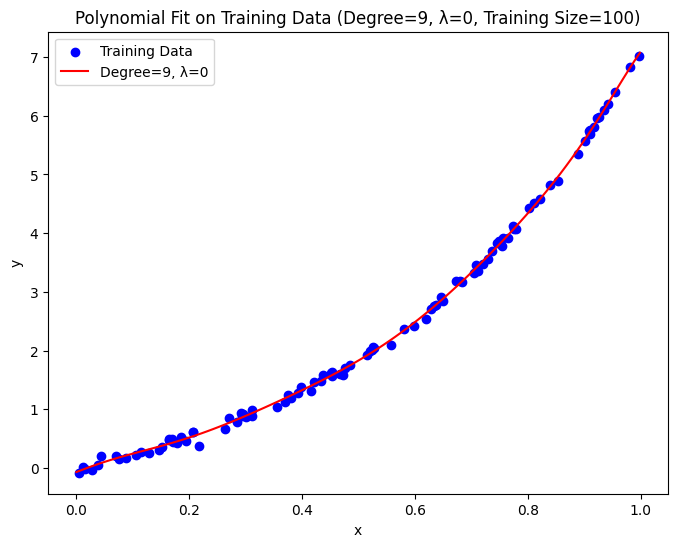

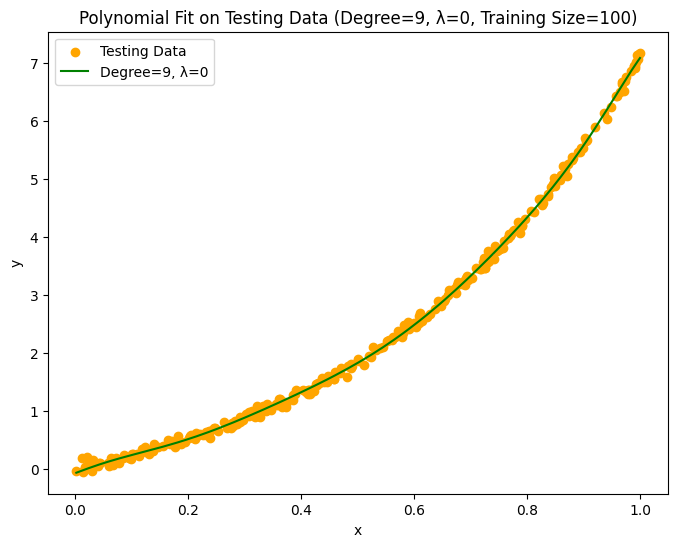

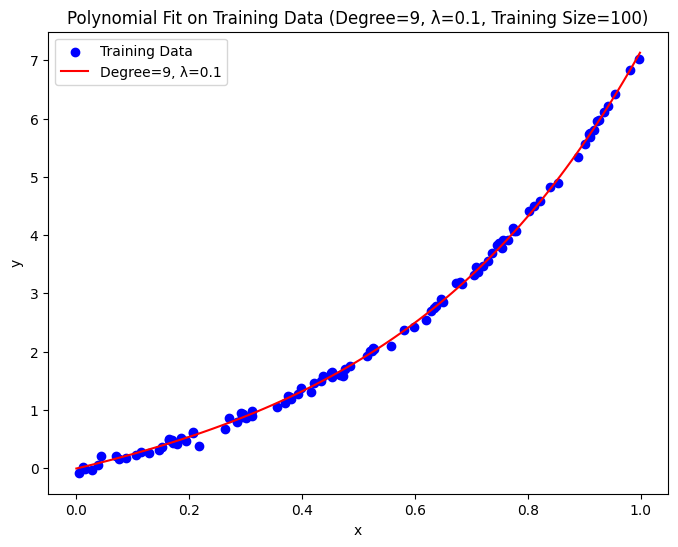

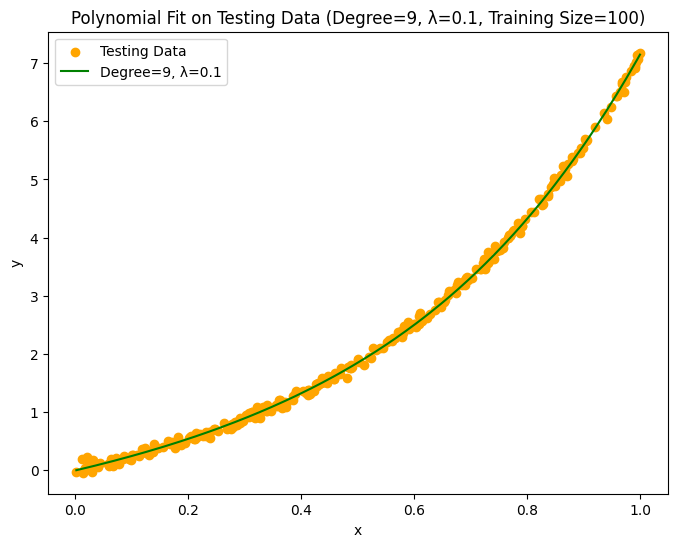

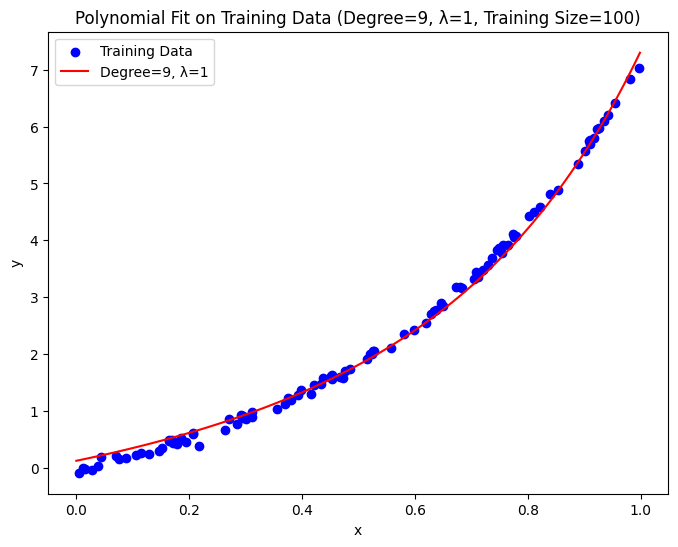

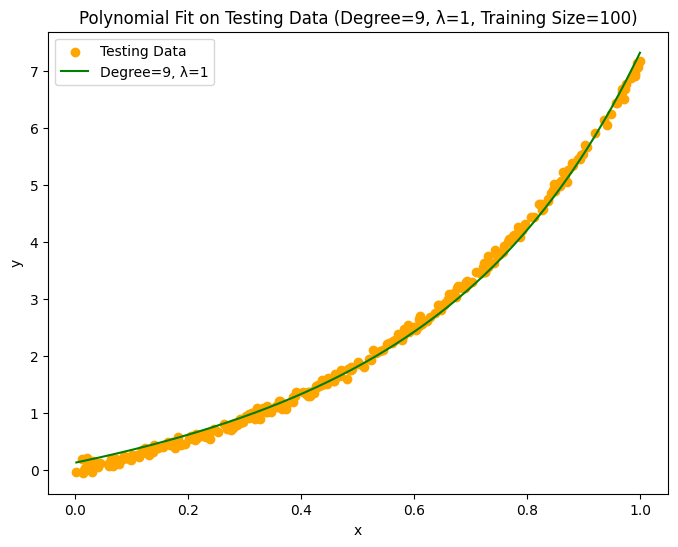

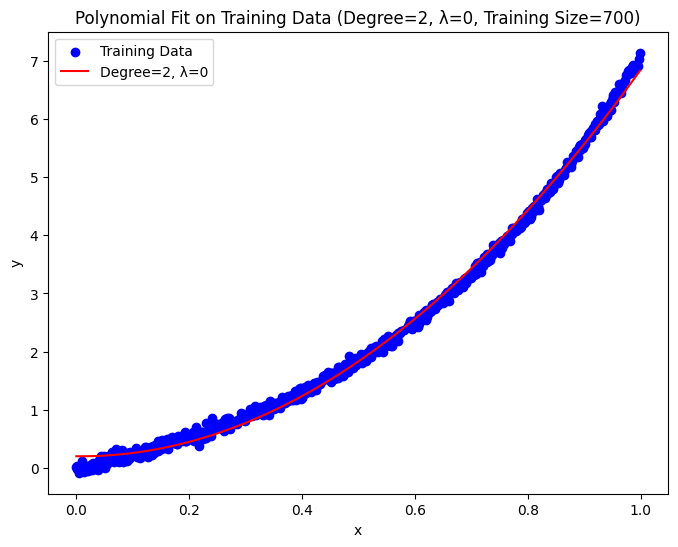

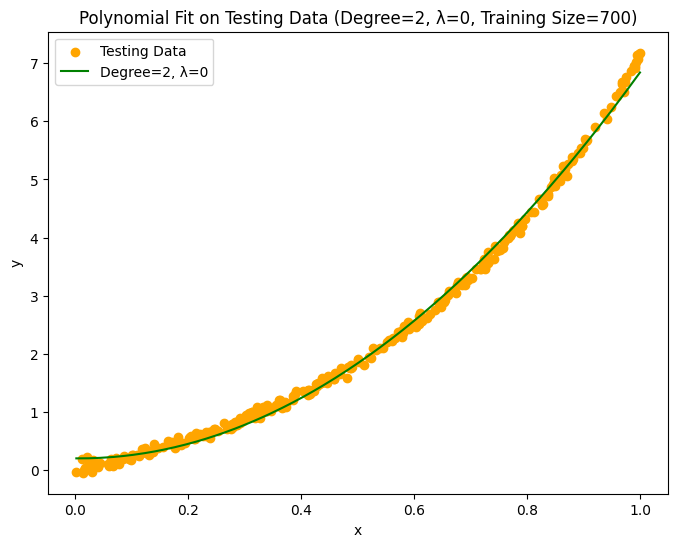

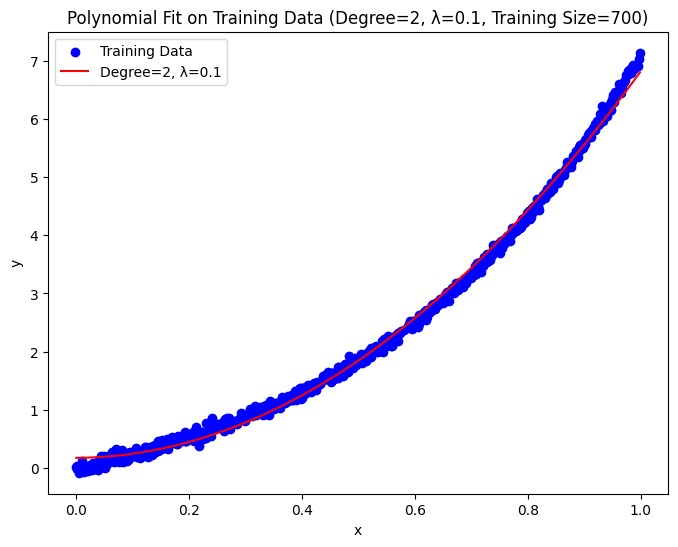

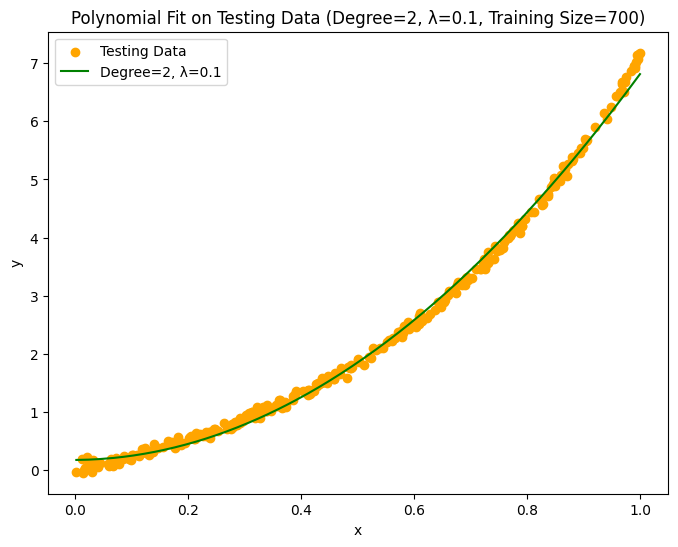

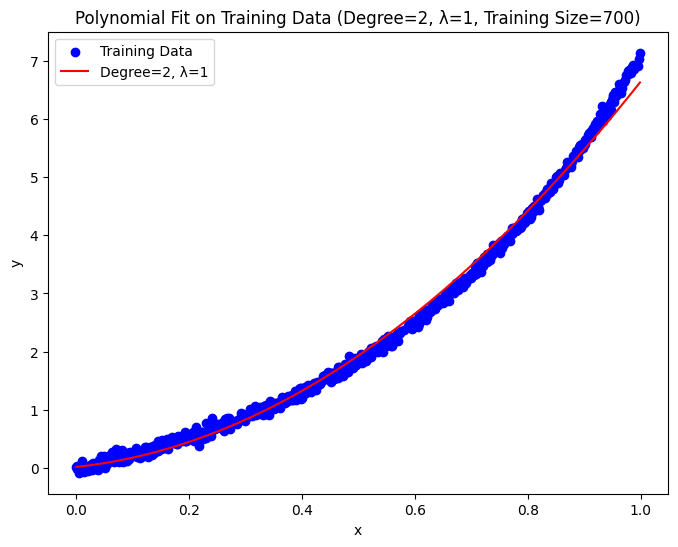

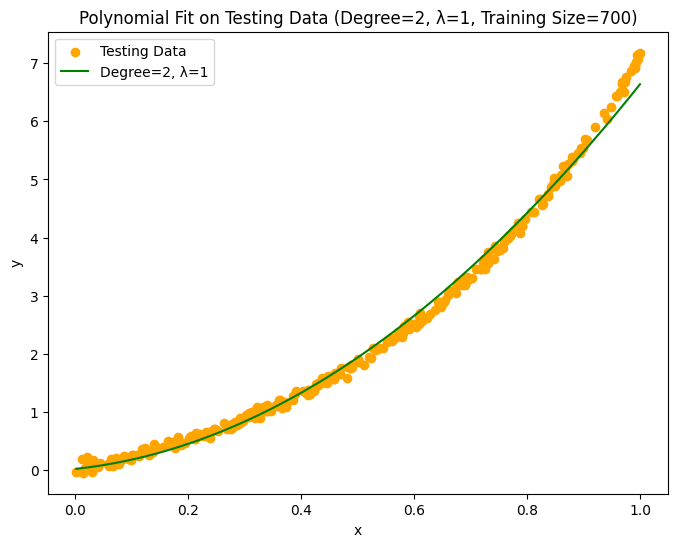

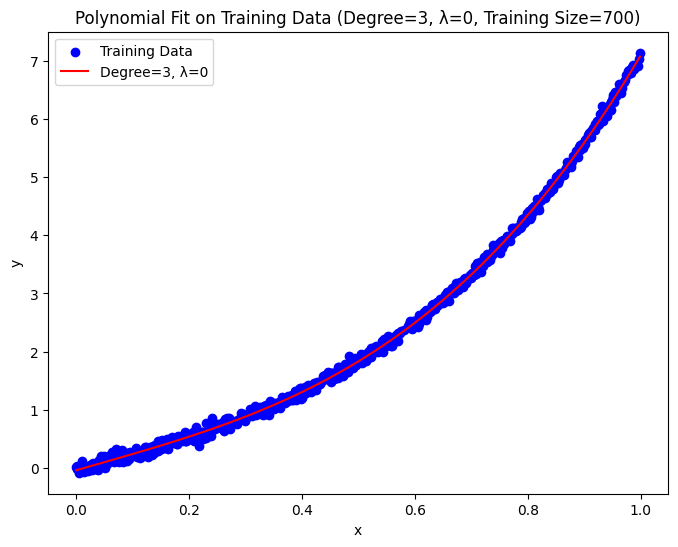

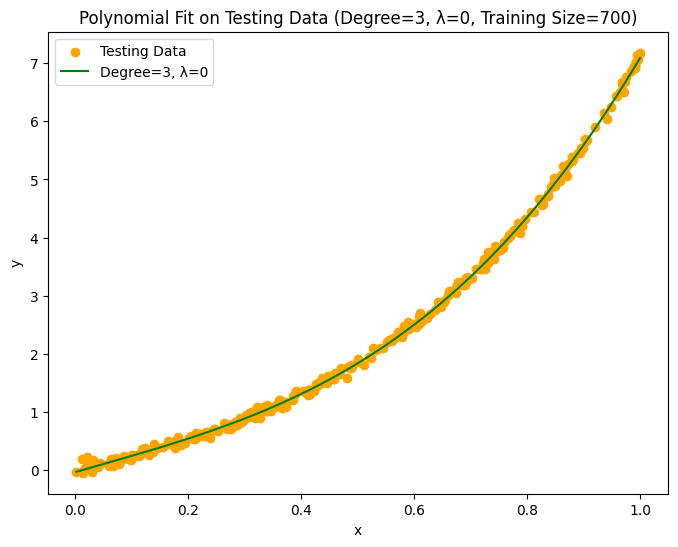

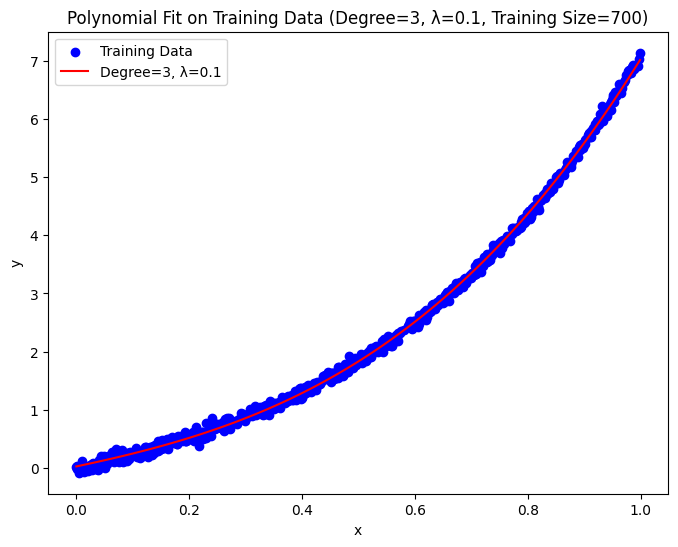

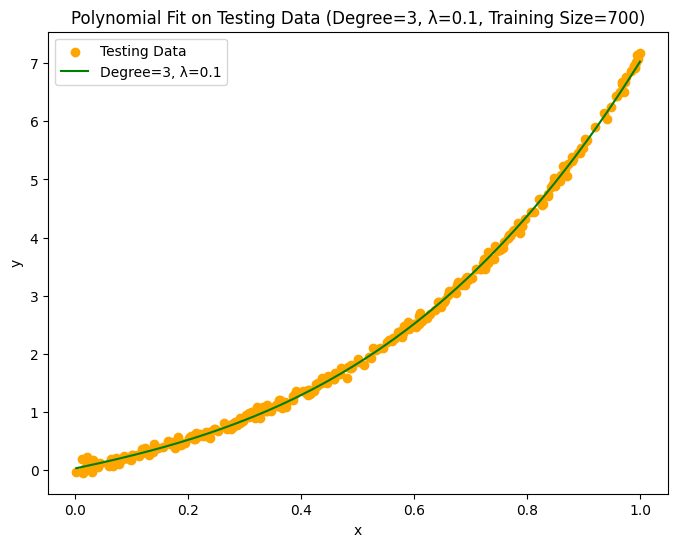

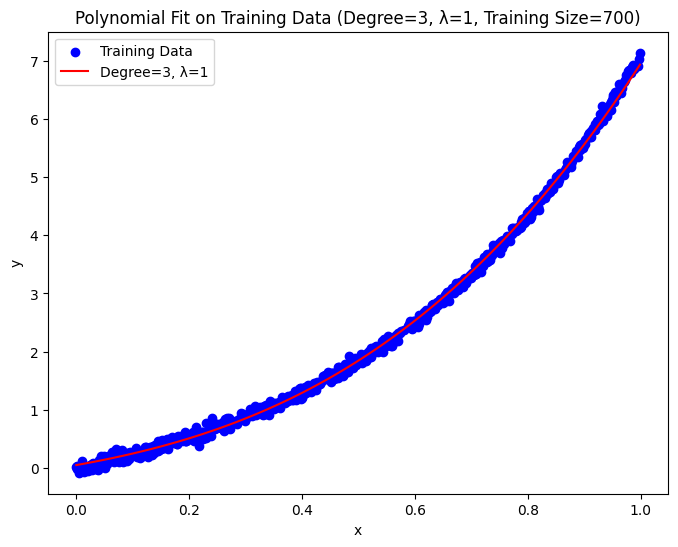

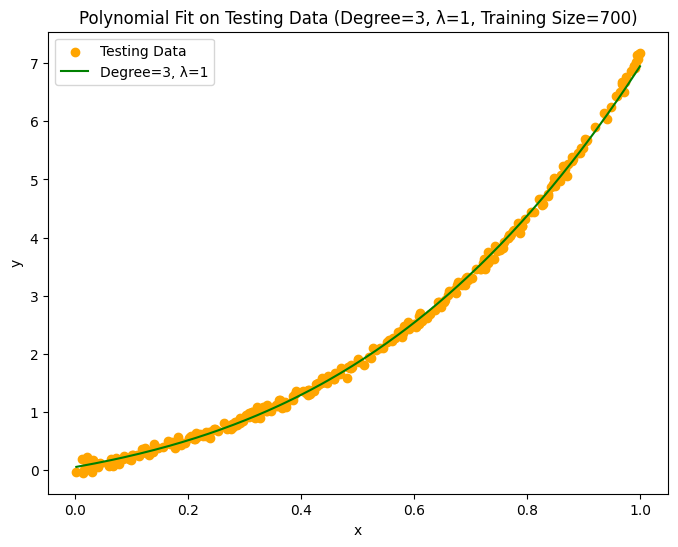

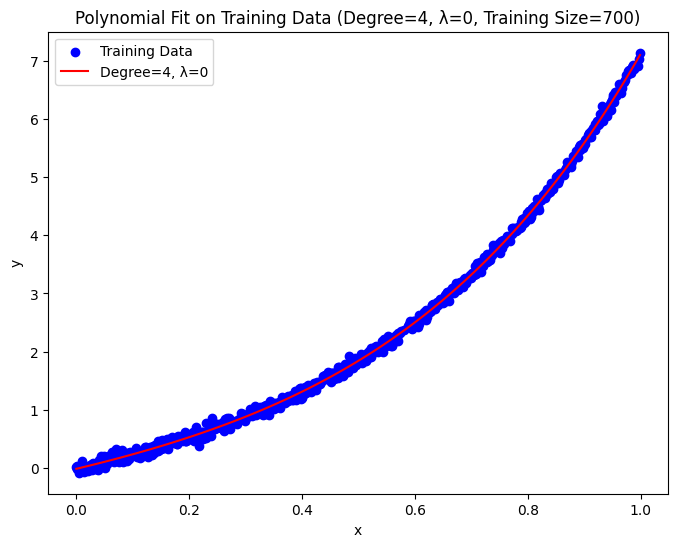

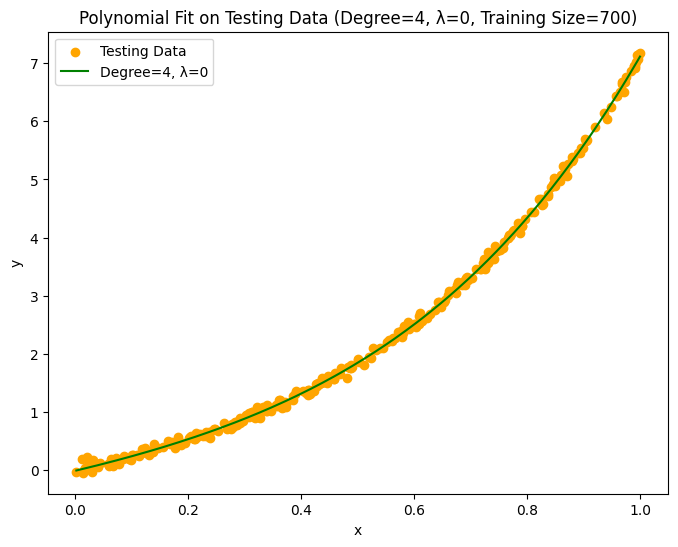

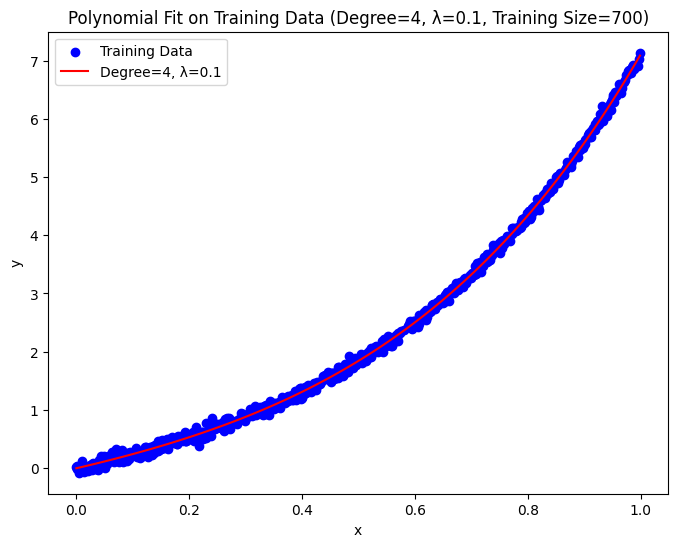

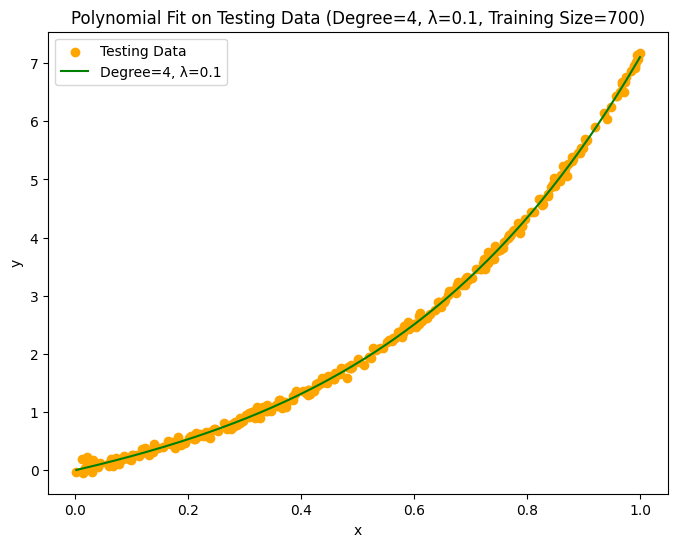

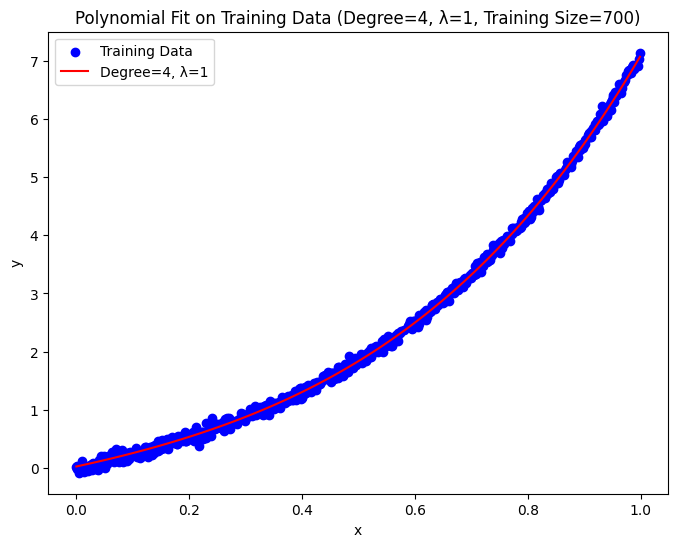

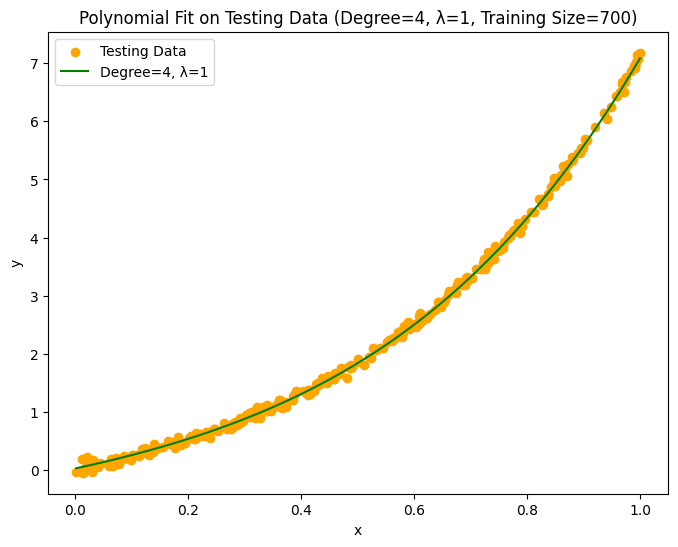

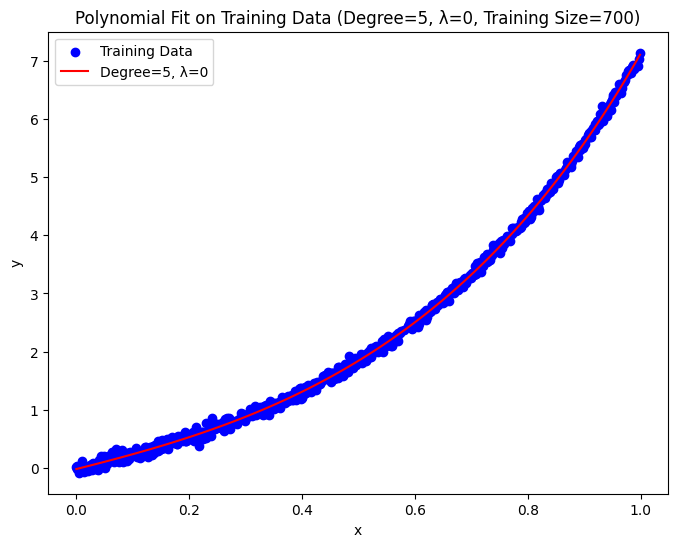

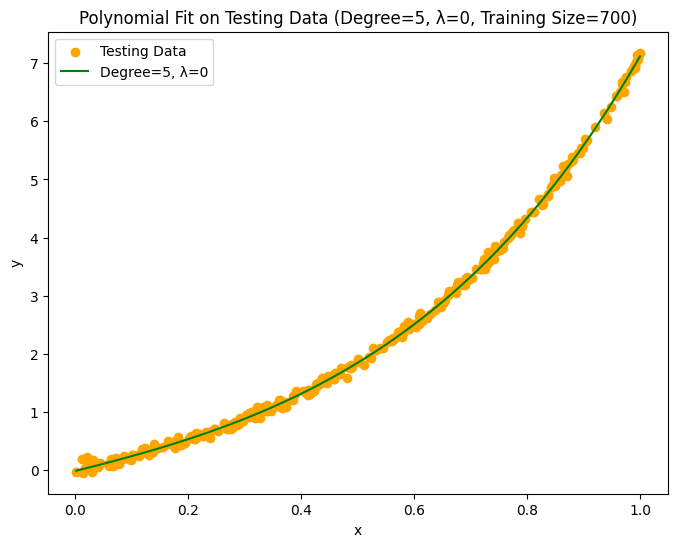

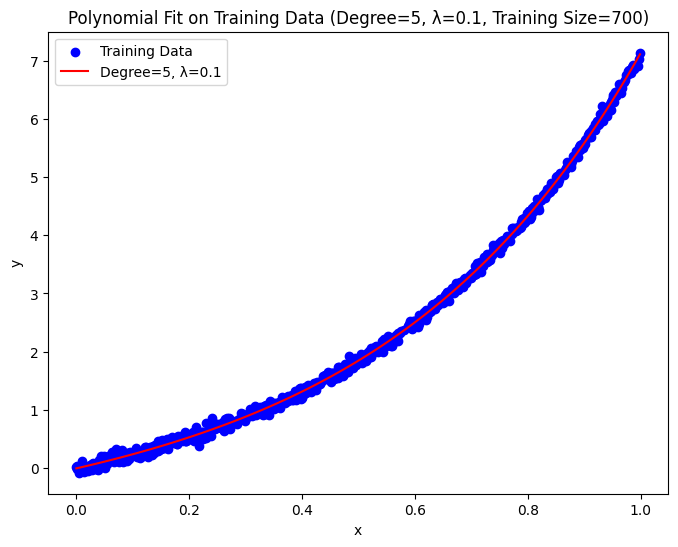

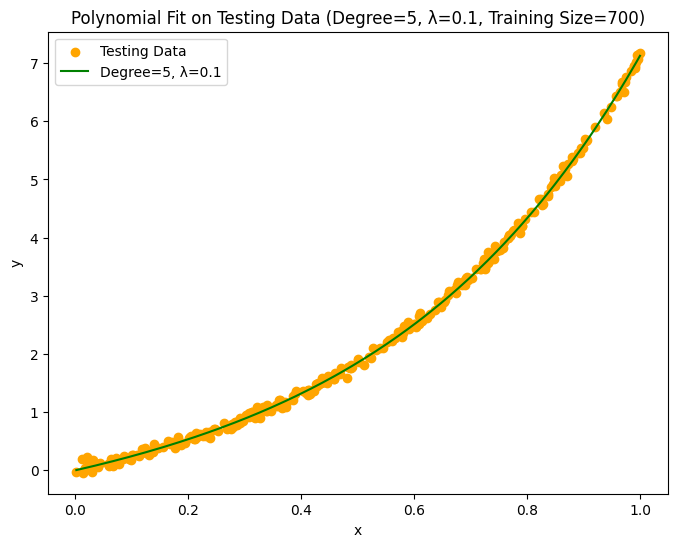

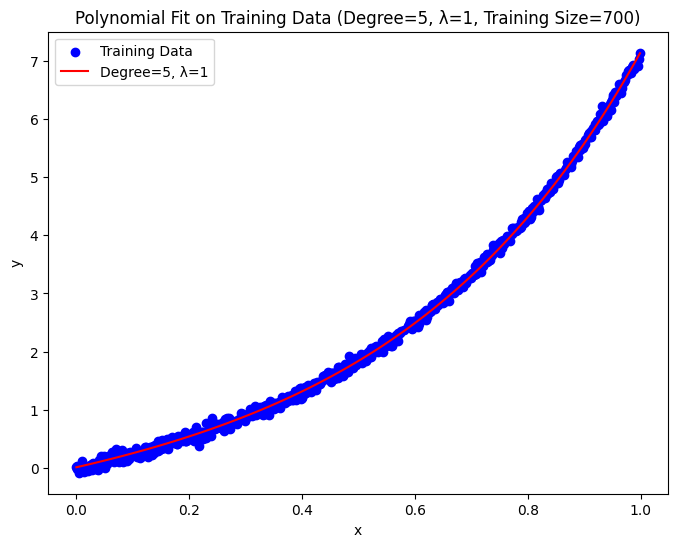

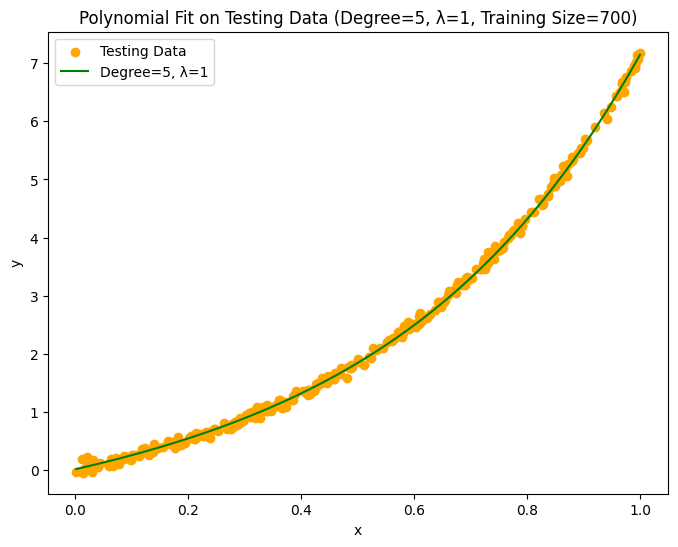

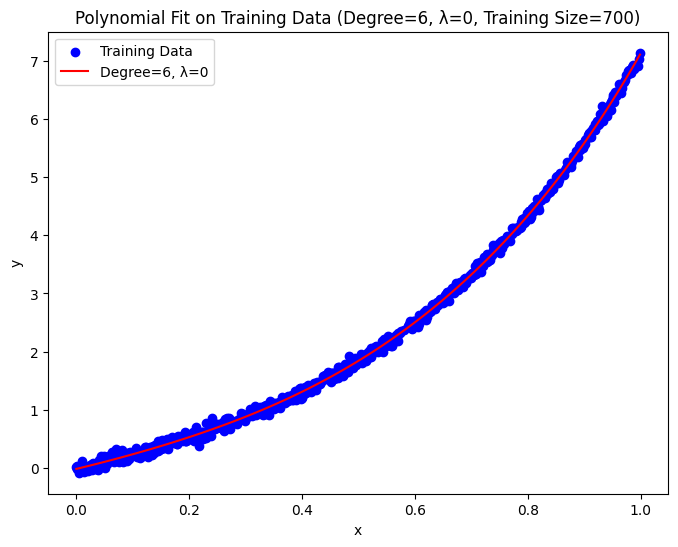

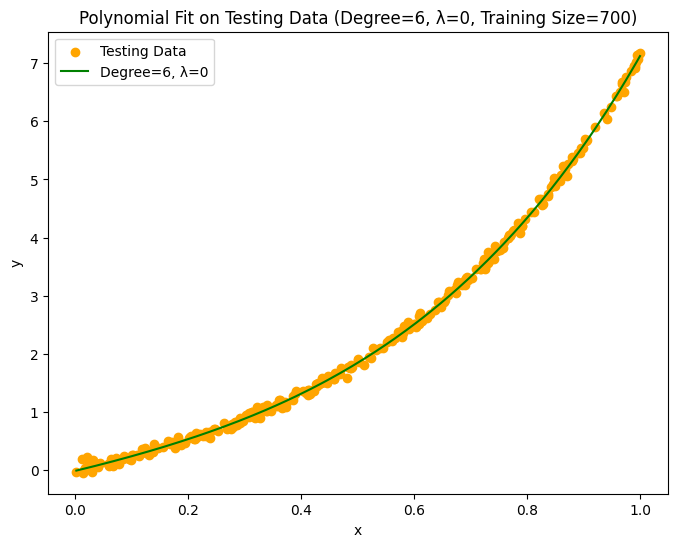

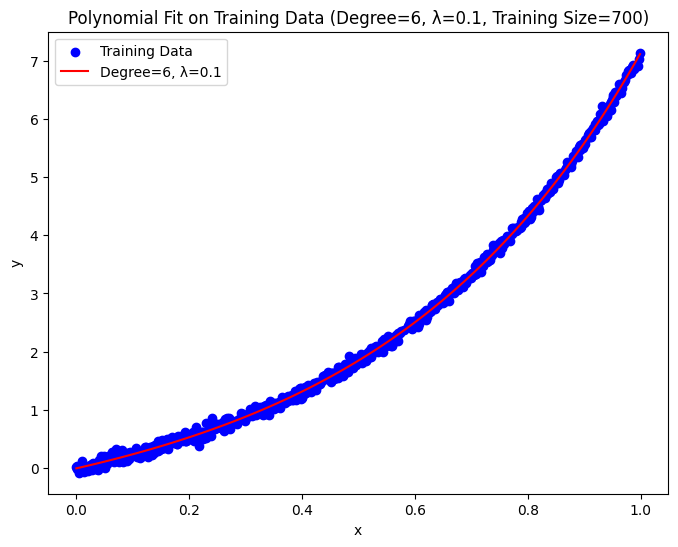

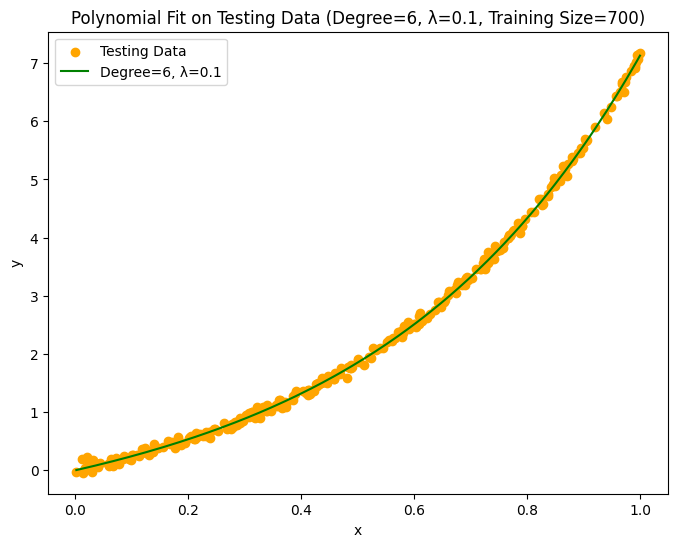

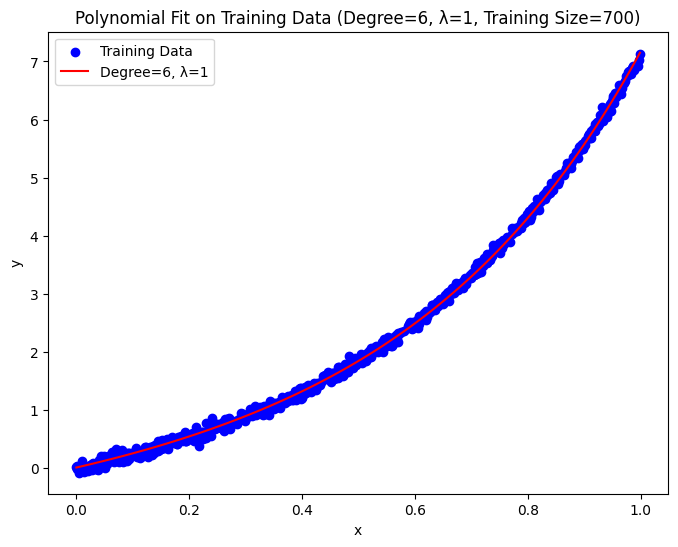

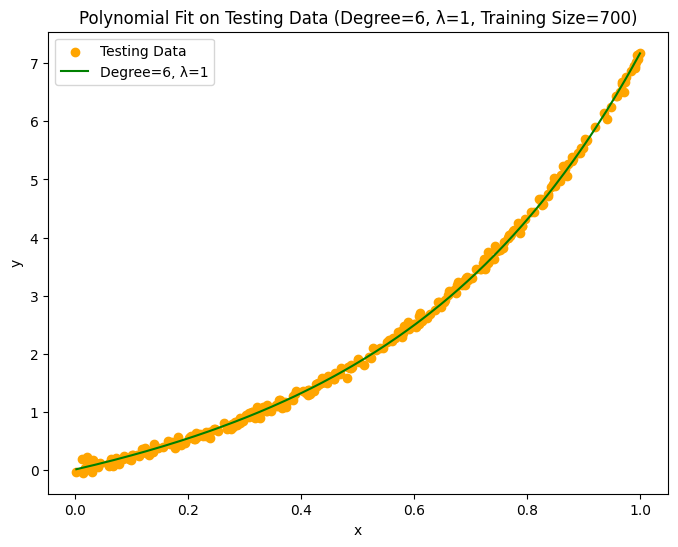

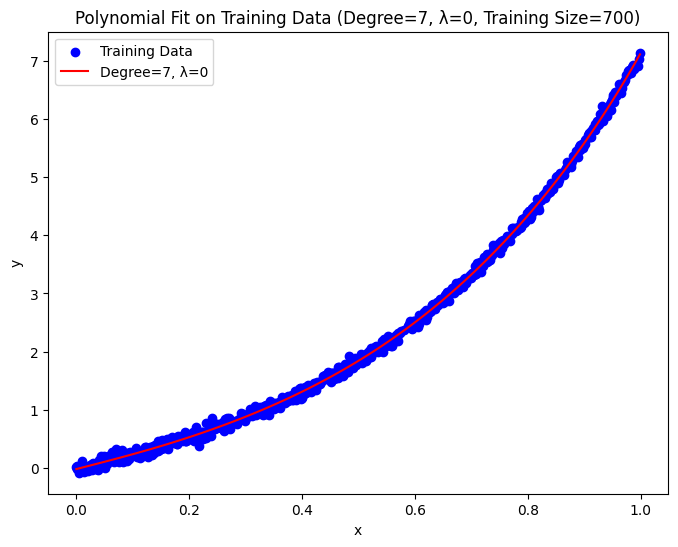

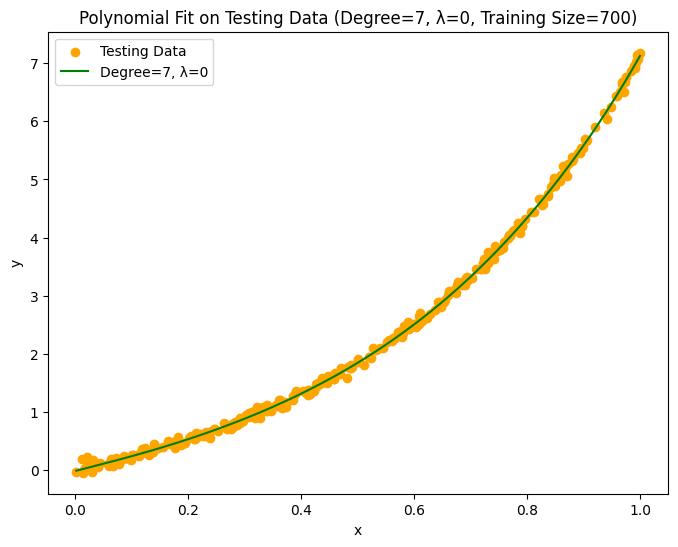

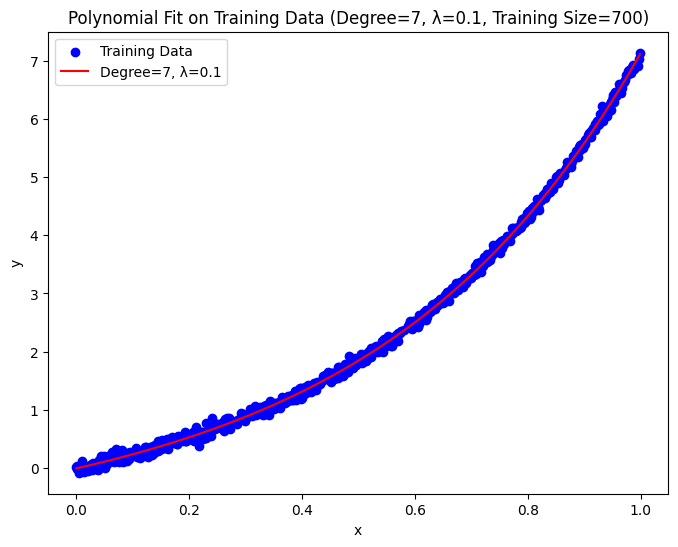

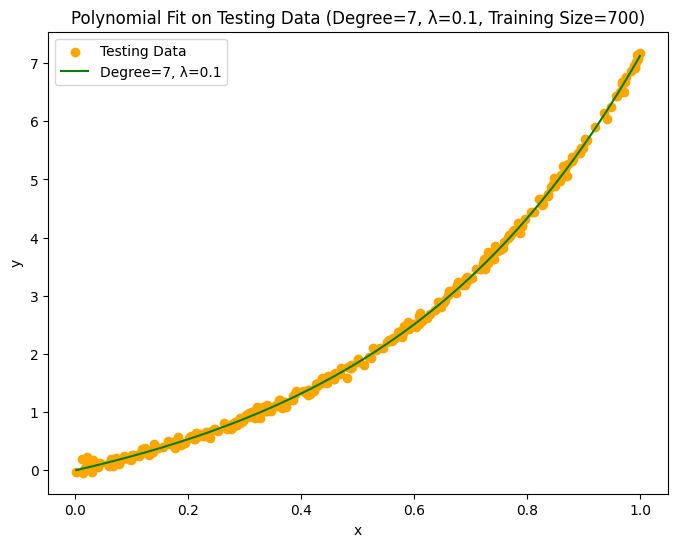

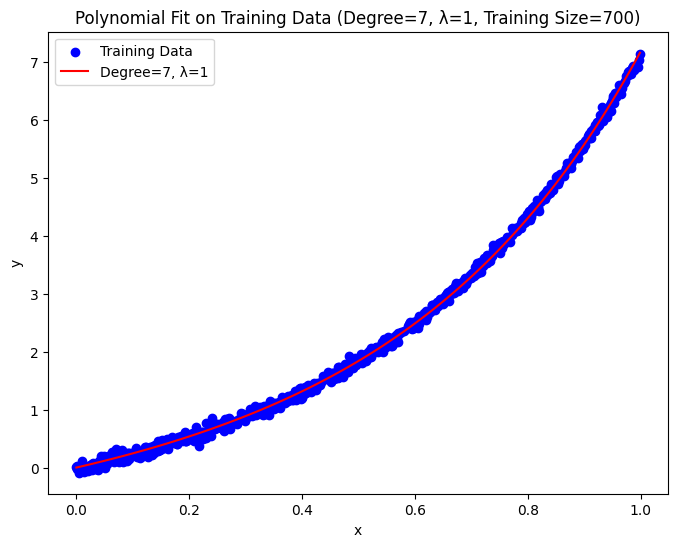

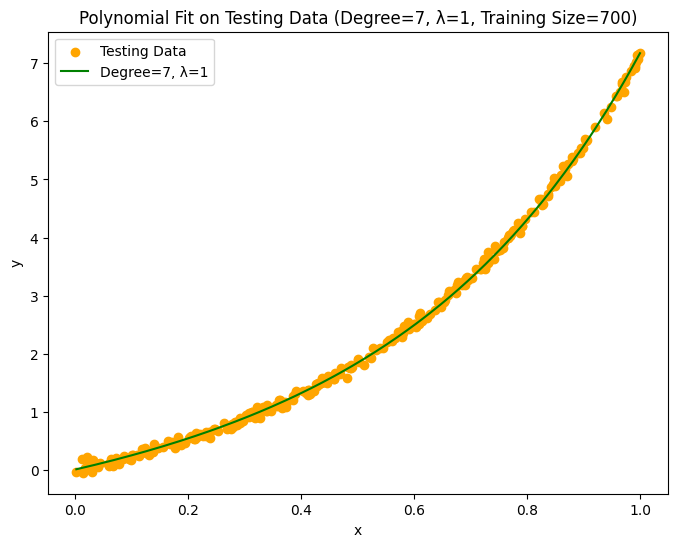

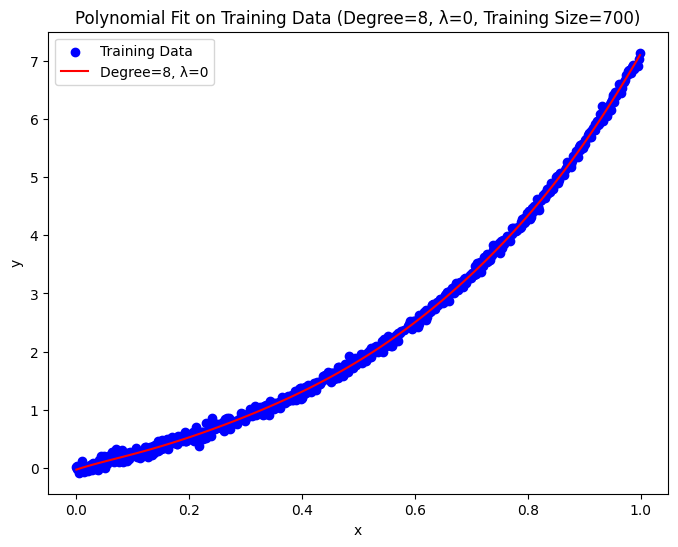

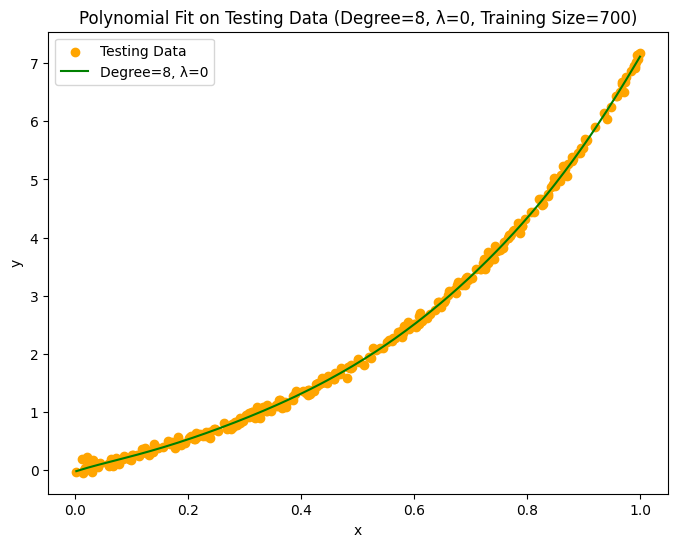

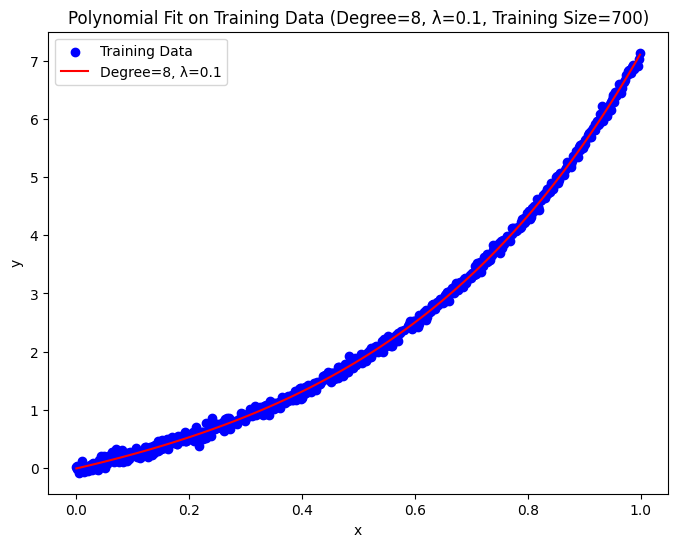

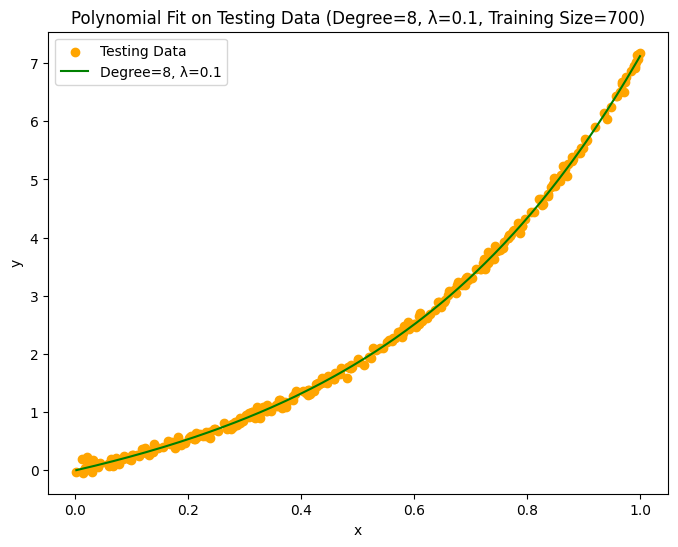

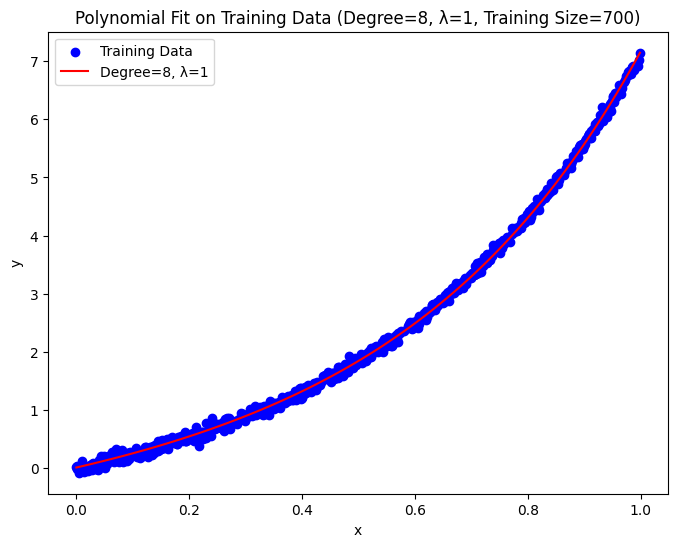

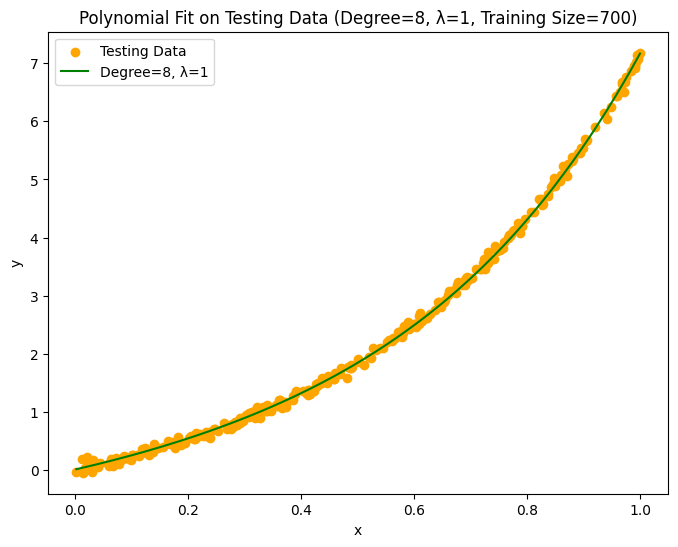

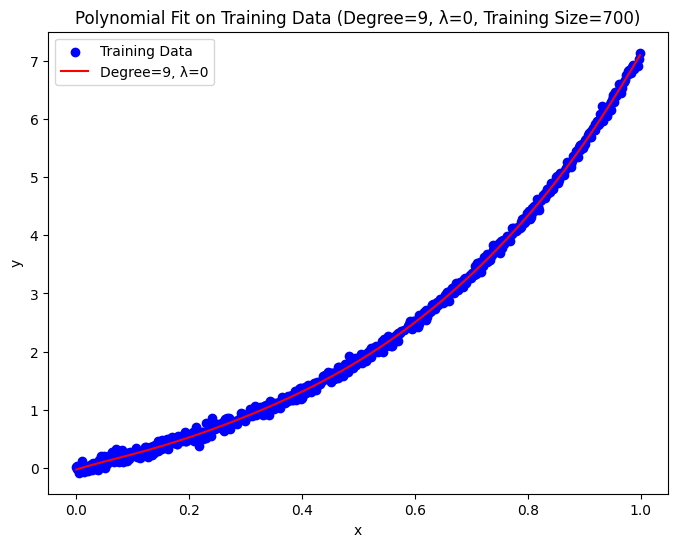

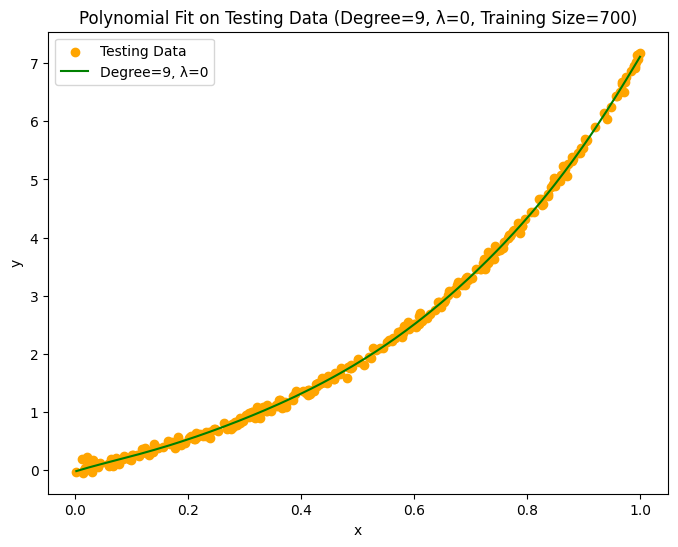

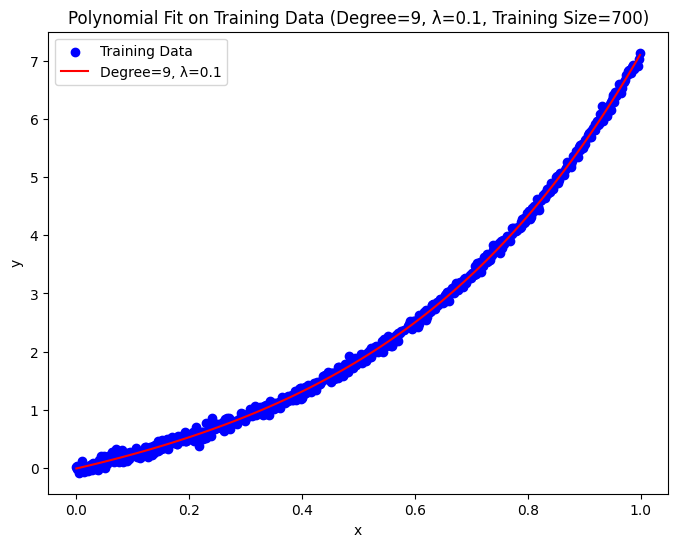

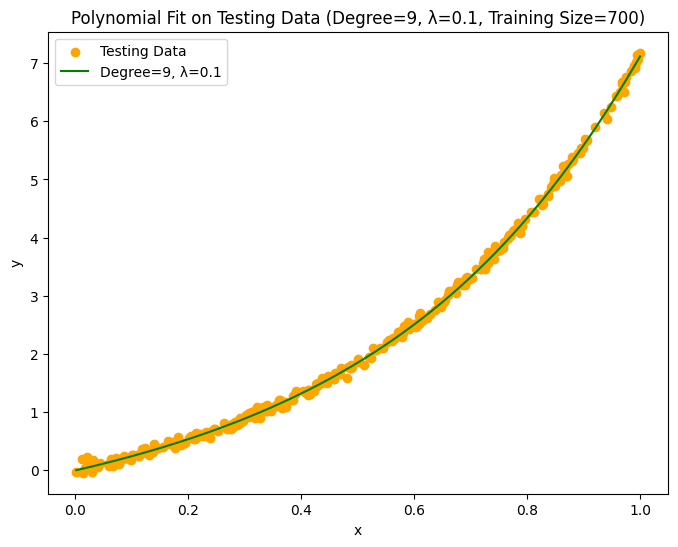

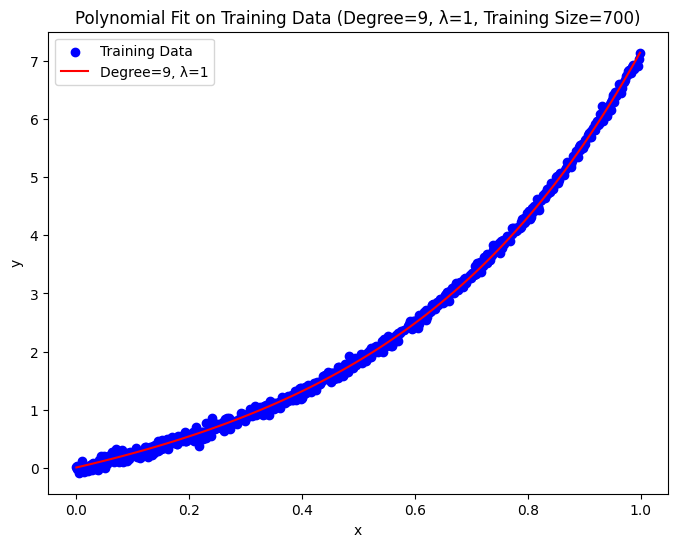

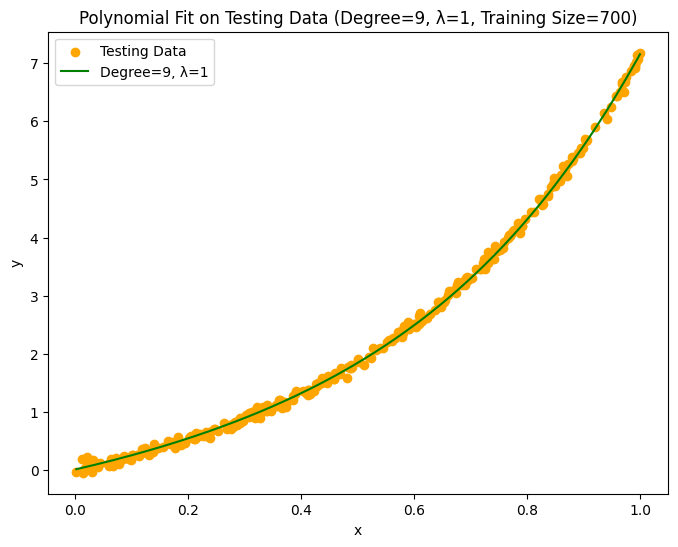

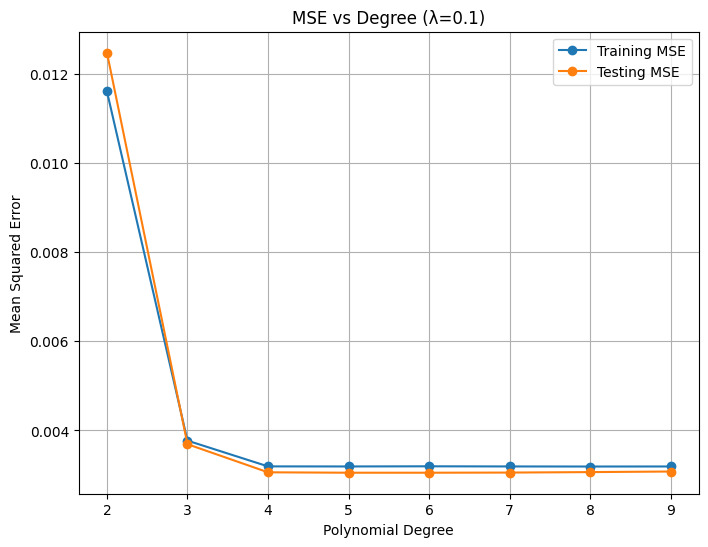

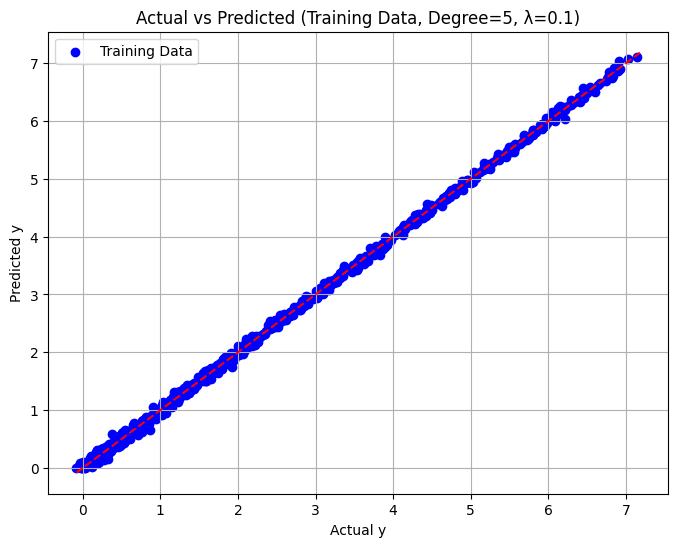

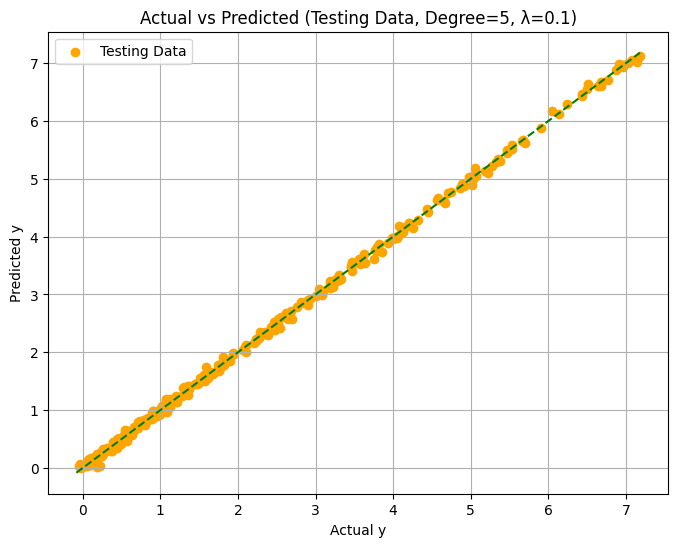

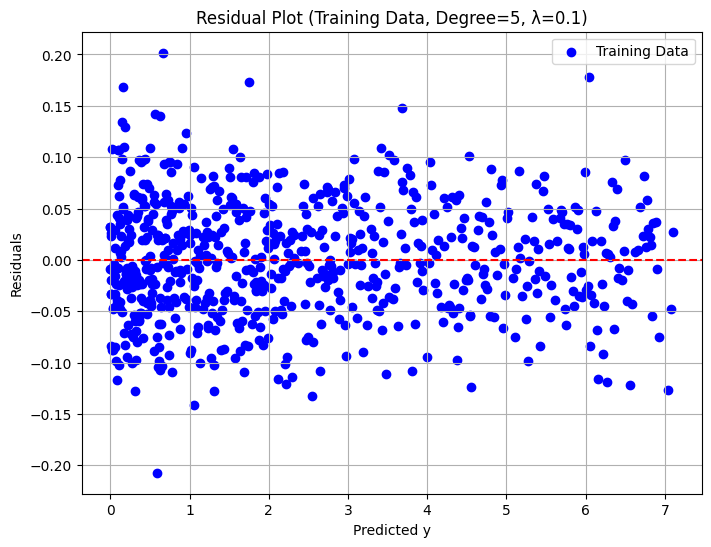

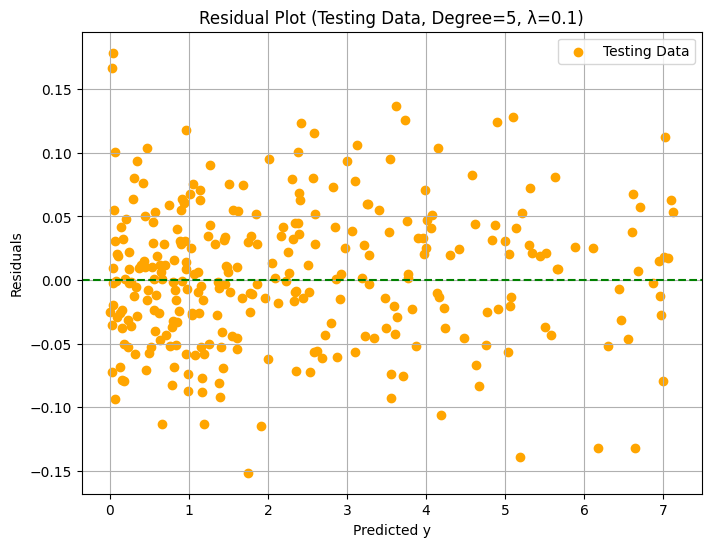

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Load Dataset
data = np.loadtxt('./UnivariateData/6.csv', delimiter=',')  # Make sure to replace 'dataset1.csv' with your actual file name
x_data = data[:, 0]
y_data = data[:, 1]

# Split Data into Training and Test sets (70-30 split)
def train_test_split_manual(x, y, test_size=0.3):
    split_index = int(len(x) * (1 - test_size))
    x_train, y_train = x[:split_index], y[:split_index]
    x_test, y_test = x[split_index:], y[split_index:]
    return x_train, y_train, x_test, y_test

x_train, y_train, x_test, y_test = train_test_split_manual(x_data, y_data, test_size=0.3)

# Polynomial Feature Expansion
def polynomial_features(x, degree):
    """Generate polynomial features up to a specified degree."""
    return np.vander(x, degree + 1, increasing=True)

# Ridge Regression (Polynomial Curve Fitting with Regularization)
def ridge_regression(x, y, degree, reg_lambda=0):
    X = polynomial_features(x, degree)
    I = np.eye(X.shape[1])
    weights = np.linalg.inv(X.T @ X + reg_lambda * I) @ X.T @ y
    
    return weights

# Prediction Function
def predict(x, weights):
    """Predict using polynomial model weights."""
    degree = len(weights) - 1
    X = polynomial_features(x, degree)
    return X @ weights

# Cross-Validation for Optimal Hyperparameters (degree and lambda)
def cross_validation(x, y, max_degree, reg_lambdas, num_folds=5):
    fold_size = len(x) // num_folds
    best_mse = float('inf')
    best_params = None

    for degree in range(2, max_degree + 1):
        for reg_lambda in reg_lambdas:
            mse_total = 0
            for fold in range(num_folds):
                start = fold * fold_size
                end = start + fold_size
                x_val = x[start:end]
                y_val = y[start:end]
                x_train = np.concatenate([x[:start], x[end:]])
                y_train = np.concatenate([y[:start], y[end:]])

                weights = ridge_regression(x_train, y_train, degree, reg_lambda)
                predictions = predict(x_val, weights)
                mse_total += np.mean((y_val - predictions) ** 2)

            avg_mse = mse_total / num_folds
            if avg_mse < best_mse:
                best_mse = avg_mse
                best_params = (degree, reg_lambda)

    return best_params

# Determine Optimal Hyperparameters
optimal_degree, optimal_lambda = cross_validation(x_train, y_train, max_degree=9, reg_lambdas=[0, 0.1, 1, 10, 100])
print("Optimal polynomial degree and regularization lambda:", optimal_degree, optimal_lambda)

# Print Weights for Optimal Parameters
weights_optimal = ridge_regression(x_train, y_train, optimal_degree, optimal_lambda)
print(f"Weights for optimal degree={optimal_degree}, lambda={optimal_lambda}:\n", weights_optimal)

# Plot Polynomial Fits for Different Training Set Sizes
def plot_polynomial_fits(x_train, y_train, x_test, y_test, degrees, reg_lambda_values, sample_sizes):
    for size in sample_sizes:
        indices = np.random.choice(len(x_train), size, replace=False)
        x_sub = x_train[indices]
        y_sub = y_train[indices]

        for degree in degrees:
            for reg_lambda in reg_lambda_values:
                weights = ridge_regression(x_sub, y_sub, degree, reg_lambda)
                
                # Plotting Polynomial Fit for Training Data
                x_range = np.linspace(min(x_train), max(x_train), 100)
                y_pred_train = predict(x_range, weights)
                
                plt.figure(figsize=(8, 6))
                plt.scatter(x_sub, y_sub, label="Training Data", color='blue')
                plt.plot(x_range, y_pred_train, color="red", label=f"Degree={degree}, λ={reg_lambda}")
                plt.title(f"Polynomial Fit on Training Data (Degree={degree}, λ={reg_lambda}, Training Size={size})")
                plt.xlabel("x")
                plt.ylabel("y")
                plt.legend()
                plt.show()

                # Plotting Polynomial Fit for Testing Data
                y_pred_test = predict(x_test, weights)
                
                # Sort x_test and y_pred_test for smooth line plotting
                sorted_indices = np.argsort(x_test)
                x_test_sorted = x_test[sorted_indices]
                y_pred_test_sorted = y_pred_test[sorted_indices]
                
                plt.figure(figsize=(8, 6))
                plt.scatter(x_test, y_test, label="Testing Data", color='orange')
                plt.plot(x_test_sorted, y_pred_test_sorted, color="green", label=f"Degree={degree}, λ={reg_lambda}")
                plt.title(f"Polynomial Fit on Testing Data (Degree={degree}, λ={reg_lambda}, Training Size={size})")
                plt.xlabel("x")
                plt.ylabel("y")
                plt.legend()
                plt.show()

# Plot polynomial fits for different sample sizes
plot_polynomial_fits(x_train, y_train, x_test, y_test, degrees=range(2, 10), reg_lambda_values=[0, 0.1, 1], sample_sizes=[10, 50, 100, len(x_train)])

# Plot MSE vs Polynomial Degree
def plot_mse_vs_degree(x_train, y_train, x_test, y_test, max_degree, reg_lambda):
    train_mse = []
    test_mse = []

    for degree in range(2, max_degree + 1):
        weights = ridge_regression(x_train, y_train, degree, reg_lambda)
        train_predictions = predict(x_train, weights)
        test_predictions = predict(x_test, weights)
        train_mse.append(np.mean((y_train - train_predictions) ** 2))
        test_mse.append(np.mean((y_test - test_predictions) ** 2))

    plt.figure(figsize=(8, 6))
    plt.plot(range(2, max_degree + 1), train_mse, label="Training MSE", marker='o')
    plt.plot(range(2, max_degree + 1), test_mse, label="Testing MSE", marker='o')
    plt.xlabel("Polynomial Degree")
    plt.ylabel("Mean Squared Error")
    plt.legend()
    plt.title(f"MSE vs Degree (λ={reg_lambda})")
    plt.grid()
    plt.show()

# Plot MSE vs Degree for the chosen regularization
plot_mse_vs_degree(x_train, y_train, x_test, y_test, max_degree=9, reg_lambda=optimal_lambda)

# Actual vs Predicted Targets and Residual Plots
def actual_vs_predicted_and_residuals(x_train, y_train, x_test, y_test, degree, reg_lambda):
    weights = ridge_regression(x_train, y_train, degree, reg_lambda)
    train_predictions = predict(x_train, weights)
    test_predictions = predict(x_test, weights)

    # Actual vs Predicted (Training Data)
    plt.figure(figsize=(8, 6))
    plt.scatter(y_train, train_predictions, label="Training Data", color='blue')
    plt.plot([min(y_data), max(y_data)], [min(y_data), max(y_data)], color="red", linestyle="--")
    plt.xlabel("Actual y")
    plt.ylabel("Predicted y")
    plt.legend()
    plt.title(f"Actual vs Predicted (Training Data, Degree={degree}, λ={reg_lambda})")
    plt.grid()
    plt.show()

    # Actual vs Predicted (Testing Data)
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, test_predictions, label="Testing Data", color='orange')
    plt.plot([min(y_data), max(y_data)], [min(y_data), max(y_data)], color="green", linestyle="--")
    plt.xlabel("Actual y")
    plt.ylabel("Predicted y")
    plt.legend()
    plt.title(f"Actual vs Predicted (Testing Data, Degree={degree}, λ={reg_lambda})")
    plt.grid()
    plt.show()

    # Residual Plot for Training Data
    train_residuals = y_train - train_predictions
    plt.figure(figsize=(8, 6))
    plt.scatter(train_predictions, train_residuals, label="Training Data", color='blue')
    plt.axhline(0, color="red", linestyle="--")
    plt.xlabel("Predicted y")
    plt.ylabel("Residuals")
    plt.legend()
    plt.title(f"Residual Plot (Training Data, Degree={degree}, λ={reg_lambda})")
    plt.grid()
    plt.show()

    # Residual Plot for Testing Data
    test_residuals = y_test - test_predictions
    plt.figure(figsize=(8, 6))
    plt.scatter(test_predictions, test_residuals, label="Testing Data", color='orange')
    plt.axhline(0, color="green", linestyle="--")
    plt.xlabel("Predicted y")
    plt.ylabel("Residuals")
    plt.legend()
    plt.title(f"Residual Plot (Testing Data, Degree={degree}, λ={reg_lambda})")
    plt.grid()
    plt.show()

# Generate Actual vs Predicted and Residual plots for the best model
actual_vs_predicted_and_residuals(x_train, y_train, x_test, y_test, optimal_degree, optimal_lambda)
